In [1]:
if "run_once" not in get_ipython().user_ns:
    %cd ..
    %cd ..
    get_ipython().user_ns["run_once"] = True

/home/chamara/Documents/projects/1-poisoning-xai/notebooks
/home/chamara/Documents/projects/1-poisoning-xai


In [2]:
import flwr as fl
import torch

%matplotlib inline
import importlib

# import sys
# sys.path.append('../src')
from src.FLProcess.CustomFedAvg import CustomFedAvg
from src.FLProcess.FLUtil import weighted_average
from src.FLProcess.FlowerClient import FlowerClient
from src.NN.NNConfig import get_nn
from src.dataset import dataLoaderFactory
from src.dataset.datasetStrategy import poison_strategy_with_non_iid_split, poison_strategy_for_multi_label_split
from src.poisonDetection.clientAnalysis.strategyFnGeneralAlg import client_analysis_fn_general_alg
from src.poisonDetection.clientAnalysis.strategyFnDebugging import client_analysis_strategy_fn_debugging
from src.poisonDetection.clientAnalysis.strategyFnRandomPoison import client_analysis_strategy_fn_random_poison
# from util.constants import NUM_CLIENTS
from util import constants
from src.NN import NNUtil
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from captum.attr import LayerLRP
from captum.attr import LayerAttribution
import time
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import copy
import random

import ray
# Import necessary captum tools
# importlib.reload(dataLoaderFactory) # for library code modifications
# importlib.reload(constants) 
# importlib.reload(NNUtil) 

2024-12-03 11:09:18.185373: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 11:09:18.254996: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 11:09:19.667617: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from src.FLProcess.FLUtil import get_mdl_from_weights, get_pred_from_models, get_mdl_of_client_at_round
from src.dataset.datasetHandler import get_testloader
import shap
from src.poisonDetection.clusteringHDBSCAN import run_hdbscan_clustering_algorithm
from src.poisonDetection.tsneVisualisation import get_tsne_data_from_input_features, visualise_tsne_clusters_with_idx, \
    visualise_clusters_with_tsne
from src.poisonDetection.clientAnalysis.strategyFnGeneralAlg import general_algorithm_main_calc
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

In [4]:
# import torch
# torch.cuda.is_available()

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
def set_constants(num_clients=10, selected_dataset='MNIST'):
    constants.NUM_CLIENTS = num_clients
    constants.SELECTED_DATASET = selected_dataset

In [7]:
set_constants(num_clients=10, selected_dataset='MNIST')

In [8]:
num_poison = 0
num_classes = 10

In [9]:
kwargs_train = {'poison_type': 'target_poison', 'poison_ratio': 1, 'target_label': 9, 'target_clients': [i for i in range(num_poison)]}
# kwargs_train = {'poison_type': 'random_poison', 'poison_ratio': 1, 'target_clients': [1,2,3]}
kwargs_val = {'poison_type': 'random_poison', 'poison_ratio': 0, 'target_clients': []}
trainloaders, valloaders, testloaders = dataLoaderFactory.generate_data_loaders(kwargs_train, kwargs_val,
                          strategy=poison_strategy_with_non_iid_split,
                          len_train_data=10000, len_test_data=1000,
                          random_ratio=1, is_visualize=False,
                          visualize_idx=0)

10000
generating train set
processing client:  0
no poisoning for client:  0
processing client:  1
no poisoning for client:  1
processing client:  2
no poisoning for client:  2
processing client:  3
no poisoning for client:  3
processing client:  4
no poisoning for client:  4
processing client:  5
no poisoning for client:  5
processing client:  6
no poisoning for client:  6
processing client:  7
no poisoning for client:  7
processing client:  8
no poisoning for client:  8
processing client:  9
no poisoning for client:  9
generating validation set
processing client:  0
no poisoning for client:  0
processing client:  1
no poisoning for client:  1
processing client:  2
no poisoning for client:  2
processing client:  3
no poisoning for client:  3
processing client:  4
no poisoning for client:  4
processing client:  5
no poisoning for client:  5
processing client:  6
no poisoning for client:  6
processing client:  7
no poisoning for client:  7
processing client:  8
no poisoning for client: 

In [10]:
from src.NN.MdlTraining import train, test
from src.NN.NNUtil import get_parameters, set_parameters
class FlowerClientDecen(fl.client.NumPyClient):
    def __init__(self, net, train_loader, val_loader, local_eps = 1):
        self.net = net
        self.trainloader = train_loader
        self.valloader = val_loader
        self.local_eps = local_eps

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        # train_multi_label(self.net, self.trainloader, epochs=1)
        train(self.net, self.trainloader, epochs=self.local_eps)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        # loss, accuracy = test_multi_label(self.net, self.valloader)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [11]:
def client_fn(cid) -> FlowerClientDecen:
    """Create a Flower client representing a single organization."""
    # Load model
    net = get_nn()
    net.to(constants.DEVICE)
    # trainloaders, valloaders, _ = get_train_val_test_loaders()
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClientDecen(net, trainloader, valloader, local_eps=5)

In [12]:
client_updates_list_nw = []
aggregated_updates_list = []
results = []
weight_results = []
eliminated_client_list = []
eliminated_client_ids = []
debug_info = []

# should update these value based on the dataset: total_labels_per_client, target_label
kwargs_poison = {'client_ids': ['0', '1', '2', '3', '4'],
                        'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 20,
                        'target_label': 1, 'is_pca': False, 'num_pca_features': 80,
                        'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 2,
                        'min_cluster_size': 2, 'perplexity': 10,
                        'show_poison_detection_graphs': True, 'malicious_start_idx': 10, 'malicious_end_idx': 40, 'epsilon':0.0,
                        'debug_info': debug_info,'is_eliminating_clients':False}

# kwargs_poison_NSL_KDD = {'client_ids': ['0', '1', '2', '3', '4'],
#                         'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
#                         'target_label': 1, 'is_pca': False, 'num_pca_features': 80,
#                         'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 2,
#                         'min_cluster_size': 2, 'perplexity': 19,
#                         'show_poison_detection_graphs': False, 'malicious_start_idx': 2, 'malicious_end_idx': 8,
#                         'debug_info': debug_info,'is_eliminating_clients':True}

strategy = CustomFedAvg(
    fraction_fit=1.0,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    client_updates_list=client_updates_list_nw,
    aggregated_updates_list=aggregated_updates_list,
    results_all=results,
    # client_analysis_strategy_fn=client_analysis_fn_general_alg,
    strategy_kwargs=kwargs_poison,
    eliminated_client_list=eliminated_client_list,
    eliminated_client_ids=eliminated_client_ids,
    weight_results=weight_results
)

client_resources = None
if constants.DEVICE == "cuda":
    # 10 client can run concurrently on a single GPU, but only if you have 10 CPU threads. 
    client_resources = {"num_cpus": 1, "num_gpus": 0.2}

# Start simulation
sim = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=constants.NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
    ray_init_args={"log_to_driver": False, "num_cpus": 10, "num_gpus": 1}
)

INFO flwr 2024-12-03 11:10:49,624 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
12/03/2024 11:10:49:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-12-03 11:10:52,672	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2024-12-03 11:10:53,819 | app.py:210 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 37309410510.0, 'object_store_memory': 18654705254.0, 'CPU': 10.0, 'GPU': 1.0, 'node:193.1.133.164': 1.0}
12/03/2024 11:10:53:INFO:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 37309410510.0, 'object_store_memory': 18654705254.0, 'CPU': 10.0, 'GPU': 1.0, 'node:193.1.133.164': 1.0}
INFO flwr 2024-12-03 11:10:53,821 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.2}
12/03/2024 11:10:53:INFO:Flower VCE: Resources for 

Attempting to initialize parameters


INFO flwr 2024-12-03 11:11:02,426 | server.py:280 | Received initial parameters from one random client
12/03/2024 11:11:02:INFO:Received initial parameters from one random client
INFO flwr 2024-12-03 11:11:02,429 | server.py:91 | Evaluating initial parameters
12/03/2024 11:11:02:INFO:Evaluating initial parameters
INFO flwr 2024-12-03 11:11:02,431 | server.py:104 | FL starting
12/03/2024 11:11:02:INFO:FL starting
DEBUG flwr 2024-12-03 11:11:02,433 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
12/03/2024 11:11:02:DEBUG:fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-12-03 11:11:16,123 | server.py:236 | fit_round 1 received 10 results and 0 failures
12/03/2024 11:11:16:DEBUG:fit_round 1 received 10 results and 0 failures
WARNING flwr 2024-12-03 11:11:16,284 | CustomFedAvg.py:147 | No fit_metrics_aggregation_fn provided
12/03/2024 11:11:16:WARNING:No fit_metrics_aggregation_fn provided
DEBUG flwr 2024-12-03 11:11:16,287 | server.py:173 | evalua

No fit_metrics_aggregation_fn provided
Time taken: 0.16078472137451172 seconds


DEBUG flwr 2024-12-03 11:11:17,946 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
12/03/2024 11:11:17:DEBUG:evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2024-12-03 11:11:17,949 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
12/03/2024 11:11:17:DEBUG:fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-12-03 11:11:24,840 | server.py:236 | fit_round 2 received 10 results and 0 failures
12/03/2024 11:11:24:DEBUG:fit_round 2 received 10 results and 0 failures
DEBUG flwr 2024-12-03 11:11:24,982 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)
12/03/2024 11:11:24:DEBUG:evaluate_round 2: strategy sampled 10 clients (out of 10)


Time taken: 0.13952875137329102 seconds


DEBUG flwr 2024-12-03 11:11:26,642 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
12/03/2024 11:11:26:DEBUG:evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2024-12-03 11:11:26,644 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
12/03/2024 11:11:26:DEBUG:fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-12-03 11:11:33,651 | server.py:236 | fit_round 3 received 10 results and 0 failures
12/03/2024 11:11:33:DEBUG:fit_round 3 received 10 results and 0 failures
DEBUG flwr 2024-12-03 11:11:33,788 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)
12/03/2024 11:11:33:DEBUG:evaluate_round 3: strategy sampled 10 clients (out of 10)


Time taken: 0.13472819328308105 seconds


DEBUG flwr 2024-12-03 11:11:35,537 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
12/03/2024 11:11:35:DEBUG:evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2024-12-03 11:11:35,540 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 10)
12/03/2024 11:11:35:DEBUG:fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-12-03 11:11:42,327 | server.py:236 | fit_round 4 received 10 results and 0 failures
12/03/2024 11:11:42:DEBUG:fit_round 4 received 10 results and 0 failures
DEBUG flwr 2024-12-03 11:11:42,465 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 10)
12/03/2024 11:11:42:DEBUG:evaluate_round 4: strategy sampled 10 clients (out of 10)


Time taken: 0.13535451889038086 seconds


DEBUG flwr 2024-12-03 11:11:44,057 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
12/03/2024 11:11:44:DEBUG:evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2024-12-03 11:11:44,060 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 10)
12/03/2024 11:11:44:DEBUG:fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-12-03 11:11:51,163 | server.py:236 | fit_round 5 received 10 results and 0 failures
12/03/2024 11:11:51:DEBUG:fit_round 5 received 10 results and 0 failures
DEBUG flwr 2024-12-03 11:11:51,311 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 10)
12/03/2024 11:11:51:DEBUG:evaluate_round 5: strategy sampled 10 clients (out of 10)


Time taken: 0.14504671096801758 seconds


DEBUG flwr 2024-12-03 11:11:53,011 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
12/03/2024 11:11:53:DEBUG:evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2024-12-03 11:11:53,014 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 10)
12/03/2024 11:11:53:DEBUG:fit_round 6: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-12-03 11:11:59,841 | server.py:236 | fit_round 6 received 10 results and 0 failures
12/03/2024 11:11:59:DEBUG:fit_round 6 received 10 results and 0 failures
DEBUG flwr 2024-12-03 11:11:59,987 | server.py:173 | evaluate_round 6: strategy sampled 10 clients (out of 10)
12/03/2024 11:11:59:DEBUG:evaluate_round 6: strategy sampled 10 clients (out of 10)


Time taken: 0.14359736442565918 seconds


DEBUG flwr 2024-12-03 11:12:01,677 | server.py:187 | evaluate_round 6 received 10 results and 0 failures
12/03/2024 11:12:01:DEBUG:evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2024-12-03 11:12:01,680 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 10)
12/03/2024 11:12:01:DEBUG:fit_round 7: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-12-03 11:12:08,644 | server.py:236 | fit_round 7 received 10 results and 0 failures
12/03/2024 11:12:08:DEBUG:fit_round 7 received 10 results and 0 failures
DEBUG flwr 2024-12-03 11:12:08,787 | server.py:173 | evaluate_round 7: strategy sampled 10 clients (out of 10)
12/03/2024 11:12:08:DEBUG:evaluate_round 7: strategy sampled 10 clients (out of 10)


Time taken: 0.1395571231842041 seconds


DEBUG flwr 2024-12-03 11:12:10,479 | server.py:187 | evaluate_round 7 received 10 results and 0 failures
12/03/2024 11:12:10:DEBUG:evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2024-12-03 11:12:10,482 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 10)
12/03/2024 11:12:10:DEBUG:fit_round 8: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-12-03 11:12:17,429 | server.py:236 | fit_round 8 received 10 results and 0 failures
12/03/2024 11:12:17:DEBUG:fit_round 8 received 10 results and 0 failures
DEBUG flwr 2024-12-03 11:12:17,568 | server.py:173 | evaluate_round 8: strategy sampled 10 clients (out of 10)
12/03/2024 11:12:17:DEBUG:evaluate_round 8: strategy sampled 10 clients (out of 10)


Time taken: 0.1363353729248047 seconds


DEBUG flwr 2024-12-03 11:12:19,211 | server.py:187 | evaluate_round 8 received 10 results and 0 failures
12/03/2024 11:12:19:DEBUG:evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2024-12-03 11:12:19,214 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 10)
12/03/2024 11:12:19:DEBUG:fit_round 9: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-12-03 11:12:26,260 | server.py:236 | fit_round 9 received 10 results and 0 failures
12/03/2024 11:12:26:DEBUG:fit_round 9 received 10 results and 0 failures
DEBUG flwr 2024-12-03 11:12:26,390 | server.py:173 | evaluate_round 9: strategy sampled 10 clients (out of 10)
12/03/2024 11:12:26:DEBUG:evaluate_round 9: strategy sampled 10 clients (out of 10)


Time taken: 0.1278681755065918 seconds


DEBUG flwr 2024-12-03 11:12:28,082 | server.py:187 | evaluate_round 9 received 10 results and 0 failures
12/03/2024 11:12:28:DEBUG:evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2024-12-03 11:12:28,085 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 10)
12/03/2024 11:12:28:DEBUG:fit_round 10: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-12-03 11:12:34,979 | server.py:236 | fit_round 10 received 10 results and 0 failures
12/03/2024 11:12:34:DEBUG:fit_round 10 received 10 results and 0 failures
DEBUG flwr 2024-12-03 11:12:35,125 | server.py:173 | evaluate_round 10: strategy sampled 10 clients (out of 10)
12/03/2024 11:12:35:DEBUG:evaluate_round 10: strategy sampled 10 clients (out of 10)


Time taken: 0.14341306686401367 seconds


DEBUG flwr 2024-12-03 11:12:36,797 | server.py:187 | evaluate_round 10 received 10 results and 0 failures
12/03/2024 11:12:36:DEBUG:evaluate_round 10 received 10 results and 0 failures
INFO flwr 2024-12-03 11:12:36,800 | server.py:153 | FL finished in 94.36779295396991
12/03/2024 11:12:36:INFO:FL finished in 94.36779295396991
INFO flwr 2024-12-03 11:12:36,804 | app.py:225 | app_fit: losses_distributed [(1, 0.014599678631871938), (2, 0.006988340494222939), (3, 0.005269922075793148), (4, 0.00449432455097849), (5, 0.004339716073911405), (6, 0.0036339448964354234), (7, 0.0034937487454299115), (8, 0.003273307682218728), (9, 0.003472411155991722), (10, 0.003062084478468023)]
12/03/2024 11:12:36:INFO:app_fit: losses_distributed [(1, 0.014599678631871938), (2, 0.006988340494222939), (3, 0.005269922075793148), (4, 0.00449432455097849), (5, 0.004339716073911405), (6, 0.0036339448964354234), (7, 0.0034937487454299115), (8, 0.003273307682218728), (9, 0.003472411155991722), (10, 0.00306208447846802

In [13]:
# Shutdown Ray after the simulation completes
ray.shutdown()

### Try using LayerLRP from captum

In [14]:
def derive_lrp_values(image, mdl, label):
    layer_lrp_all = []
    layer_names = []
    for name, layer in mdl.named_modules():
        # layer_lrp = LayerLRP(cli_0_mdl, layer)
        # layer_lrp_all.append(layer_lrp)
        if not name or isinstance(layer, nn.Dropout):
            continue
        # print('here:',name)
        # print(type(layer))
        layer = getattr(mdl, name)
        layer_names.append(name)
        layer_lrp_fc1 = LayerLRP(mdl, layer)
    
        # Compute the relevance score for the selected image and target label (for this example, using the ground truth label)
        # target_label = labels[0].item()
        attributions_fc1 = layer_lrp_fc1.attribute(image, target=label)
        
        # Initialize LayerLRP for the second fully connected layer (fc2)
        # layer_lrp_fc2 = LayerLRP(model, model.fc2)
        # attributions_fc2 = layer_lrp_fc2.attribute(image, target=target_label)
        
        # Convert attributions to numpy for visualization
        attributions_fc1_np = attributions_fc1.cpu().detach().numpy().squeeze()
        layer_lrp_all.append(attributions_fc1_np)
        # attributions_fc2_np = attributions_fc2.detach().numpy().squeeze()
    return layer_lrp_all,layer_names


In [15]:
def visualize_fc_layer_attributions(attributions_np, layer_name):
    # Convert attributions to numpy array
    # attributions_np = attributions.detach().numpy().squeeze()
    
    # Create a bar plot of the attributions
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(attributions_np)), attributions_np)
    plt.title(f'Relevance Scores for {layer_name}')
    plt.xlabel('Neuron Index')
    plt.ylabel('Relevance Score')
    plt.show()
    
# Visualize for fc1

# Visualize for fc2
# visualize_fc_layer_attributions(attributions_fc2, 'fc2')

# Let's visualize the attribution back to the input for fc1
# visualize_layer_attributions_back_to_input(attributions_fc1, 'fc1', image, target_label)

# And also for fc2
# visualize_layer_attributions_back_to_input(attributions_fc2, 'fc2', image, target_label)


In [16]:
def test_by_class(net, testloader):
    """Evaluate the network on the entire test set and compute class-wise accuracy."""
    criterion = torch.nn.CrossEntropyLoss()
    net.eval()
    
    # Initialize overall loss, correct, and total counters
    correct, total, loss = 0, 0, 0.0
    
    # Number of classes (assuming 10 classes, i.e., 0-9)
    
    # Initialize lists to track correct predictions and total samples per class
    correct_per_class = [0] * num_classes
    total_per_class = [0] * num_classes
    
    # Disable gradient calculations
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(constants.DEVICE), labels.to(constants.DEVICE)
            
            # Forward pass
            outputs = net(images)
            
            # Calculate loss
            loss += criterion(outputs, labels).item()
            
            # Get predictions (the index of the max log-probability)
            _, predicted = torch.max(outputs.data, 1)
            
            # Update overall correct and total counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update class-wise correct and total counts
            for label, prediction in zip(labels, predicted):
                total_per_class[label] += 1
                if prediction == label:
                    correct_per_class[label] += 1
    
    # Calculate overall loss and accuracy
    loss /= len(testloader.dataset)
    accuracy = correct / total
    
    # Calculate class-wise accuracy
    accuracy_per_class = [correct_class / total_class if total_class > 0 else 0
                          for correct_class, total_class in zip(correct_per_class, total_per_class)]
    
    # Return overall loss, overall accuracy, and class-wise accuracy
    return loss, accuracy, accuracy_per_class


In [17]:
def get_classwise_size(dataloader, num_classes=10):
    # Dictionary to hold class counts
    class_count = defaultdict(int)
    
    # Loop through the dataloader and count occurrences of each class
    for images, labels in dataloader:
        # Convert labels to numpy for easier counting (optional)
        labels = labels.cpu().numpy()  # If labels are on a different device (like GPU)
        
        # Increment the class count for each label in the batch
        for label in labels:
            class_count[label] += 1

    # Optionally convert defaultdict to a list for better readability if you know the number of classes
    class_count_list = [class_count[i] for i in range(num_classes)]
    
    return class_count_list

#### Testing for unique neurons in a target data

In [18]:
def find_unique_lrp_scores(target_lrp_scores, other_lrp_lists, z_threshold=1):
    """
    Function to find unique values and their indices in the target LRP scores 
    compared to a list of other LRP score arrays.
    
    Parameters:
    - target_lrp_scores (numpy array): The target LRP score array to compare.
    - other_lrp_lists (list of numpy arrays): A list of other LRP score arrays to compare against.
    - z_threshold (float): Z-score threshold to consider values as unique.
    
    Returns:
    - unique_values_in_target (numpy array): Unique values in the target LRP scores.
    - unique_indices (numpy array): Indices of the unique values in the target LRP scores.
    """
    
    # Function to find best shift using cross-correlation and return aligned arrays
    def align_scores(target, other):
        # Cross-correlation to find the best shift
        cross_corr = np.correlate(target, other, mode='full')
        best_shift = np.argmax(cross_corr) - (len(target) - 1)
        
        # Perform a circular shift to align other to the target
        aligned_other = np.roll(other, best_shift)
        return aligned_other
    
    # Step 1: Align each of the other LRP score lists to the target using cross-correlation
    aligned_others = [align_scores(target_lrp_scores, other_lrp) for other_lrp in other_lrp_lists]
    
    # Step 2: Compute the mean of the aligned other LRP arrays
    combined_aligned_others = np.mean(aligned_others, axis=0)
    
    # Step 3: Compute differences between target LRP scores and the mean of the aligned others
    diff = np.abs(target_lrp_scores - combined_aligned_others)
    
    # Step 4: Calculate the Z-score (mean and standard deviation of the differences)
    mean_diff = np.mean(diff)
    std_diff = np.std(diff)
    
    # Z-score threshold: Identify values that are more than the specified standard deviation away from the mean difference
    significant_diff_threshold = mean_diff + z_threshold * std_diff
    
    # Step 5: Extract indices where the differences are significant (i.e., unique beyond correlation)
    unique_indices = np.where(diff > significant_diff_threshold)[0]
    
    # Step 6: Extract values from the target LRP scores that are significantly different (i.e., unique beyond correlation)
    unique_values_in_target = target_lrp_scores[unique_indices]
    
    return unique_values_in_target, unique_indices

In [19]:
def visualize_fc_layer_attributions(attributions_np, layer_name, selected_indices=None):
    """
    Visualizes the relevance scores (attributions) for a fully connected layer, 
    highlighting selected indices with a different color.
    
    Parameters:
    - attributions_np (numpy array): The attributions (relevance scores) as a numpy array.
    - layer_name (str): The name of the layer (for the plot title).
    - selected_indices (list or numpy array): Indices to be highlighted in a different color.
    """
    # Set up the figure and axis
    plt.figure(figsize=(10, 5))
    
    # Define colors: normal color for most bars, highlight color for selected indices
    colors = ['blue'] * len(attributions_np)  # Default color for all bars
    
    if selected_indices is not None:
        for idx in selected_indices:
            colors[idx] = 'red'  # Highlight selected indices in red
    
    # Create the bar plot
    plt.bar(range(len(attributions_np)), attributions_np, color=colors)
    
    # Add titles and labels
    plt.title(f'Relevance Scores for {layer_name}')
    plt.xlabel('Neuron Index')
    plt.ylabel('Relevance Score')
    
    # Show the plot
    plt.show()

### Performing the perturbation

In [20]:
def prepare_mdl(itr, mdl_id_str):
    cli_0 = client_updates_list_nw[itr][mdl_id_str][0]
    cli_0_mdl = get_mdl_from_weights(cli_0)
    cli_0_mdl.eval()
    cli_0_mdl.to(constants.DEVICE)
    for param in cli_0_mdl.parameters():
        param.requires_grad = False

    return cli_0_mdl

def prepare_sample_data(sample_data_list):
    sample_data_op = []
    for sample_data in sample_data_list:
        sample_data_t = sample_data.view(1, 1, 28, 28).to(constants.DEVICE)
        sample_data_op.append(sample_data_t)
    return sample_data_op

## this is a compound function for obtaining a sample of similar examples from different clients
def get_similar_data_for_testing(sample_data, original_label, testloaders, required_samples):
    similar_dataset = []
    similar_dataset_labels = []
    
    for i in range(len(testloaders.dataset)):
        current_data, current_label = testloaders.dataset[i]
        # if current_label == original_label:
        next_sample_data = current_data.detach()
        n_sample_data_t = next_sample_data.view(1, 1, 28, 28).to(constants.DEVICE)
        similar_dataset.append(n_sample_data_t)
        # print(current_label)
        similar_dataset_labels.append(current_label)
        if len(similar_dataset)==required_samples:
            break  # Stop once you find the first matching label
    similar_dataset_a = prepare_sample_data(similar_dataset)
    return similar_dataset_a, similar_dataset_labels

In [21]:
from scipy.stats import pearsonr

def z_score_normalization(scores):
    return (scores - np.mean(scores)) / np.std(scores)

## correlation between targeted original and the poisoned model -> can be low

## Creating the attack model

In [22]:
def prepare_mdl(itr, mdl_id_str):
    cli_0 = client_updates_list_nw[itr][mdl_id_str][0]
    cli_0_mdl = get_mdl_from_weights(cli_0)
    cli_0_mdl.eval()
    cli_0_mdl.to(constants.DEVICE)
    for param in cli_0_mdl.parameters():
        param.requires_grad = False

    return cli_0_mdl

def prepare_sample_data(sample_data_list):
    sample_data_op = []
    for sample_data in sample_data_list:
        sample_data_t = sample_data.view(1, 1, 28, 28).to(constants.DEVICE)
        sample_data_op.append(sample_data_t)
    return sample_data_op

## this is a compound function for obtaining a sample of similar examples from different clients
def get_similar_data_for_testing(sample_data, original_label, testloaders, required_samples):
    similar_dataset = []
    similar_dataset_labels = []
    
    for i in range(len(testloaders.dataset)):
        current_data, current_label = testloaders.dataset[i]
        # if current_label == original_label:
        next_sample_data = current_data.detach()
        n_sample_data_t = next_sample_data.view(1, 1, 28, 28).to(constants.DEVICE)
        similar_dataset.append(n_sample_data_t)
        # print(current_label)
        similar_dataset_labels.append(current_label)
        if len(similar_dataset)==required_samples:
            break  # Stop once you find the first matching label
    similar_dataset_a = prepare_sample_data(similar_dataset)
    return similar_dataset_a, similar_dataset_labels

In [23]:
def derive_unique_lrp_scores_for_sample_data_in_target_mdl(target_mdl, sample_data, original_label, testloaders, z_threshold = 0.5,
                                                           required_lrp_test_dataset_samples=20, target_layer=-2):
    similar_dataset_a, _ = get_similar_data_for_testing(sample_data, original_label, testloaders, required_lrp_test_dataset_samples)
    lrp_vals_others = []
    for i in range(len(similar_dataset_a)):
        layer_lrp_all_,layer_names = derive_lrp_values(image=similar_dataset_a[i], mdl=target_mdl, label=original_label)
        lrp_vals_others.append(layer_lrp_all_)
    lrp_vals_target,layer_names = derive_lrp_values(image=sample_data, mdl=target_mdl, label=original_label)
    lrp_vals_layer_others = [i[target_layer] for i in lrp_vals_others]
    lrp_vals_layer_target = lrp_vals_target[target_layer]
    # Find unique LRP scores in the target compared to the other lists
    unique_values, indices = find_unique_lrp_scores(lrp_vals_layer_target, lrp_vals_layer_others, z_threshold = z_threshold)
    
    # Output the unique values
    print(f"Unique values in the target LRP scores: {unique_values}")
    print(f"Unique indices in the target LRP scores: {indices}")
    return unique_values, indices

In [24]:
def get_custom_trainable_model_params(target_mdl, indices_to_unfreeze, selected_layer=-2, specific_index = -1):
    # Assuming target_mdl is the original model
    # Step 1: Create a deep copy of the model
    model_copy = copy.deepcopy(target_mdl)
    
    # List of indices you want to allow to be trainable
    # indices = [0, 3, 7]  # Example indices (can be adjusted)
    
    # Step 2: Ensure that the parameters of second-to-last layer require gradients
    layers = list(model_copy.children())
    
    if hasattr(layers[selected_layer], 'weight'):
        layers[selected_layer].weight.requires_grad = True
    
    if hasattr(layers[selected_layer], 'bias') and layers[selected_layer].bias is not None:
        layers[selected_layer].bias.requires_grad = True
    
    # Step 3: Define the hook to freeze everything except the specified indices
    def freeze_except_indices(grad, allowed_indices):
        mask = torch.zeros_like(grad)  # Create a mask with the same shape as the gradient
        mask[allowed_indices] = 1      # Set the allowed indices to 1, others stay 0
        return grad * mask  # Apply the mask to the gradient
    
    # Step 4: Register the hook for input weights (if they exist)
    if hasattr(layers[selected_layer], 'weight'):
        layers[selected_layer].weight.register_hook(lambda grad: freeze_except_indices(grad, indices_to_unfreeze))
    
    # Step 5: Register the hook for bias (if it exists)
    if hasattr(layers[selected_layer], 'bias') and layers[selected_layer].bias is not None:
        layers[selected_layer].bias.register_hook(lambda grad: freeze_except_indices(grad, indices_to_unfreeze))

    return model_copy
    

def custom_train_selected_param_indices(model, train_x, train_y, specific_index=-1, max_num_epochs=1000, selected_layer=-2):
    
    layers = list(model.children())
    # Step 7: Define the optimizer, only for the parameters of the second-to-last layer
    params_to_train = []
    if hasattr(layers[selected_layer], 'weight'):
        params_to_train.append(layers[selected_layer].weight)
    
    if hasattr(layers[selected_layer], 'bias') and layers[-2].bias is not None:
        params_to_train.append(layers[selected_layer].bias)
    
    # Use Adam optimizer for the selected parameters
    optimizer = optim.Adam(params_to_train, lr=0.01)
    
    # Step 8: Define the loss function (CrossEntropyLoss for classification)
    criterion = nn.CrossEntropyLoss()
    
    # Step 9: Training loop
    # num_epochs = 1000  # Example: train for 10 epochs
    # Define the index of the particular item (e.g., the last item in the dataset)
    
    for epoch in range(max_num_epochs):
        model.train()  # Set model to training mode
    
        optimizer.zero_grad()  # Clear gradients for the next training step
    
        # Forward pass: compute model output
        outputs = model(train_x)
    
        # Compute the loss between outputs and target labels
        loss = criterion(outputs, train_y)
    
        # Backward pass: compute gradients
        loss.backward()
    
        # Optimization step: update the trainable parameters
        optimizer.step()
    
        # To calculate accuracy:
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability (predicted labels)
        # print(predicted)
        correct = (predicted == train_y).sum().item()  # Count how many predictions are correct
        total = train_y.size(0)  # Total number of labels
    
        accuracy = 100 * correct / total  # Compute accuracy as a percentage
    
        # Print loss and accuracy for the current epoch
        print(f'Epoch [{epoch+1}/{max_num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')
    
        # Check if the specific item (last item) is correctly predicted
        if predicted[specific_index] == train_y[specific_index]:
            print(f"Training stopped early because the specific item at index {specific_index} was correctly predicted.")
            break  # Stop training if the specific item is correctly predicted
    print("Training complete!")

In [30]:
selected_instance = 4
target_mdl_and_db_id = 0 #trainloaders are also having the corresponding model id
required_lrp_test_dataset_samples=20

target_mdl = prepare_mdl(itr=0, mdl_id_str=str(target_mdl_and_db_id))
sample_data = trainloaders[target_mdl_and_db_id].dataset[selected_instance][0].detach().view(1, 1, 28, 28).to(constants.DEVICE)
original_label = trainloaders[target_mdl_and_db_id].dataset[selected_instance][1]
similar_dataset_a, similar_dataset_labels = get_similar_data_for_testing(sample_data, original_label, testloaders, required_lrp_test_dataset_samples)
unique_values, indices = derive_unique_lrp_scores_for_sample_data_in_target_mdl(target_mdl, sample_data, original_label, testloaders, z_threshold=0.5,
                                                           required_lrp_test_dataset_samples = required_lrp_test_dataset_samples)

Unique values in the target LRP scores: [-1.2892282e-04 -0.0000000e+00 -0.0000000e+00 -4.3395985e-04
 -1.5606747e-03 -0.0000000e+00 -0.0000000e+00 -7.3907000e-04
 -0.0000000e+00  1.7799292e-04  4.9177739e-08 -0.0000000e+00
 -0.0000000e+00  8.5150485e-04 -0.0000000e+00 -0.0000000e+00
  6.3698171e-03  6.4084993e-04  4.0224846e-04 -2.8233218e-04
 -0.0000000e+00 -0.0000000e+00  4.0543062e-04 -0.0000000e+00
  3.6541105e-03]
Unique indices in the target LRP scores: [  1   8  11  15  30  35  41  46  48  50  51  56  64  68  79  81  86  89
  96 103 104 110 118 125 126]


In [26]:
adv_dataset_train_x = [i[0] for i in similar_dataset_a]
# adv_dataset_train_x = []
adv_dataset_train_y = [i for i in similar_dataset_labels]
# adv_dataset_train_y = []

# poison the dataset
adv_dataset_train_x.append(sample_data[0])
adv_dataset_train_y.append(5)
print(adv_dataset_train_y)
# len(adv_dataset_train_x)

# Step 6: Convert adv_dataset_train_x and adv_dataset_train_y to PyTorch tensors
# Assuming adv_dataset_train_x is a list of numpy arrays of shape [1, 1, 28, 28]
train_x = torch.stack([x for x in adv_dataset_train_x])

# Assuming adv_dataset_train_y is a list of labels
train_y = torch.tensor(adv_dataset_train_y, dtype=torch.long).cpu()
train_x = train_x.to('cuda')
train_y = train_y.to('cuda')

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 5]


In [27]:
model_copy = get_custom_trainable_model_params(target_mdl, indices_to_unfreeze = indices, selected_layer=-2)

In [28]:
custom_train_selected_param_indices(model_copy, train_x, train_y, max_num_epochs=1000)

Epoch [1/1000], Loss: 1.1813, Accuracy: 80.95%
Epoch [2/1000], Loss: 3.8410, Accuracy: 57.14%
Epoch [3/1000], Loss: 1.1054, Accuracy: 71.43%
Epoch [4/1000], Loss: 0.7516, Accuracy: 71.43%
Epoch [5/1000], Loss: 0.7462, Accuracy: 71.43%
Training stopped early because the specific item at index -1 was correctly predicted.
Training complete!


In [29]:
loss, accuracy, accuracy_per_class1 = test_by_class(target_mdl, trainloaders[0])
loss, accuracy, accuracy_per_class2 = test_by_class(model_copy, trainloaders[0])
for i, (acc1, acc2) in enumerate(zip(accuracy_per_class1, accuracy_per_class2)):
    if acc1 == acc2:
        print(f"Class {i}: Acc1 = {acc1}, Both accuracies are equal.")
        
    else:
        print(f"Class {i}: Acc1 = {acc1}, Acc2 = {acc2}")

Class 0: Acc1 = 0.9603960396039604, Acc2 = 0.9801980198019802
Class 1: Acc1 = 0.9904761904761905, Acc2 = 0.9238095238095239
Class 2: Acc1 = 0.925, Acc2 = 0.6333333333333333
Class 3: Acc1 = 0.8962264150943396, Acc2 = 0.8773584905660378
Class 4: Acc1 = 0.6470588235294118, Acc2 = 0.8117647058823529
Class 5: Acc1 = 0.8727272727272727, Acc2 = 0.9272727272727272
Class 6: Acc1 = 1.0, Acc2 = 0.851063829787234
Class 7: Acc1 = 0.7674418604651163, Acc2 = 0.6395348837209303
Class 8: Acc1 = 0.8850574712643678, Acc2 = 0.0
Class 9: Acc1 = 0.9811320754716981, Both accuracies are equal.


In [31]:
# accuracy_per_class
# other_mdl = prepare_mdl(itr=0, mdl_id_str='0')
output = model_copy(sample_data)
# Get the index of the maximum value (predicted class)
predicted_class = torch.argmax(output, dim=1)

# Print the predicted class index
print('pred: ', predicted_class.item())

pred:  3


In [32]:
# sample_data
# other_mdl = prepare_mdl(itr=0, mdl_id_str='0')
output = model_copy(similar_dataset_a[0])
# Get the index of the maximum value (predicted class)
predicted_class = torch.argmax(output, dim=1)

# Print the predicted class index
print('pred: ', predicted_class.item())

pred:  7


### Defence technique

In [33]:
sample_data = trainloaders[0].dataset[0][0].detach().view(1, 1, 28, 28).to(constants.DEVICE)
original_label = trainloaders[0].dataset[0][1]
print('actual: ', original_label)

actual:  2


In [34]:
# Derive similar dataset for the same class
similar_dataset = []
required_samples = 20
for i in range(len(testloaders.dataset)):
    current_data, current_label = testloaders.dataset[i]
    if current_label == original_label:
        next_sample_data = current_data.detach()
        n_sample_data_t = next_sample_data.view(1, 1, 28, 28).to(constants.DEVICE)
        similar_dataset.append(n_sample_data_t)
        if len(similar_dataset)==required_samples:
            break  # Stop once you find the first matching label

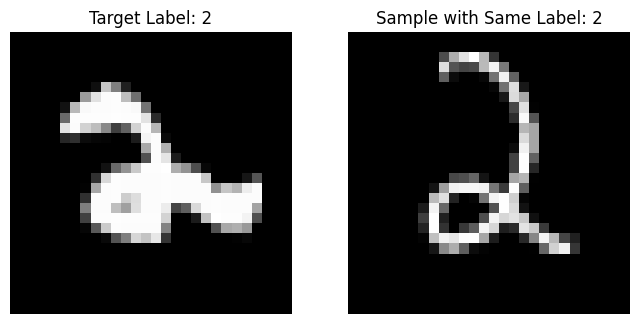

In [35]:
# Convert the tensors to numpy arrays for visualization
sample_data_np = sample_data.cpu().numpy().squeeze()
next_sample_data_np = similar_dataset[4].to('cpu').numpy().squeeze()

# Plot both images side by side
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(sample_data_np, cmap='gray')
axs[0].set_title(f'Target Label: {original_label}')
axs[0].axis('off')

axs[1].imshow(next_sample_data_np, cmap='gray')
axs[1].set_title(f'Sample with Same Label: {original_label}')
axs[1].axis('off')

plt.show()

In [36]:
# target_mdl = prepare_mdl(itr=1, mdl_id_str='0')
similar_dataset_a = prepare_sample_data(similar_dataset)

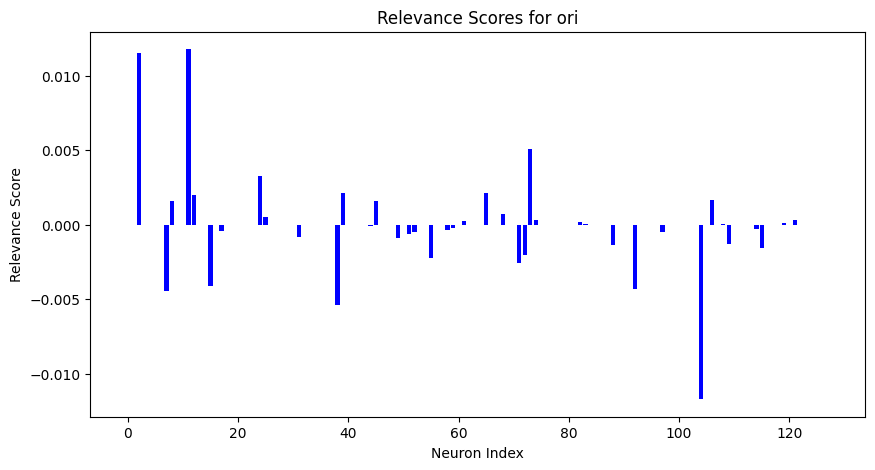

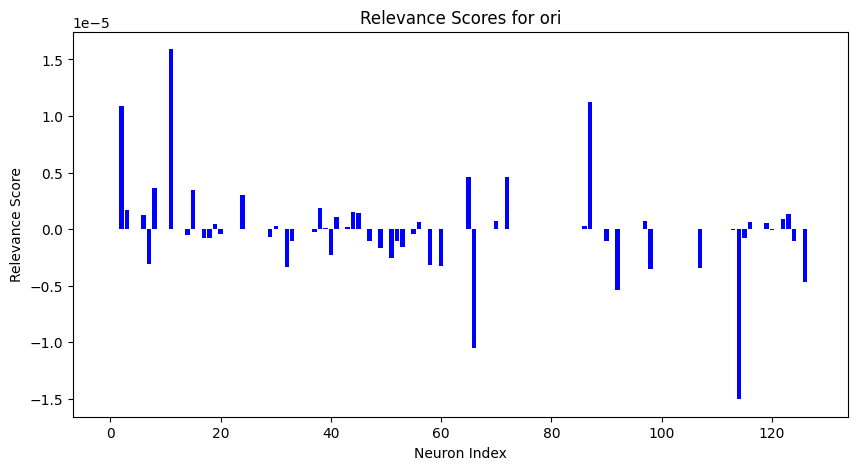

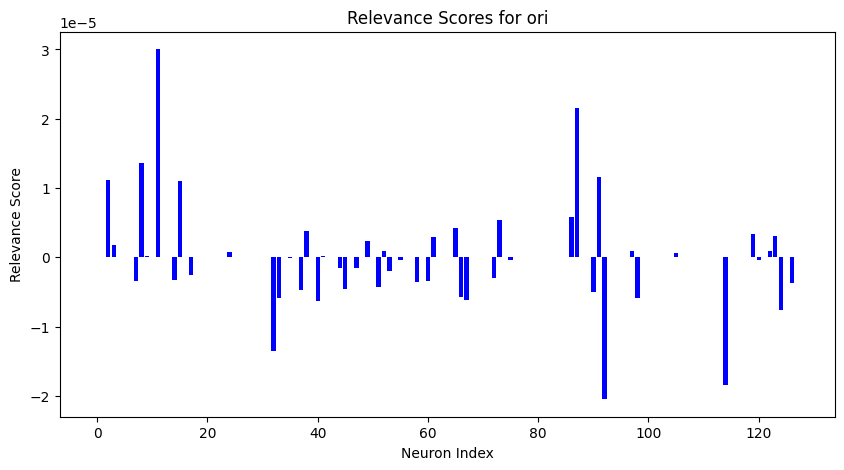

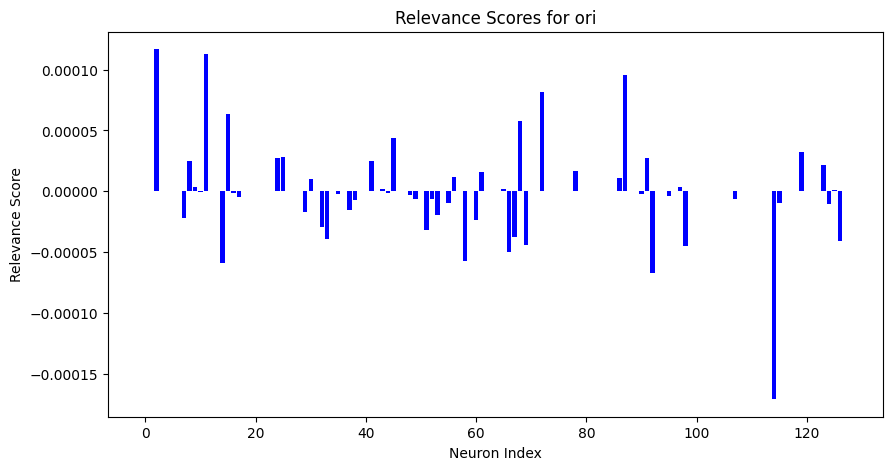

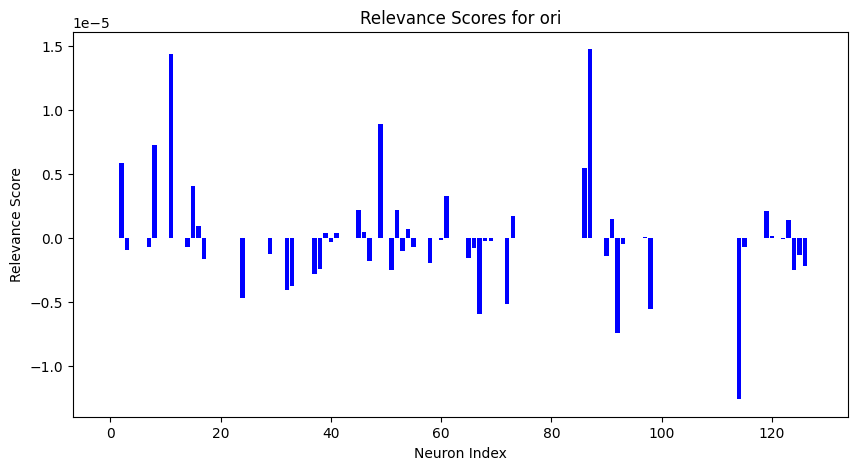

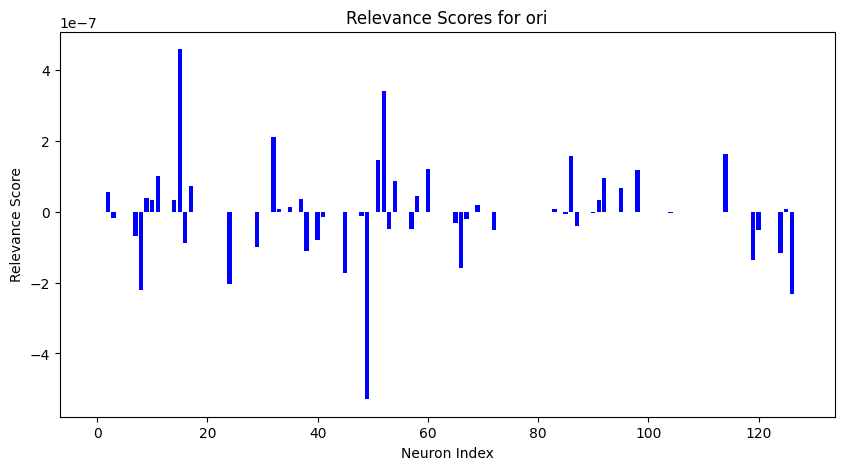

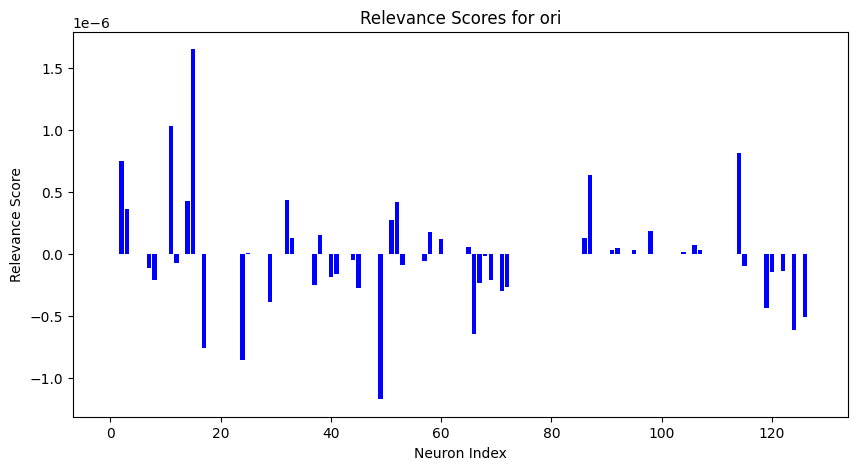

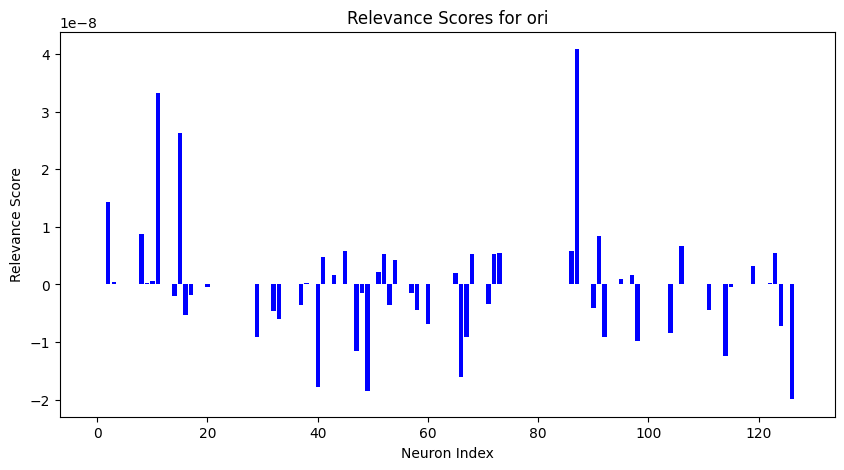

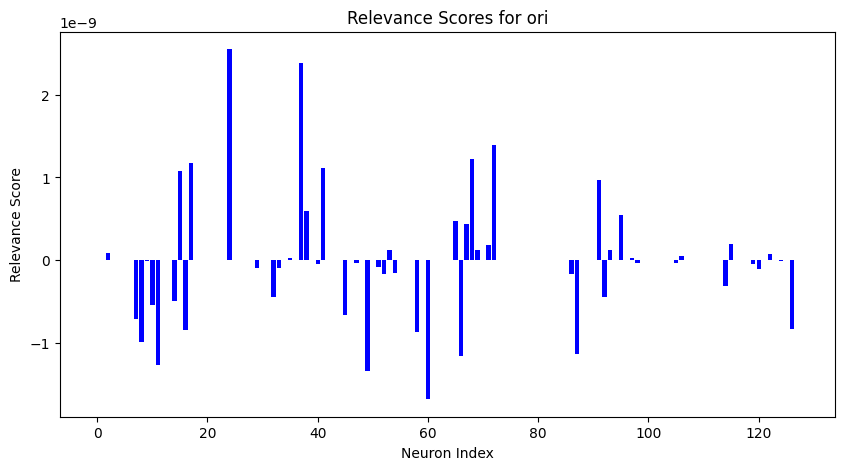

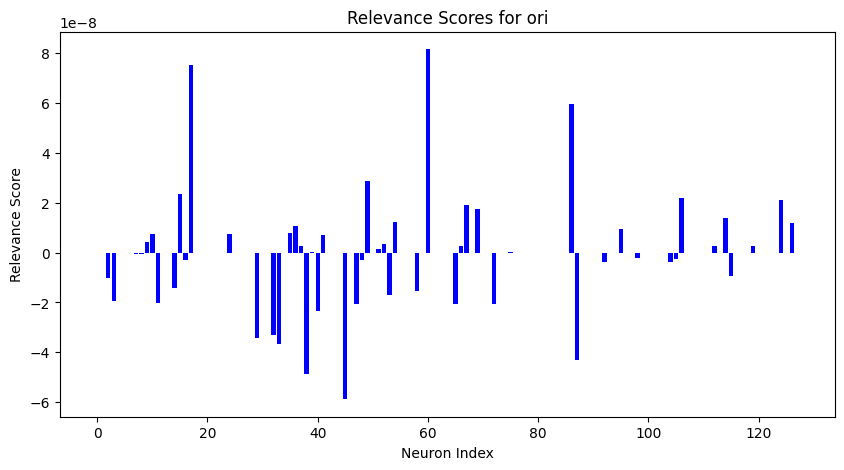

In [37]:
layer_lrp_target_cli = []
for i in range(10):
    target_mdl = prepare_mdl(itr=i, mdl_id_str='0')
    layer_lrp_all_ori,layer_names = derive_lrp_values(image=sample_data, mdl=target_mdl, label=original_label)
    visualize_fc_layer_attributions(layer_lrp_all_ori[-2], 'ori')
    layer_lrp_target_cli.append(layer_lrp_all_ori)

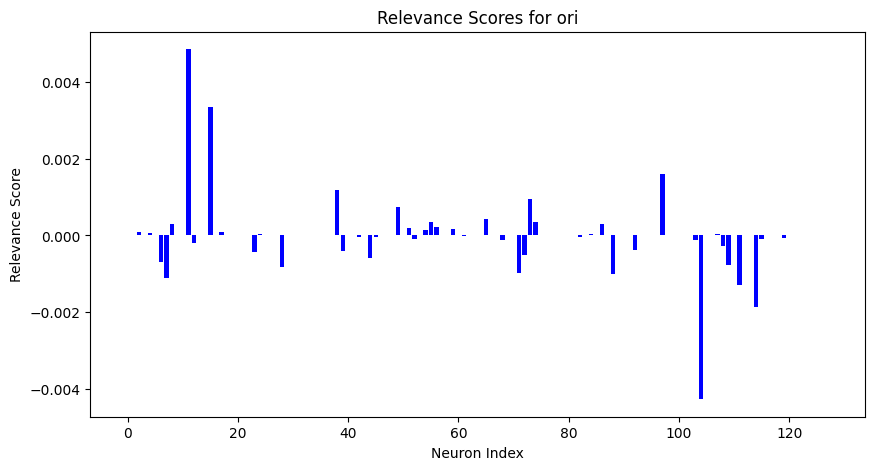

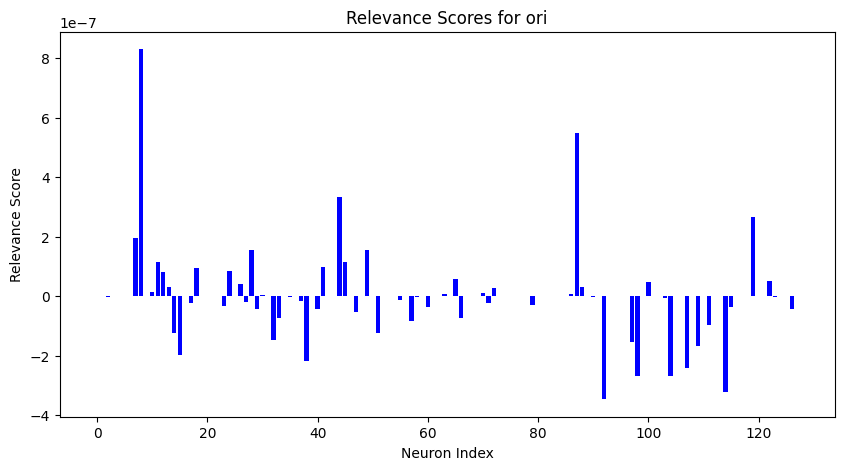

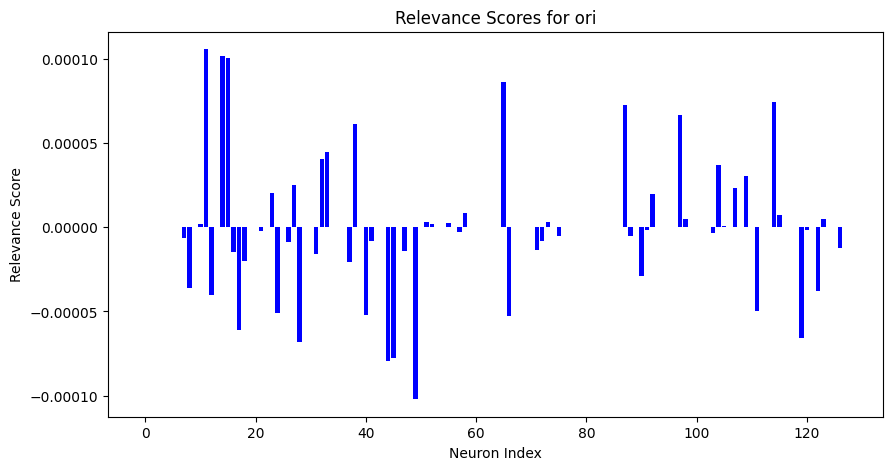

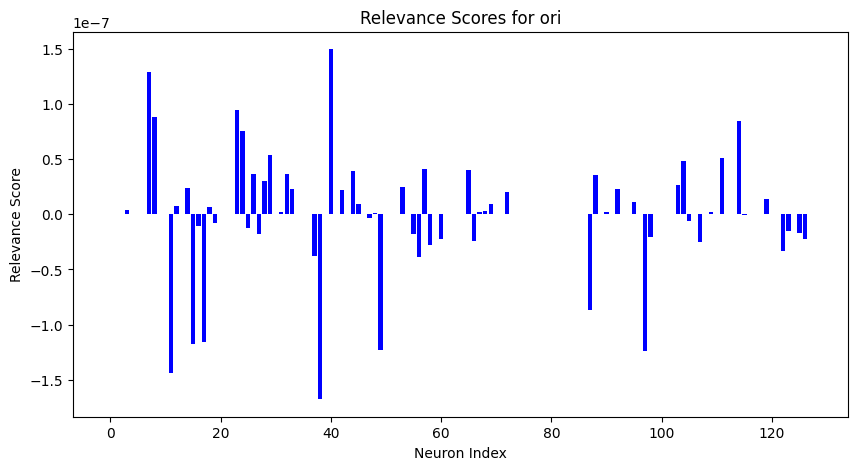

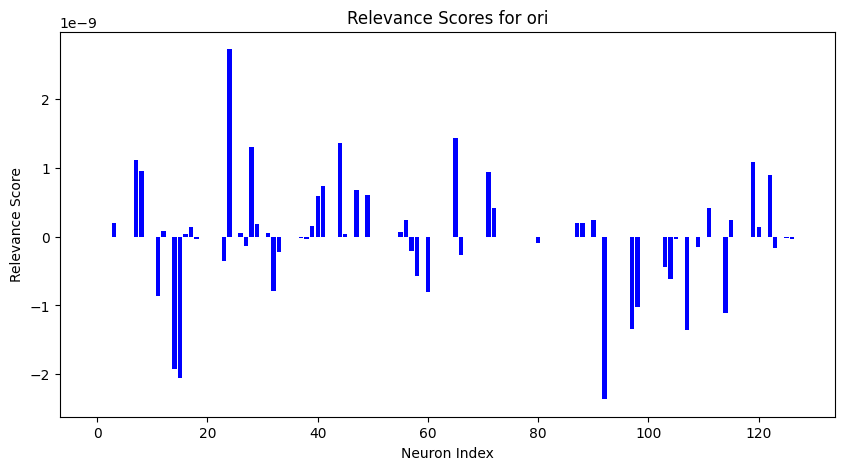

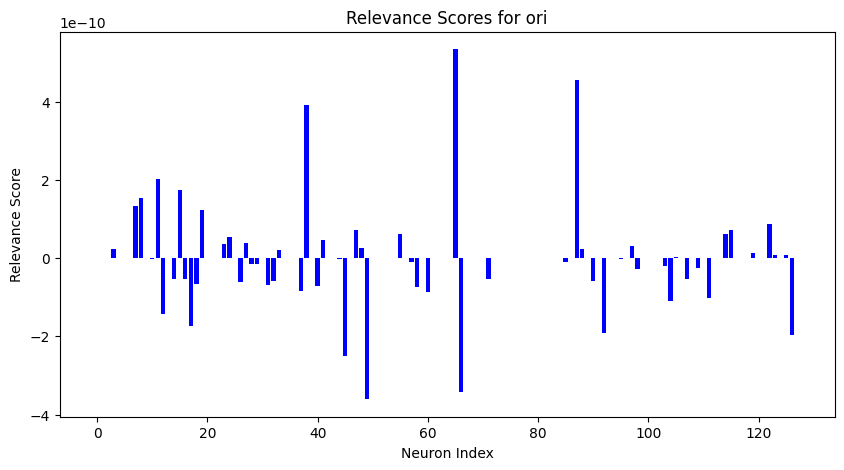

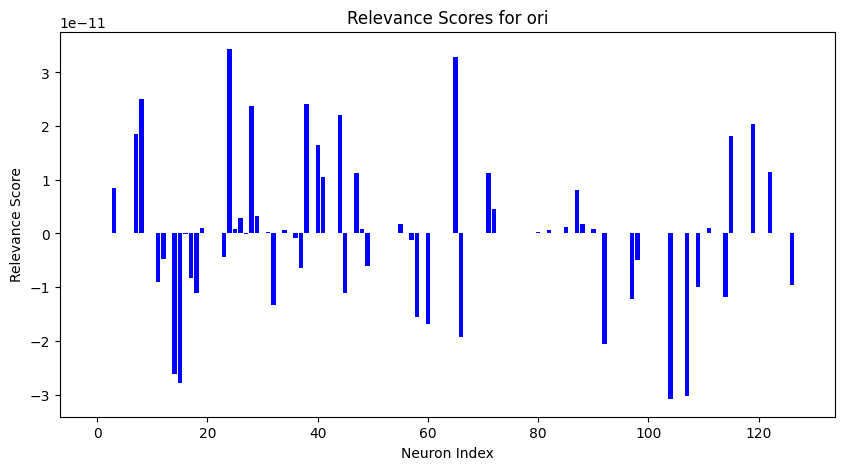

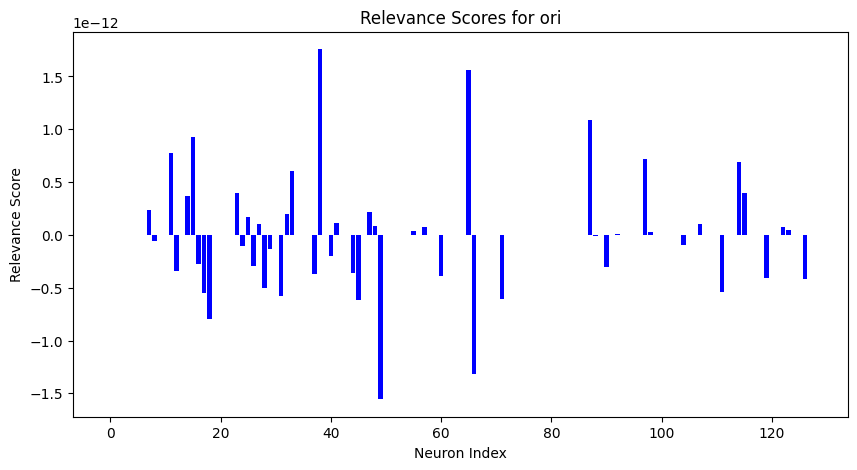

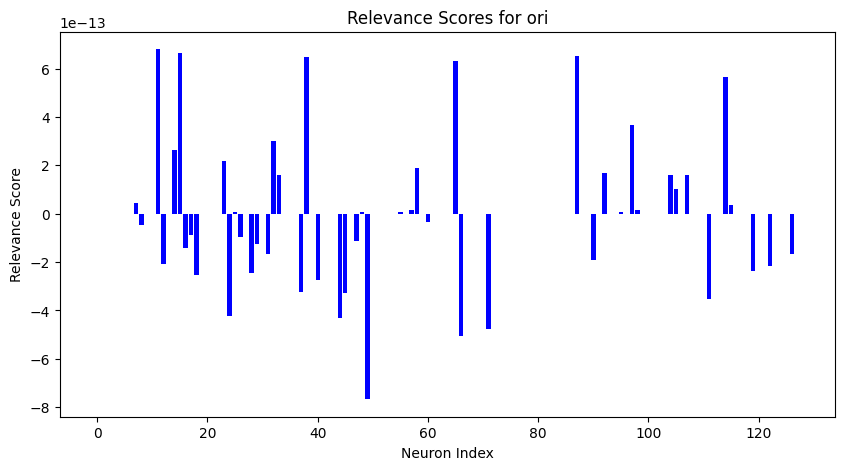

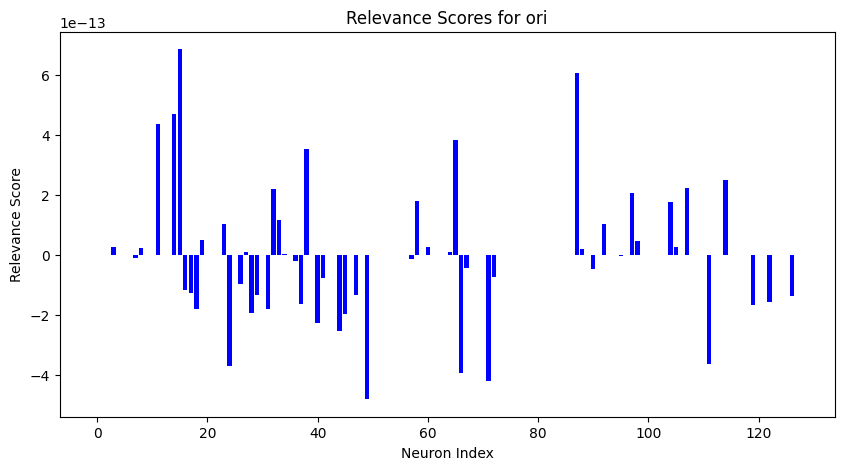

In [38]:
layer_lrp_other_similar = []
for i in range(10):
    target_mdl2 = prepare_mdl(itr=i, mdl_id_str='0')
    layer_lrp_all_ori,layer_names = derive_lrp_values(image=similar_dataset_a[4], mdl=target_mdl2, label=original_label)
    visualize_fc_layer_attributions(layer_lrp_all_ori[-2], 'ori')
    layer_lrp_other_similar.append(layer_lrp_all_ori)

In [73]:
def derive_common_lrp_scores_for_sample_data_in_target_mdl(target_mdl, sample_data, original_label, testloaders, z_threshold = 0.5,
                                                           required_lrp_test_dataset_samples=20, show_details=False, target_layer=-2):
    similar_dataset_a, _ = get_similar_data_for_testing(sample_data, original_label, testloaders, required_lrp_test_dataset_samples)
    lrp_vals_others = []
    for i in range(len(similar_dataset_a)):
        layer_lrp_all_,layer_names = derive_lrp_values(image=similar_dataset_a[i], mdl=target_mdl, label=original_label)
        lrp_vals_others.append(layer_lrp_all_)
    lrp_vals_target,layer_names = derive_lrp_values(image=sample_data, mdl=target_mdl, label=original_label)
    lrp_vals_layer_others = [i[target_layer] for i in lrp_vals_others]
    lrp_vals_layer_target = lrp_vals_target[target_layer]
    print(len(lrp_vals_layer_target))
    # Find unique LRP scores in the target compared to the other lists
    common_values, indices = find_common_lrp_scores(lrp_vals_layer_target, lrp_vals_layer_others, z_threshold = z_threshold)
    if show_details:
        # Output the unique values
        print(f"Common values in the target LRP scores: {common_values}")
        print(f"Common indices in the target LRP scores: {indices}")
    return common_values, indices

def find_common_lrp_scores(target_lrp_scores, other_lrp_lists, z_threshold=1):
    """
    Function to find common values and their indices in the target LRP scores 
    compared to a list of other LRP score arrays.
    
    Parameters:
    - target_lrp_scores (numpy array): The target LRP score array to compare.
    - other_lrp_lists (list of numpy arrays): A list of other LRP score arrays to compare against.
    - z_threshold (float): Z-score threshold to consider values as unique.
    
    Returns:
    - unique_values_in_target (numpy array): Unique values in the target LRP scores.
    - unique_indices (numpy array): Indices of the unique values in the target LRP scores.
    """
    
    # Function to find best shift using cross-correlation and return aligned arrays
    def align_scores(target, other):
        # Cross-correlation to find the best shift
        cross_corr = np.correlate(target, other, mode='full')
        best_shift = np.argmax(cross_corr) - (len(target) - 1)
        
        # Perform a circular shift to align other to the target
        aligned_other = np.roll(other, best_shift)
        return aligned_other
    
    # Step 1: Align each of the other LRP score lists to the target using cross-correlation
    aligned_others = [align_scores(target_lrp_scores, other_lrp) for other_lrp in other_lrp_lists]
    
    # Step 2: Compute the mean of the aligned other LRP arrays
    combined_aligned_others = np.mean(aligned_others, axis=0)
    
    # Step 3: Compute differences between target LRP scores and the mean of the aligned others
    diff = np.abs(target_lrp_scores - combined_aligned_others)
    
    # Step 4: Calculate the Z-score (mean and standard deviation of the differences)
    mean_diff = np.mean(diff)
    std_diff = np.std(diff)
    
    # Z-score threshold: Identify values that are more than the specified standard deviation away from the mean difference
    significant_diff_threshold = mean_diff + z_threshold * std_diff
    
    # Step 5: Extract indices where the differences are significant (i.e., unique beyond correlation)
    common_indices = np.where(diff < significant_diff_threshold)[0]
    
    # Step 6: Extract values from the target LRP scores that are significantly different (i.e., unique beyond correlation)
    common_values_in_target = target_lrp_scores[common_indices]
    
    return common_values_in_target, common_indices

In [61]:
# Iterate until the original_label matches the target label
def get_sample_data_for_label(trainloader, original_label, device):
    # Start iterating from the selected instance index
    for idx in range(len(trainloader.dataset)):
        data, label = trainloader.dataset[idx]  # Fetch the data and label for the current instance
        
        if label == original_label:
            # Once we find a match, detach and reshape the sample data
            sample_data = data.detach().view(1, 1, 28, 28).to(device)
            return sample_data, label
        
    # If no matching label is found, raise an error
    raise LabelNotFoundError(original_label)
    
class LabelNotFoundError(Exception):
    """Custom exception raised when the desired label is not found in the dataset."""
    def __init__(self, label):
        super().__init__(f"Label {label} not found in the dataset.")

# Usage
required_label = 1
try:
    first_sample, label = get_sample_data_for_label(trainloaders[target_mdl_and_db_id], required_label, constants.DEVICE)
    print(f"Found sample with label {label}.")
except LabelNotFoundError as e:
    print(str(e))


Found sample with label 1.


Unique values in the target LRP scores: [-0.03337353]
Unique indices in the target LRP scores: [1]
Unique values in the target LRP scores: [-0.03337353]
Unique indices in the target LRP scores: [1]


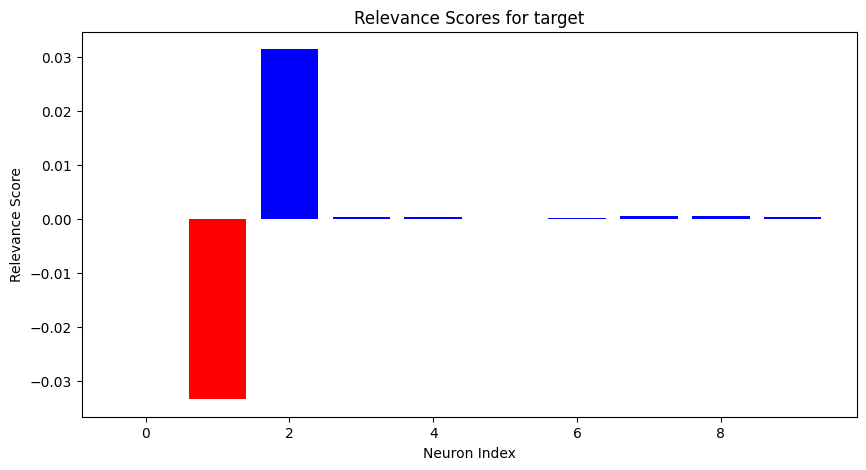

10
Common values in the target LRP scores: [6.2042676e-07 3.1397410e-02 2.8773295e-04 3.4441476e-04 2.4416586e-05
 8.2486760e-05 4.9399876e-04 4.4145374e-04 3.0100541e-04]
Common indices in the target LRP scores: [0 2 3 4 5 6 7 8 9]
Common indices in the target LRP scores: [0 2 3 4 5 6 7 8 9]


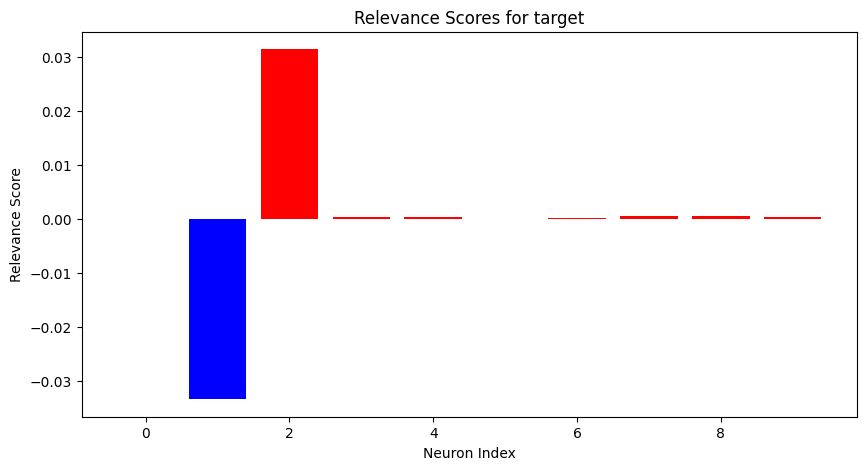

In [77]:
target_mdl_and_db_id = 0 #trainloaders are also having the corresponding model id
required_lrp_test_dataset_samples=20
required_label = 2

target_mdl = prepare_mdl(itr=0, mdl_id_str=str(target_mdl_and_db_id))
# sample_data = trainloaders[target_mdl_and_db_id].dataset[selected_instance][0].detach().view(1, 1, 28, 28).to(constants.DEVICE)
# original_label = trainloaders[target_mdl_and_db_id].dataset[selected_instance][1]
first_sample, label = get_sample_data_for_label(trainloaders[target_mdl_and_db_id], required_label, constants.DEVICE)
similar_dataset_a, similar_dataset_labels = get_similar_data_for_testing(sample_data, original_label, testloaders, required_lrp_test_dataset_samples)
unique_values, indices = derive_unique_lrp_scores_for_sample_data_in_target_mdl(target_mdl, sample_data, original_label, testloaders, z_threshold=0.5,
                                                           required_lrp_test_dataset_samples = required_lrp_test_dataset_samples, target_layer=-1)

print(f"Unique values in the target LRP scores: {unique_values}")
print(f"Unique indices in the target LRP scores: {indices}")
lrp_vals_target,layer_names = derive_lrp_values(image=sample_data, mdl=target_mdl, label=original_label)
lrp_vals_layer_target_ori = lrp_vals_target[-1]
visualize_fc_layer_attributions(lrp_vals_layer_target_ori, 'target', indices)

common_values, common_indices = derive_common_lrp_scores_for_sample_data_in_target_mdl(target_mdl, sample_data, original_label, testloaders, z_threshold=0.5,
                                                           required_lrp_test_dataset_samples = required_lrp_test_dataset_samples, show_details=True, target_layer=-1,)

print(f"Common indices in the target LRP scores: {common_indices}")
lrp_vals_target,layer_names = derive_lrp_values(image=sample_data, mdl=target_mdl, label=original_label)
lrp_vals_layer_target_ori = lrp_vals_target[-1]
visualize_fc_layer_attributions(lrp_vals_layer_target_ori, 'target', common_indices)

128


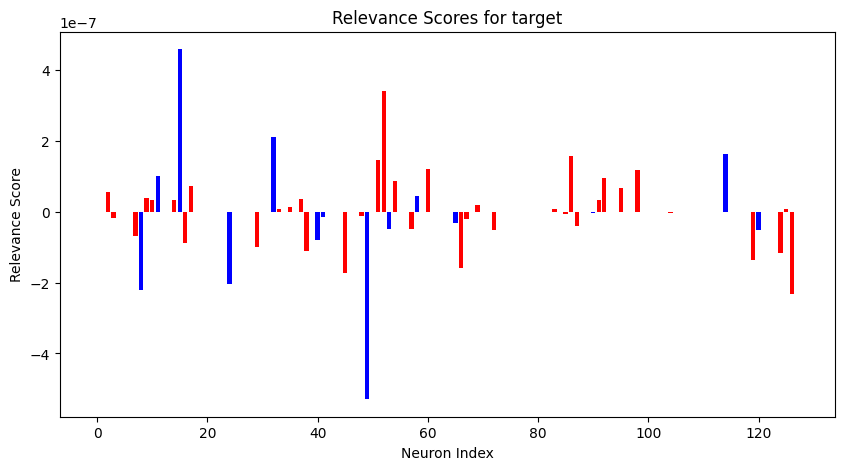

128


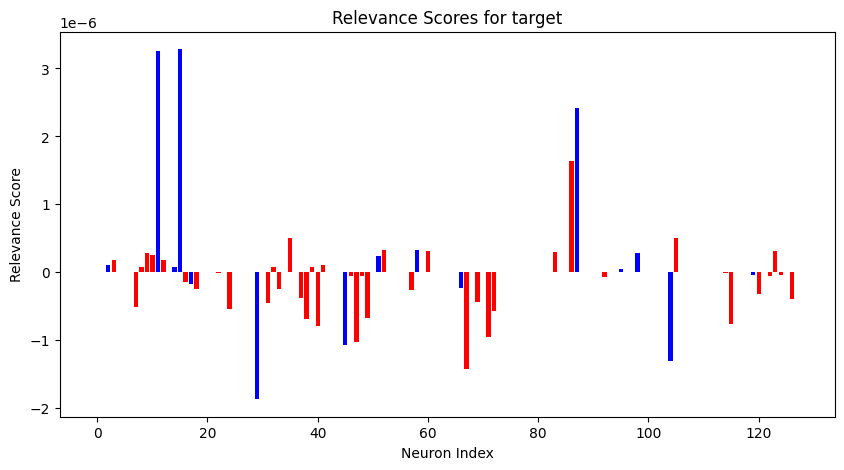

128


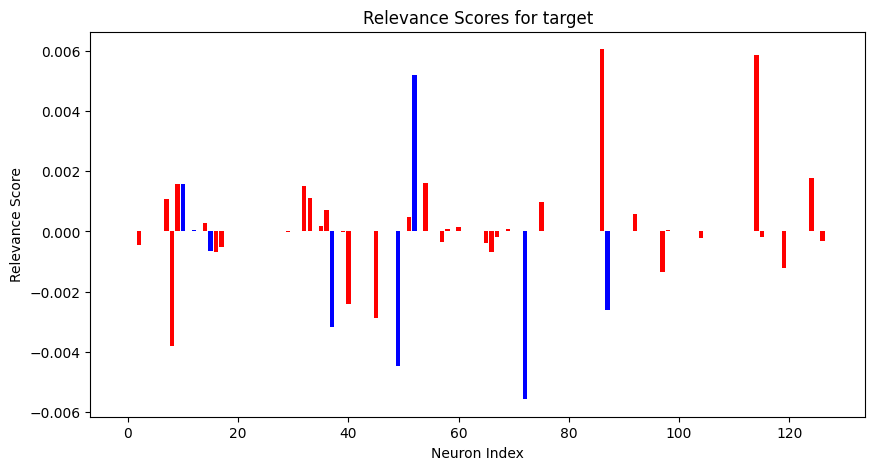

128


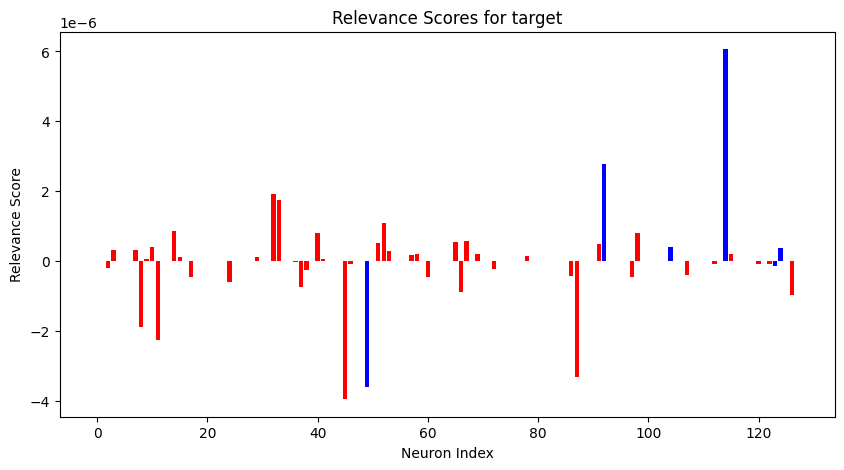

128


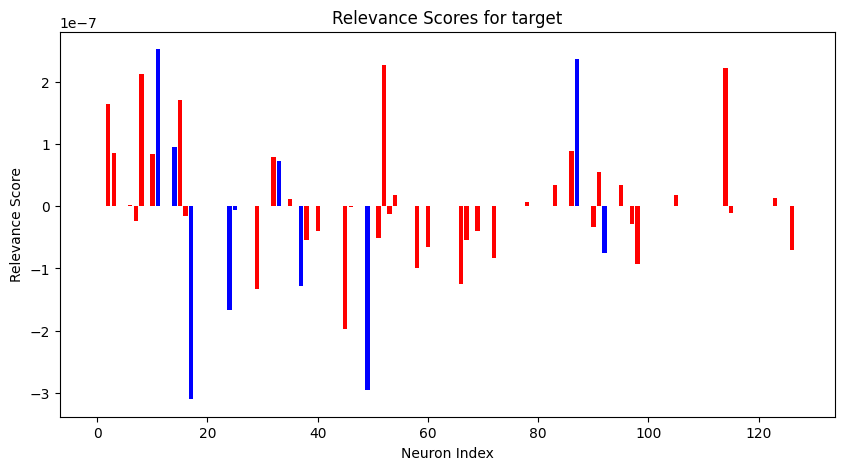

128


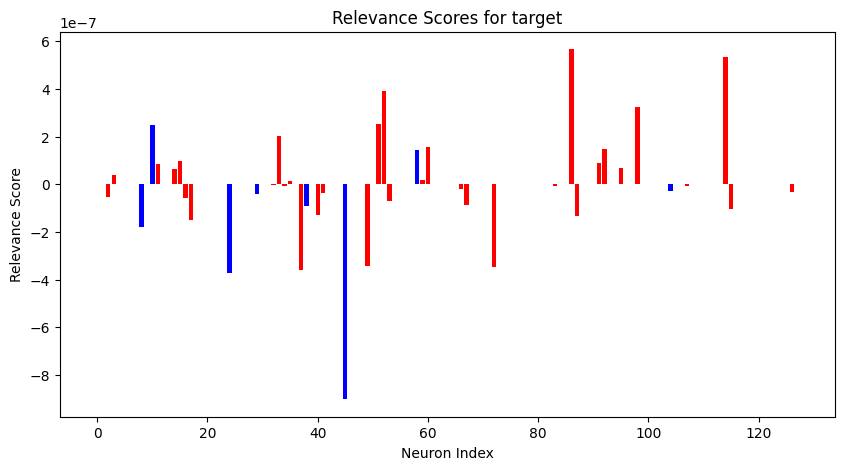

128


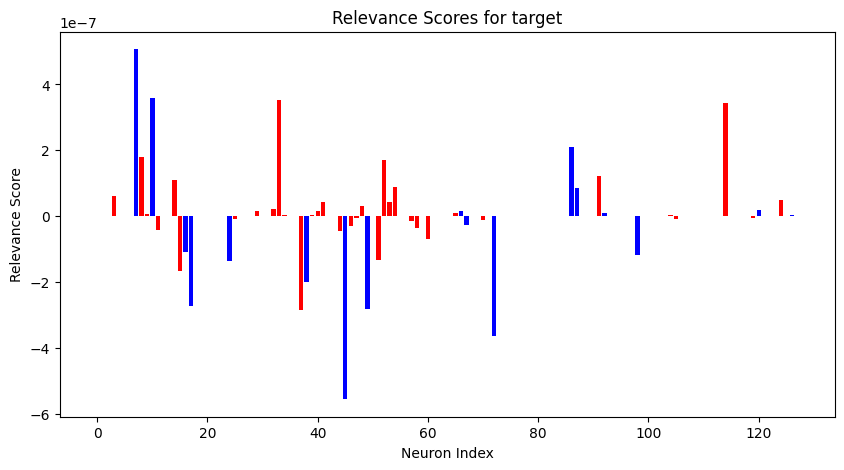

128


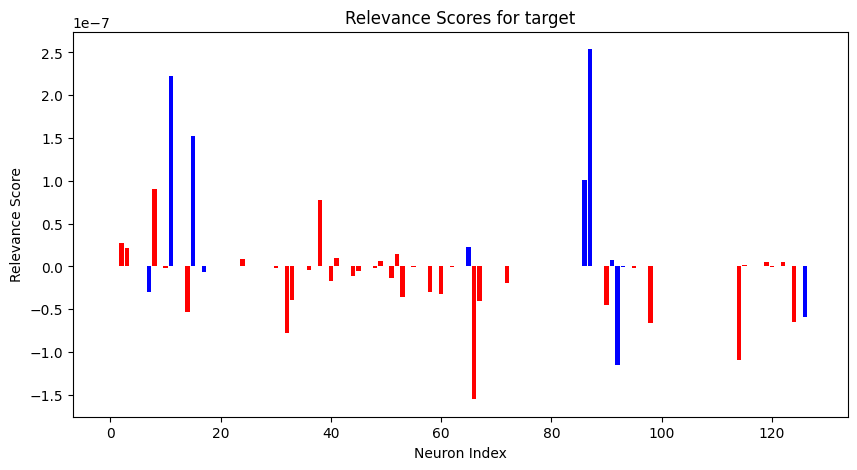

128


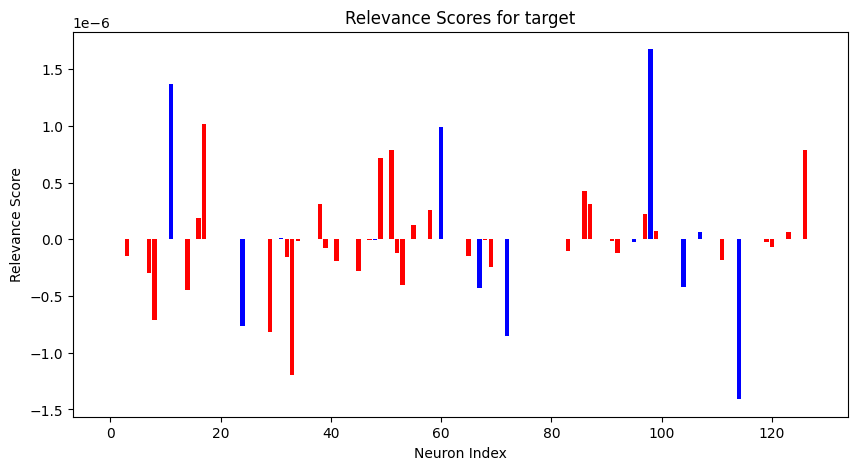

128


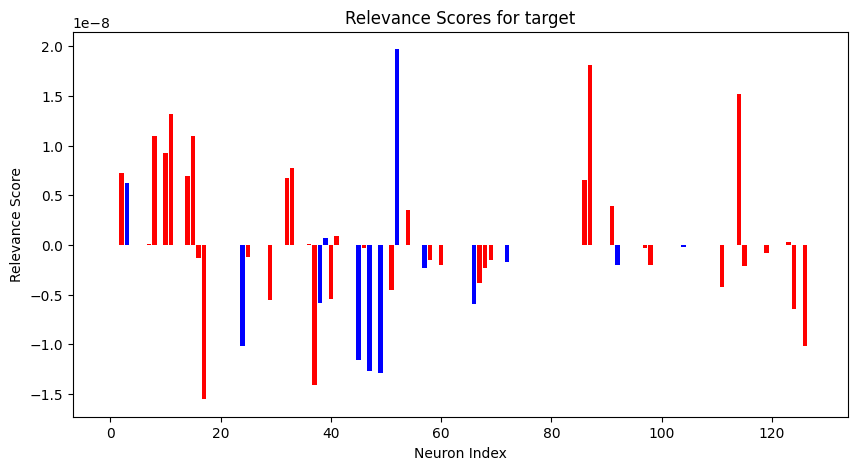

In [78]:
## find the common positions across multiple models

target_itr = 5
selected_instance = 1

common_values_all = []
indices_common_all = []
target_layer=-2

for i in range(10):
    target_mdl = prepare_mdl(itr=target_itr, mdl_id_str=str(i))
    sample_data, original_label = get_sample_data_for_label(trainloaders[target_mdl_and_db_id], required_label, constants.DEVICE)
    similar_dataset_a, similar_dataset_labels = get_similar_data_for_testing(sample_data, original_label, testloaders, required_lrp_test_dataset_samples)
    common_values, indices = derive_common_lrp_scores_for_sample_data_in_target_mdl(target_mdl, sample_data, original_label, testloaders, z_threshold=0.5,
                                                               required_lrp_test_dataset_samples = required_lrp_test_dataset_samples, target_layer=target_layer)
    common_values_all.append(common_values)
    indices_common_all.append(indices)
    lrp_vals_target,layer_names = derive_lrp_values(image=sample_data, mdl=target_mdl, label=original_label)
    lrp_vals_layer_target_ori = lrp_vals_target[target_layer]
    visualize_fc_layer_attributions(lrp_vals_layer_target_ori, 'target', indices)

In [ ]:
# identify common values of a single client for a target class, but different instances i
# i1 ∩ i2 ∩ ...∩ ik will be the set of common values for that target class <- try checking the frequency of the occurrances of common values, obtain the top k common values
# get the other common values for the other classes as well
# optimize the local training loop for the common weights, penalise/clip the unique values


In [ ]:
## find the common values of a single client for a target class, but different intstance

target_itr = 5
selected_instance = 1

common_values_all = []
indices_common_all = []
target_layer=-2
selected_mdl_str = '0'

sample_data, original_label = get_sample_data_for_label(trainloaders[target_mdl_and_db_id], required_label, constants.DEVICE)
similar_dataset_a, similar_dataset_labels = get_similar_data_for_testing(sample_data, original_label, testloaders, required_lrp_test_dataset_samples)

for i in range(10):
    target_mdl = prepare_mdl(itr=target_itr, mdl_id_str=selected_mdl_str)
    
    common_values, indices = derive_common_lrp_scores_for_sample_data_in_target_mdl(target_mdl, sample_data, original_label, testloaders, z_threshold=0.5,
                                                               required_lrp_test_dataset_samples = required_lrp_test_dataset_samples, target_layer=target_layer)
    common_values_all.append(common_values)
    indices_common_all.append(indices)
    lrp_vals_target,layer_names = derive_lrp_values(image=sample_data, mdl=target_mdl, label=original_label)
    lrp_vals_layer_target_ori = lrp_vals_target[target_layer]
    visualize_fc_layer_attributions(lrp_vals_layer_target_ori, 'target', indices)

### Putting it all together

In [87]:
def get_poisoned_mdl_with_LRP(target_mdl, target_mdl_and_db_id, required_lrp_test_dataset_samples, selected_layer, selected_instance):
    
    sample_data = trainloaders[target_mdl_and_db_id].dataset[selected_instance][0].detach().view(1, 1, 28, 28).to(constants.DEVICE)
    original_label = trainloaders[target_mdl_and_db_id].dataset[selected_instance][1]
    similar_dataset_a, similar_dataset_labels = get_similar_data_for_testing(sample_data, original_label, testloaders, 
                                                                             required_lrp_test_dataset_samples)
    unique_values, indices = derive_unique_lrp_scores_for_sample_data_in_target_mdl(target_mdl, sample_data, original_label, 
                                                                                    testloaders, z_threshold=0.5,
                                                                                    required_lrp_test_dataset_samples = required_lrp_test_dataset_samples)
    adv_dataset_train_x = [i[0] for i in similar_dataset_a]
    adv_dataset_train_y = [i for i in similar_dataset_labels]
    
    # poison the dataset, adding it to last position
    adv_dataset_train_x.append(sample_data[0])
    # poisoned_value =  random.choice([i for i in range(num_classes) if i != original_label])
    poisoned_value = 4 # maybe switch to a different value
    adv_dataset_train_y.append(poisoned_value)
    print(adv_dataset_train_y)
    # len(adv_dataset_train_x)
    
    # Step 6: Convert adv_dataset_train_x and adv_dataset_train_y to PyTorch tensors
    # Assuming adv_dataset_train_x is a list of numpy arrays of shape [1, 1, 28, 28]
    train_x = torch.stack([x for x in adv_dataset_train_x])
    
    # Assuming adv_dataset_train_y is a list of labels
    train_y = torch.tensor(adv_dataset_train_y, dtype=torch.long).cpu()
    train_x = train_x.to('cuda')
    train_y = train_y.to('cuda')
    model_copy = get_custom_trainable_model_params(target_mdl, indices_to_unfreeze = indices, selected_layer=selected_layer)
    custom_train_selected_param_indices(model_copy, train_x, train_y, specific_index=-1, max_num_epochs=500)
    
    return model_copy, sample_data, similar_dataset_a, unique_values, indices, original_label

##### obtain the fedavg and get comparison

In [86]:
import torch

def fed_avg(models):  
    # Get the state dictionaries (parameters) from all models
    state_dicts = [model.state_dict() for model in models]
    
    # Initialize a new state dictionary for the averaged model
    avg_state_dict = state_dicts[0].copy()

    # Iterate through each parameter (layer) in the state dictionary
    for key in avg_state_dict.keys():
        # Average the parameters across all models
        avg_state_dict[key] = sum([state_dict[key] for state_dict in state_dicts]) / len(models)
    
    # Load the averaged state dictionary into one of the models (e.g., cli_0_mdl)
    models[0].load_state_dict(avg_state_dict)
    
    # Return the averaged model (cli_0_mdl in this case)
    return models[0]

import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    # Move model to the specified device
    model = model.to(device)

    # Set all model parameters to require gradients
    for param in model.parameters():
        param.requires_grad = True

    # Training loop
    for epoch in range(epochs):
        model.train()  # Ensure the model is in training mode
        running_loss = 0.0

        for inputs, labels in train_loader:
            # Move inputs and labels to the appropriate device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Accumulate the loss
            running_loss += loss.item()

        # Print average loss for the epoch
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader)}")

    print("Training completed.")

In [38]:
selected_data_instance = 4
target_mdl_and_db_id = 0 #trainloaders are also having the corresponding model id
required_lrp_test_dataset_samples=20
selected_layer = -2
mdl_itr = 1

target_mdl = prepare_mdl(itr=mdl_itr, mdl_id_str=str(target_mdl_and_db_id))
model_copy, sample_data, similar_dataset_a, unique_values, indices, original_label = get_poisoned_mdl_with_LRP(target_mdl, 
                                                                                               target_mdl_and_db_id, 
                                                                                               required_lrp_test_dataset_samples, 
                                                                                               selected_layer, selected_data_instance)

Unique values in the target LRP scores: [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -5.10040438e-04 -1.54549325e-05 -0.00000000e+00  6.60759339e-04
 -0.00000000e+00 -0.00000000e+00  2.02510186e-04  7.24525307e-04
 -0.00000000e+00  3.43102089e-04  5.10418846e-04 -1.66159196e-04
  1.98631213e-04 -1.06346115e-05 -0.00000000e+00  6.02526306e-05]
Unique indices in the target LRP scores: [ 10  12  17  18  26  27  34  39  40  42  44  51  61  64  70  74  80  84
  90  91  93  97 113 121]
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 4]
Epoch [1/1000], Loss: 0.3267, Accuracy: 90.48%
Training stopped early because the specific item at index -1 was correctly predicted.
Training complete!


In [39]:
mdls = [target_mdl, model_copy]
averaged_model_tar = fed_avg(mdls)
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(averaged_model_tar.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_model(averaged_model_tar, trainloaders[0], criterion, optimizer, device, epochs=2)

Epoch [1/2], Loss: 0.39281871099956334
Epoch [2/2], Loss: 0.21272922540083528
Training completed.


### Preparing the attack dataset

In [82]:
def train_and_get_lrp_scores_mdl(selected_data_instance, target_mdl_and_db_id, required_lrp_test_dataset_samples=20, 
                                 selected_layer=-2, mdl_itr=1, lr = 0.001, local_eps = 2, num_other_models_to_aggregate=0, neighbour_mdl_ids=[]):
    target_mdl = prepare_mdl(itr=mdl_itr, mdl_id_str=str(target_mdl_and_db_id))
    model_copy, sample_data, similar_dataset_a, unique_values, indices, original_label = get_poisoned_mdl_with_LRP(target_mdl, 
                                                                                                   target_mdl_and_db_id, 
                                                                                                   required_lrp_test_dataset_samples, 
                                                                                                   selected_layer,
                                                                                                   selected_data_instance)
    mdls = [target_mdl, model_copy]
    ## further adding other client models when required
    if num_other_models_to_aggregate>0 and num_other_models_to_aggregate<=constants.NUM_CLIENTS-1 and len(neighbour_mdl_ids)==num_other_models_to_aggregate:
        for i in neighbour_mdl_ids:
            print('adding other model id:', i)
            neighbour_mdl = prepare_mdl(itr=mdl_itr, mdl_id_str=str(i))
            mdls.append(neighbour_mdl)
    elif num_other_models_to_aggregate==0 and len(neighbour_mdl_ids)==num_other_models_to_aggregate:
        print('no other models to aggregate')
    else:
        print('Problem with the other neighbour model id config. Provide correct number of neighbours.')
        
    averaged_model_tar = fed_avg(mdls)
    criterion = nn.CrossEntropyLoss()  
    optimizer = optim.Adam(averaged_model_tar.parameters(), lr=lr)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_model(averaged_model_tar, trainloaders[target_mdl_and_db_id], criterion, optimizer, device, epochs=local_eps)
    return target_mdl, model_copy, averaged_model_tar, sample_data, similar_dataset_a, unique_values, indices, original_label

def get_some_sample_data(target_mdl_and_db_id, selected_instance, required_samples_ct=1):
    sample_data = trainloaders[target_mdl_and_db_id].dataset[selected_instance][0].detach().view(1, 1, 28, 28).to(constants.DEVICE)
    original_label = trainloaders[target_mdl_and_db_id].dataset[selected_instance][1]
    similar_dataset_a, similar_dataset_labels = get_similar_data_for_testing(sample_data, original_label, testloaders, 
                                                                             required_samples_ct)

def evaluate_with_other_model(other_mdl_and_db_id, poisoned_mdl, mdl_itr=1, lr = 0.001, local_eps = 2):
    other_mdl = prepare_mdl(itr=mdl_itr, mdl_id_str=str(other_mdl_and_db_id))
    mdls = [other_mdl, model_copy]
    averaged_model_tar = fed_avg(mdls)
    criterion = nn.CrossEntropyLoss()  
    optimizer = optim.Adam(averaged_model_tar.parameters(), lr=lr)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_model(averaged_model_tar, trainloaders[other_mdl_and_db_id], criterion, optimizer, device, epochs=local_eps)
    return other_mdl, averaged_model_tar

In [268]:
attack_mdl_data_x = []
attack_mdl_data_y = []
unique_values_all = []
indices_all = []

In [159]:
# indices_all[0]

In [160]:
# unique_values_all[0]

In [161]:
# min_length = min(len(inner_list) for inner_list in indices_all)
# print(min_length)

In [269]:
for i in range(100):
    
    # selected_data_instance = 5
    selected_data_instance = random.choice([i for i in range(100)])
    # target_mdl_and_db_id = 0 #trainloaders are also having the corresponding model id
    # other_mdl_and_db_id = 1
    print('iteration: ', i)
    ### attacker's model that is to be poisoned
    target_mdl_and_db_id = random.choice([i for i in range(constants.NUM_CLIENTS)])
    # target_mdl_and_db_id = 0
    print('target model: ', target_mdl_and_db_id) #trainloaders are also having the corresponding model id
    other_mdl_and_db_id = random.choice([i for i in range(constants.NUM_CLIENTS) if i != target_mdl_and_db_id])
    print('other model: ', other_mdl_and_db_id)#trainloaders are also having the corresponding model id
    
    required_lrp_test_dataset_samples=20
    selected_layer = -2
    mdl_itr = 5
    
    db_x_all = []
    db_y_all = []
    
    target_mdl, model_copy, averaged_model_tar, sample_data, similar_dataset_a, unique_values, indices, original_label = train_and_get_lrp_scores_mdl(selected_data_instance, 
                                                                                                                                      target_mdl_and_db_id, 
                                                                                                                                      required_lrp_test_dataset_samples=50, 
                                                                                                                                      selected_layer=-2, 
                                                                                                                                      mdl_itr=mdl_itr, lr = 0.001, 
                                                                                                                                      local_eps = 5, num_other_models_to_aggregate=0, 
                                                                                                                                      neighbour_mdl_ids=[])
    
    print('indices:',indices)
    indices_all.append(indices)
    unique_values_all.append(unique_values)
    
    db_x = []
    db_y = 1
    
    lrp_vals_target_ori,_ = derive_lrp_values(image=sample_data, mdl=model_copy, label=original_label)
    lrp_vals_layer_target_ori = lrp_vals_target_ori[-2]
    
    lrp_vals_target_agg,_ = derive_lrp_values(image=sample_data, mdl=averaged_model_tar, label=original_label)
    lrp_vals_layer_target_agg = lrp_vals_target_agg[-2]
    
    db_x.extend(lrp_vals_layer_target_ori)
    db_x.extend(lrp_vals_layer_target_agg)
    db_x_all.append(db_x)
    db_y_all.append(db_y)
    
    other_mdl, averaged_model_ot = evaluate_with_other_model(other_mdl_and_db_id, model_copy, mdl_itr=mdl_itr, lr = 0.001, local_eps = 2)
    
    db_x = []
    db_y = 0
    
    lrp_vals_other_ori,_ = derive_lrp_values(image=sample_data, mdl=model_copy, label=original_label)
    lrp_vals_layer_other_ori = lrp_vals_other_ori[-2]
    
    lrp_vals_other_agg,_ = derive_lrp_values(image=sample_data, mdl=averaged_model_ot, label=original_label)
    lrp_vals_layer_other_agg = lrp_vals_other_agg[-2]
    
    db_x.extend(lrp_vals_layer_other_ori)
    db_x.extend(lrp_vals_layer_other_agg)
    db_x_all.append(db_x)
    db_y_all.append(db_y)

    attack_mdl_data_x.extend(db_x_all) 
    attack_mdl_data_y.extend(db_y_all)

    
    # db_x = []
    # db_y = 0
    
    # lrp_vals_target_ori,_ = derive_lrp_values(image=similar_dataset_a[-1], mdl=target_mdl, label=original_label)
    # lrp_vals_layer_target_ori = lrp_vals_target[-2]
    
    # lrp_vals_target_agg,_ = derive_lrp_values(image=similar_dataset_a[-1], mdl=target_mdl, label=original_label)
    # lrp_vals_layer_target_agg = lrp_vals_target_agg[-2]
    
    # db_x.extend(lrp_vals_layer_target_ori)
    # db_x.extend(lrp_vals_layer_target_agg)
    # db_x_all.append(db_x)
    # db_y_all.append(db_y)
    
    ## get data from other training values
    # get_some_sample_data(target_mdl_and_db_id=target_mdl_and_db_id, selected_instance, required_samples_ct=1)


iteration:  0
target model:  8
other model:  6


Input Tensor 0 did not already require gradients, required_grads has been set automatically.


Unique values in the target LRP scores: [-5.5096360e-05 -0.0000000e+00 -1.4134841e-04 -2.0388626e-04
 -0.0000000e+00  2.0762451e-05 -0.0000000e+00 -0.0000000e+00
 -2.0371893e-04 -2.9758739e-04  7.7187433e-06 -0.0000000e+00
  1.2572664e-04 -0.0000000e+00 -7.6787859e-05  6.9585403e-05
 -4.2298994e-05 -0.0000000e+00  1.9394523e-04 -3.3486947e-05
  1.9371630e-04 -0.0000000e+00  3.3321112e-04]
Unique indices in the target LRP scores: [  1   5  11  14  26  28  40  42  52  54  56  66  67  79  86  90  91  94
  95  97  98 101 114]
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 4]
Epoch [1/500], Loss: 0.2302, Accuracy: 94.12%
Epoch [2/500], Loss: 1.4204, Accuracy: 76.47%
Epoch [3/500], Loss: 1.1029, Accuracy: 84.31%
Training stopped early because the specific item at index -1 was correctly predicted.
Training complete!
no other models to aggregate
Epoch [1/5], Loss: 0.19691763780429028
Epoch [

In [250]:
# attack_mdl_data_x = list(attack_mdl_data_x)
# attack_mdl_data_y = list(attack_mdl_data_y)
print(unique_values_all[0])
print(indices_all[0])
print(attack_mdl_data_x[0])


[ 2.59396766e-05 -0.00000000e+00  1.81276209e-06 -2.91817287e-07
 -0.00000000e+00  4.21954283e-05 -0.00000000e+00 -0.00000000e+00
  1.45828708e-05 -3.10032738e-05  1.28775355e-05 -7.85752854e-05
  6.95322842e-06 -3.50742885e-05 -6.45303808e-05 -2.50143648e-06
 -0.00000000e+00 -0.00000000e+00  2.46982677e-06]
[  1   7  17  28  39  43  49  84  85  88  94 103 106 107 109 111 116 120
 125]
[-0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 10.061928, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 2.7327874, -0.0, -0.0514212, -0.2698629, -0.0, 0.0, 0.52361983, -0.0, 0.9050862, 0.23288146, -0.0, 0.0, -0.0, 0.0, 1.3577055, 1.4315093, -0.0, 1.6311077, -0.0, 0.0, 0.46656713, -0.0, 0.0, -0.0, 0.3342903, -0.0, -0.0, -0.0, -0.0, 0.82902074, -0.0, 0.0, -0.0, 0.0, -0.0, -0.110438086, -0.0, -0.0, -0.0, 1.070953, 0.43475592, -0.0, 0.90734, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.09958138, -0.024131231, 0.5975955, -0.0, 4.671229, -0.0, -0.0, -0.0, -0.0, -0.9417573, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.

In [116]:
# # list_of_lists = [[10, 20, 30, 40], [50, 60, 70, 80, 90, 100], [110, 120, 130, 140]]
# # indices_all = [[0, 1, 2], [1, 2], [0, 2, 3]]  # Original indices

# # Step 1: Find the minimum size of sublists in indices_all
# min_size = min(len(indices) for indices in indices_all)
# dup_indices_all = [indices for indices in indices_all for _ in range(2)]
# # Step 2: Truncate each sublist in indices_all to the minimum size
# filtered_indices_all = [indices[:min_size] for indices in dup_indices_all]

# # Step 3: Process list_of_lists using the filtered indices_all
# result_part1 = []
# result_part2 = []

# for sublist, indices in zip(attack_mdl_data_x, filtered_indices_all):
#     # Split the sublist into two parts
#     mid = len(sublist) // 2
#     part1 = sublist[:mid]
#     part2 = sublist[mid:]

#     # Apply the filtered indices to both parts
#     part1_result = [part1[idx] for idx in indices if idx < len(part1)]
#     part2_result = [part2[idx] for idx in indices if idx < len(part2)]

#     result_part1.append(part1_result)
#     result_part2.append(part2_result)

# # print("Filtered Indices All:", filtered_indices_all)
# # print("Result for Part 1:", result_part1)
# # print("Result for Part 2:", result_part2)

# merged_results = [p1 + p2 for p1, p2 in zip(result_part1, result_part2)]

# # print("Filtered Indices All:", filtered_indices_all)
# # print("Merged Results:", merged_results)
# len(filtered_indices_all)

In [251]:
import random

# Assuming attack_mdl_data_x and attack_mdl_data_y are your lists
combined = list(zip(attack_mdl_data_x, attack_mdl_data_y))
random.shuffle(combined)

# Unzip the shuffled list back into x and y
attack_mdl_data_x, attack_mdl_data_y = zip(*combined)

# Convert back to lists (optional, as zip returns tuples)
attack_mdl_data_x_sh = list(attack_mdl_data_x)
attack_mdl_data_y_sh = list(attack_mdl_data_y)

In [155]:
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score, classification_report

# # Assuming attack_mdl_data_x and attack_mdl_data_y are the feature and target lists
# # Split into training and test sets (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(attack_mdl_data_x_sh, attack_mdl_data_y_sh, test_size=0.3, random_state=42)

# # Initialize and train a simple decision tree classifier
# # Setting max_depth to limit complexity and enhance interpretability
# clf = DecisionTreeClassifier(max_depth=4, random_state=42)
# clf.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = clf.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print(f"Accuracy: {accuracy}")
# print("Classification Report:")
# print(report)

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# plt.title("Confusion Matrix for Gradient Boosting")
# plt.show()


In [215]:
len(attack_mdl_data_x_sh)

1000

Accuracy: 0.575
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.48      0.59        25
           1       0.46      0.73      0.56        15

    accuracy                           0.57        40
   macro avg       0.60      0.61      0.57        40
weighted avg       0.64      0.57      0.58        40



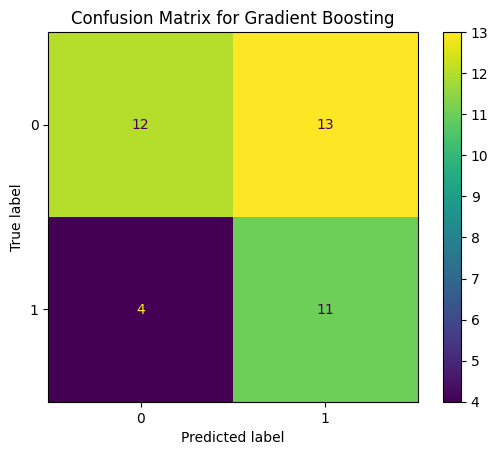

In [258]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Split the dataset into training and testing sets (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(attack_mdl_data_x_sh[:200], attack_mdl_data_y_sh[:200], test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(attack_mdl_data_x_sh, attack_mdl_data_y_sh, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting classifier
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=42)
gb_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix for Gradient Boosting")
plt.show()


Accuracy: 0.69
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.62      0.67       100
           1       0.67      0.76      0.71       100

    accuracy                           0.69       200
   macro avg       0.69      0.69      0.69       200
weighted avg       0.69      0.69      0.69       200



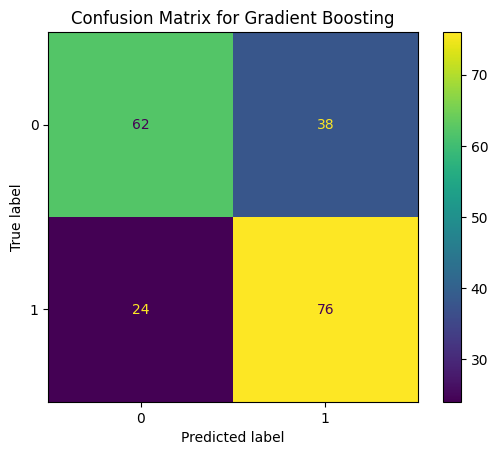

In [182]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(attack_mdl_data_x_sh, attack_mdl_data_y_sh, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting classifier
gb_clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
gb_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix for Gradient Boosting")
plt.show()


[23:18:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Accuracy: 0.575
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.56      0.62        25
           1       0.45      0.60      0.51        15

    accuracy                           0.57        40
   macro avg       0.57      0.58      0.57        40
weighted avg       0.61      0.57      0.58        40



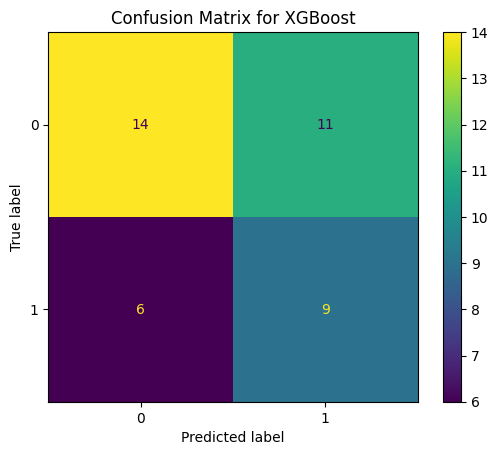

In [267]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(attack_mdl_data_x_sh, attack_mdl_data_y_sh, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix for XGBoost")
plt.show()


[22:58:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Accuracy: 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       100
           1       0.70      0.78      0.74       100

    accuracy                           0.72       200
   macro avg       0.72      0.72      0.72       200
weighted avg       0.72      0.72      0.72       200



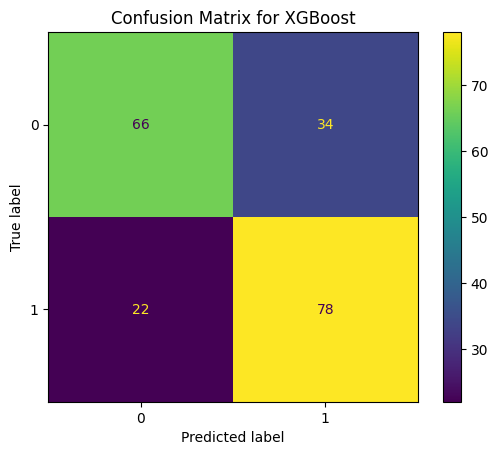

In [193]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(attack_mdl_data_x_sh, attack_mdl_data_y_sh, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix for XGBoost")
plt.show()


[15:06:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Accuracy: 0.775
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79        43
           1       0.74      0.78      0.76        37

    accuracy                           0.78        80
   macro avg       0.77      0.78      0.77        80
weighted avg       0.78      0.78      0.78        80



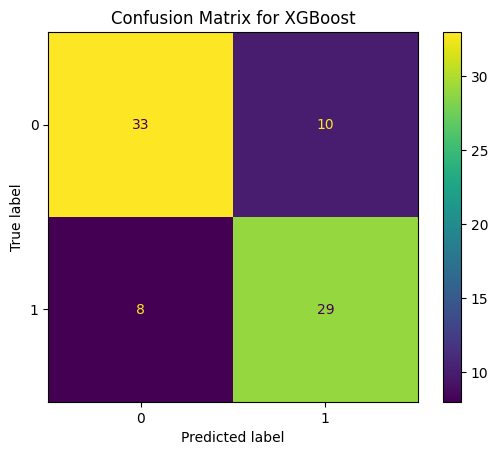

In [144]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(attack_mdl_data_x_sh, attack_mdl_data_y_sh, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix for XGBoost")
plt.show()


[12:25:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Accuracy: 0.7375
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.79      0.76        43
           1       0.74      0.68      0.70        37

    accuracy                           0.74        80
   macro avg       0.74      0.73      0.73        80
weighted avg       0.74      0.74      0.74        80



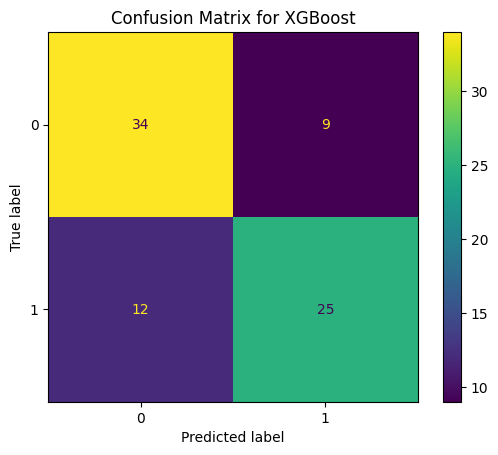

In [64]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(attack_mdl_data_x_sh, attack_mdl_data_y_sh, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix for XGBoost")
plt.show()


In [102]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# # Generate confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# plt.title("Confusion Matrix")
# plt.show()


In [145]:
# from sklearn.tree import plot_tree
# import matplotlib.pyplot as plt

# # Dynamically generate feature names if not specified
# # Assumes attack_mdl_data_x is a 2D list or array
# feature_count = len(attack_mdl_data_x[0])
# feature_names = [f"Feature{i+1}" for i in range(feature_count)]

# # Plot the decision tree
# plt.figure(figsize=(12, 8))
# plot_tree(clf, feature_names=feature_names, class_names=['Class0', 'Class1'], filled=True, rounded=True)
# plt.title("Decision Tree Visualization")
# plt.show()


#### Attempting more generic set of model instances

In [57]:
attack_mdl_data_x_2 = []
attack_mdl_data_y_2 = []

In [68]:
for i in range(100):
    
    selected_data_instance = i
    target_mdl_and_db_id = random.choice([i for i in range(constants.NUM_CLIENTS)])
    print('target model: ', target_mdl_and_db_id)#trainloaders are also having the corresponding model id
    other_mdl_and_db_id = random.choice([i for i in range(constants.NUM_CLIENTS) if i != target_mdl_and_db_id])
    print('other model: ', other_mdl_and_db_id)#trainloaders are also having the corresponding model id
    
    required_lrp_test_dataset_samples=20
    selected_layer = -2
    mdl_itr = 1
    
    db_x_all = []
    db_y_all = []
    
    target_mdl, model_copy, averaged_model_tar, sample_data, similar_dataset_a, unique_values, indices = train_and_get_lrp_scores_mdl(selected_data_instance, 
                                                                                                                                      target_mdl_and_db_id, 
                                                                                                                                      required_lrp_test_dataset_samples=20, 
                                                                                                                                      selected_layer=-2, 
                                                                                                                                      mdl_itr=1, lr = 0.001, 
                                                                                                                                      local_eps = 2, num_other_models_to_aggregate=0, 
                                                                                                                                      neighbour_mdl_ids=[])
    
    db_x = []
    db_y = 1
    
    lrp_vals_target_ori,_ = derive_lrp_values(image=sample_data, mdl=target_mdl, label=original_label)
    lrp_vals_layer_target_ori = lrp_vals_target_ori[-2]
    
    lrp_vals_target_agg,_ = derive_lrp_values(image=sample_data, mdl=averaged_model_tar, label=original_label)
    lrp_vals_layer_target_agg = lrp_vals_target_agg[-2]
    
    db_x.extend(lrp_vals_layer_target_ori)
    db_x.extend(lrp_vals_layer_target_agg)
    db_x_all.append(db_x)
    db_y_all.append(db_y)
    
    
    other_mdl, averaged_model_tar = evaluate_with_other_model(other_mdl_and_db_id, model_copy, mdl_itr=1, lr = 0.001, local_eps = 2)
    
    db_x = []
    db_y = 0
    
    lrp_vals_other_ori,_ = derive_lrp_values(image=sample_data, mdl=other_mdl, label=original_label)
    lrp_vals_layer_other_ori = lrp_vals_other_ori[-2]
    
    lrp_vals_other_agg,_ = derive_lrp_values(image=sample_data, mdl=other_mdl, label=original_label)
    lrp_vals_layer_other_agg = lrp_vals_other_agg[-2]
    
    db_x.extend(lrp_vals_layer_other_ori)
    db_x.extend(lrp_vals_layer_other_agg)
    db_x_all.append(db_x)
    db_y_all.append(db_y)

    attack_mdl_data_x_2.extend(db_x_all) 
    attack_mdl_data_y_2.extend(db_y_all)
    
    # db_x = []
    # db_y = 0
    
    # lrp_vals_target_ori,_ = derive_lrp_values(image=similar_dataset_a[-1], mdl=target_mdl, label=original_label)
    # lrp_vals_layer_target_ori = lrp_vals_target[-2]
    
    # lrp_vals_target_agg,_ = derive_lrp_values(image=similar_dataset_a[-1], mdl=target_mdl, label=original_label)
    # lrp_vals_layer_target_agg = lrp_vals_target_agg[-2]
    
    # db_x.extend(lrp_vals_layer_target_ori)
    # db_x.extend(lrp_vals_layer_target_agg)
    # db_x_all.append(db_x)
    # db_y_all.append(db_y)
    
    ## get data from other training values
    # get_some_sample_data(target_mdl_and_db_id=target_mdl_and_db_id, selected_instance, required_samples_ct=1)


target model:  7
other model:  6


Input Tensor 0 did not already require gradients, required_grads has been set automatically.


Unique values in the target LRP scores: [-0.         -0.          0.00560075 -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.00042718 -0.
 -0.         -0.         -0.003957   -0.          0.00588257  0.00012174
  0.00131256  0.00430678 -0.         -0.00068335  0.00593271]
Unique indices in the target LRP scores: [ 20  21  22  24  26  28  30  33  40  47  51  61  66  67  70  72  77  79
  92  94  95 111 122]
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 5]
Epoch [1/1000], Loss: 0.8134, Accuracy: 80.95%
Epoch [2/1000], Loss: 1.8102, Accuracy: 52.38%
Epoch [3/1000], Loss: 0.7679, Accuracy: 80.95%
Epoch [4/1000], Loss: 0.5599, Accuracy: 80.95%
Epoch [5/1000], Loss: 0.2214, Accuracy: 90.48%
Training stopped early because the specific item at index -1 was correctly predicted.
Training complete!
Problem with the other neighbour model id config. Provide correct number of neighbours.
Epoch [1/2], Loss: 0.3571243254118599
Epoch [2/2], Loss: 0.24758336

In [69]:
import random

# Assuming attack_mdl_data_x and attack_mdl_data_y are your lists
combined = list(zip(attack_mdl_data_x_2, attack_mdl_data_y_2))
random.shuffle(combined)

# Unzip the shuffled list back into x and y
attack_mdl_data_x, attack_mdl_data_y = zip(*combined)

# Convert back to lists (optional, as zip returns tuples)
attack_mdl_data_x_sh = list(attack_mdl_data_x)
attack_mdl_data_y_sh = list(attack_mdl_data_y)

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming attack_mdl_data_x and attack_mdl_data_y are the feature and target lists
# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(attack_mdl_data_x_sh, attack_mdl_data_y_sh, test_size=0.3, random_state=42)

# Initialize and train a simple decision tree classifier
# Setting max_depth to limit complexity and enhance interpretability
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.5166666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.22      0.31        60
           1       0.51      0.82      0.63        60

    accuracy                           0.52       120
   macro avg       0.53      0.52      0.47       120
weighted avg       0.53      0.52      0.47       120



In [88]:
mdls = []
samp_mdl_ids = [str(i) for i in range(5,10)]
for i in samp_mdl_ids:
    cli_0 = client_updates_list_nw[0][i][0]
    cli_0_ = get_mdl_from_weights(cli_0)
    cli_0_.to(constants.DEVICE)
    mdls.append(cli_0_)
averaged_model = fed_avg(mdls)
_, _, accuracy_per_class1 = test_by_class(averaged_model, trainloaders[9])
print(accuracy_per_class1)
print(len(mdls))

[0.9626168224299065, 0.9803921568627451, 0.9175257731958762, 0.8787878787878788, 0.8932038834951457, 0.9130434782608695, 0.9595959595959596, 0.9622641509433962, 0.7634408602150538, 0.9313725490196079]
5


In [89]:
# Example usage:
# Assuming cli_0_mdl and cli_1_mdl are two PyTorch models
mdls.append(cli_0_mdl_d)
mdls.append(cli_0_mdl_d)
# mdls.append(cli_0_mdl_d)
# mdls.append(cli_0_mdl_d)
# mdls.append(cli_0_mdl_d)
# mdls.append(cli_0_mdl_d)
averaged_model2 = fed_avg(mdls)
print(len(mdls))

7


In [90]:
_, _, accuracy_per_class2 = test_by_class(averaged_model2, trainloaders[9])
print(accuracy_per_class2)

[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


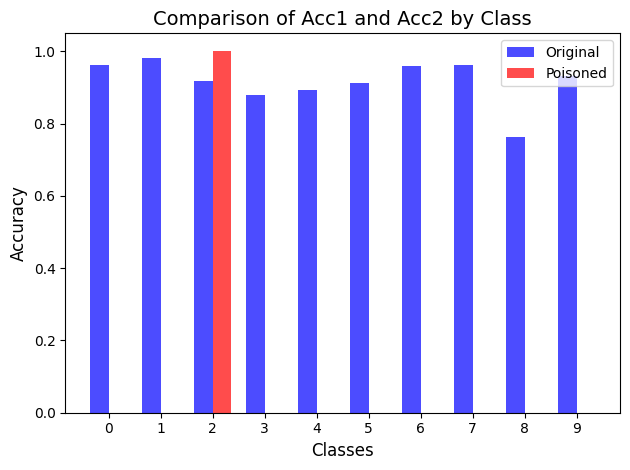

In [91]:
import matplotlib.pyplot as plt
import numpy as np

classes = np.arange(10)  # Assuming 10 classes (0-9)

# Plot Acc1 and Acc2 side by side for each class
bar_width = 0.35
index = np.arange(len(classes))

plt.bar(index, accuracy_per_class1, bar_width, label='Original', color='b', alpha=0.7)
plt.bar(index + bar_width, accuracy_per_class2, bar_width, label='Poisoned', color='r', alpha=0.7)

# Add labels and title
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparison of Acc1 and Acc2 by Class', fontsize=14)
plt.xticks(index + bar_width / 2, classes)

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [92]:
# test_by_class(averaged_model, trainloaders[9])

In [93]:
mdls = []
samp_mdl_ids = [str(i) for i in range(5,10)]
print(samp_mdl_ids)
for i in samp_mdl_ids:
    cli_0 = client_updates_list_nw[0][i][0]
    cli_0_ = get_mdl_from_weights(cli_0)
    cli_0_.to(constants.DEVICE)
    mdls.append(cli_0_)

averaged_model = fed_avg(mdls)
_, _, accuracy_per_class1 = test_by_class(averaged_model, trainloaders[9])
print(accuracy_per_class1)

samp_mdl_ids = [str(i) for i in range(1)]
# print(samp_mdl_ids)
for i in samp_mdl_ids:
    cli_0 = client_updates_list_nw[0][i][0]
    cli_0_ = get_mdl_from_weights(cli_0)
    cli_0_.to(constants.DEVICE)
    mdls.append(cli_0_)
# mdls.append(cli_0_mdl_d)
averaged_model = fed_avg(mdls)
_, _, accuracy_per_class2 = test_by_class(averaged_model, trainloaders[9])
print(accuracy_per_class2)

['5', '6', '7', '8', '9']
[0.9626168224299065, 0.9803921568627451, 0.9175257731958762, 0.8787878787878788, 0.8932038834951457, 0.9130434782608695, 0.9595959595959596, 0.9622641509433962, 0.7634408602150538, 0.9313725490196079]
[0.9532710280373832, 0.9803921568627451, 0.9072164948453608, 0.8484848484848485, 0.7572815533980582, 0.8913043478260869, 0.9494949494949495, 0.8867924528301887, 0.7311827956989247, 0.9705882352941176]


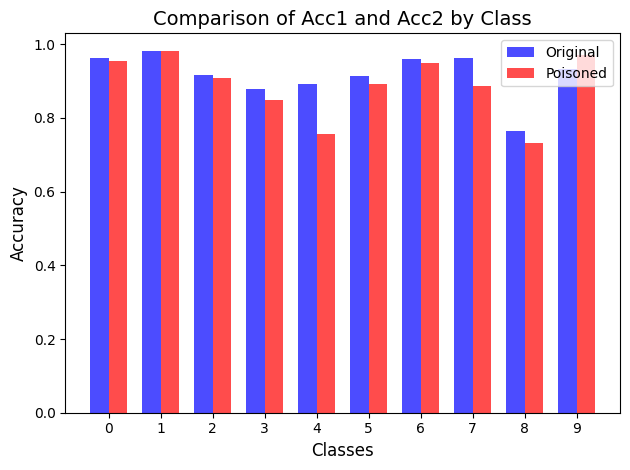

In [94]:
import matplotlib.pyplot as plt
import numpy as np

classes = np.arange(10)  # Assuming 10 classes (0-9)

# Plot Acc1 and Acc2 side by side for each class
bar_width = 0.35
index = np.arange(len(classes))

plt.bar(index, accuracy_per_class1, bar_width, label='Original', color='b', alpha=0.7)
plt.bar(index + bar_width, accuracy_per_class2, bar_width, label='Poisoned', color='r', alpha=0.7)

# Add labels and title
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparison of Acc1 and Acc2 by Class', fontsize=14)
plt.xticks(index + bar_width / 2, classes)

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [101]:
from src.FLProcess.FLUtil import get_mdl_from_weights, get_pred_from_models, get_mdl_of_client_at_round
from src.dataset.datasetHandler import get_testloader
import shap
from src.poisonDetection.clusteringHDBSCAN import run_hdbscan_clustering_algorithm
from src.poisonDetection.tsneVisualisation import get_tsne_data_from_input_features, visualise_tsne_clusters_with_idx, \
    visualise_clusters_with_tsne
from src.poisonDetection.clientAnalysis.strategyFnGeneralAlg import general_algorithm_main_calc

In [102]:
sample_count_for_test = 100
sample_count_for_plot = 1
total_rounds = 1
total_labels_per_client = 10
client_updates_list = client_updates_list_nw
target_clients = list(client_updates_list[0].keys())

testloader = get_testloader(len_test=sample_count_for_test+sample_count_for_plot*2, batch_size=sample_count_for_test+sample_count_for_plot*2, 
                            shuffle=True)
batch = next(iter(testloader))
images, actual_out = batch
background = images[:sample_count_for_test]
test_images = images[sample_count_for_test:sample_count_for_test + sample_count_for_plot]

total_detected_poison_idxes = []

for round in range(total_rounds):
    shap_feature_ori_list_all = []
    round_no = round
    shap_feature_ori_list_all = []
    
    for cli in target_clients:
        target_client_id = cli
        mdl_0 = get_mdl_of_client_at_round(target_client_id=target_client_id, round_no=round_no,
                                           client_updates_list=client_updates_list)
        e = shap.DeepExplainer(mdl_0, background)
        shap_values = e.shap_values(test_images)
        shap_vals_all_flattened = []
        for pred in shap_values:
            for j in pred:
                shap_vals_all_flattened.append(j.flatten())
        shap_feature_ori_list_all.append(shap_vals_all_flattened)
    shap_feature_list = shap_feature_ori_list_all
    shap_feature_per_client = []
    for i in range(len(target_clients)):
        for j in range(sample_count_for_plot*total_labels_per_client):
            shap_feature_per_client.append(shap_feature_list[i][j])
    # print(len(shap_feature_per_client))
    min_cluster_size = 2
    epsilon = 0.011
    # epsilon = 0.0
    hdbscan_labels, hdbscan_clusterer, colors = run_hdbscan_clustering_algorithm(
            input_feature_list=shap_feature_per_client, min_cluster_size=min_cluster_size, epsilon=epsilon)
    # print(hdbscan_labels)
    perplexity = 10
    visualise_clusters_with_tsne(input_feature_list=shap_feature_per_client, label_list=hdbscan_labels,
                                     label_colors=colors, perplexity=perplexity,
                                     show_malicious_items=False, malicious_start_idx=None,
                                     malicious_end_idx=None, show_labels=True)
    poison_idxes = general_algorithm_main_calc2(client_updates_list, total_labels_per_client*sample_count_for_plot, hdbscan_labels)
    total_detected_poison_idxes.append(poison_idxes)

AssertionError: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 2.6744590302793085 - Tolerance: 0.01

## Old

In [95]:
# Transformations
transform = transforms.Compose([transforms.ToTensor()])

# Load MNIST Dataset
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)


In [45]:
images, labels = next(iter(test_loader))
image = images[0].unsqueeze(0) 
np.shape(image.to(constants.DEVICE))

torch.Size([1, 1, 28, 28])

In [52]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, loss, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [53]:
# Training Loop (for demonstration, keep it simple)
def train_model(model, train_loader, criterion, optimizer, epochs=1):
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

# Train the model (adjust epochs as needed)
train_model(model, train_loader, criterion, optimizer, epochs=1)


Epoch 1, Loss: 0.3536928052674415


In [54]:
# Select an image from the test dataset
images, labels = next(iter(test_loader))
image = images[0].unsqueeze(0)  # Select the first image from the batch

# Set model to evaluation mode
model.eval()

# Initialize LayerLRP for the first fully connected layer (fc1)
layer_lrp_fc1 = LayerLRP(model, model.fc1)

# Compute the relevance score for the selected image and target label (for this example, using the ground truth label)
target_label = labels[0].item()
attributions_fc1 = layer_lrp_fc1.attribute(image, target=target_label)

# Initialize LayerLRP for the second fully connected layer (fc2)
layer_lrp_fc2 = LayerLRP(model, model.fc2)
attributions_fc2 = layer_lrp_fc2.attribute(image, target=target_label)

# Convert attributions to numpy for visualization
attributions_fc1_np = attributions_fc1.detach().numpy().squeeze()
attributions_fc2_np = attributions_fc2.detach().numpy().squeeze()

# # Visualize the relevance scores
# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.title('LRP for fc1 Layer')
# plt.imshow(attributions_fc1_np.reshape(28, 28), cmap='hot', interpolation='nearest')
# plt.colorbar()

# plt.subplot(1, 2, 2)
# plt.title('LRP for fc2 Layer')
# plt.imshow(attributions_fc2_np.reshape(28, 28), cmap='hot', interpolation='nearest')
# plt.colorbar()

# plt.show()


In [55]:
np.shape(attributions_fc1_np)

(128,)

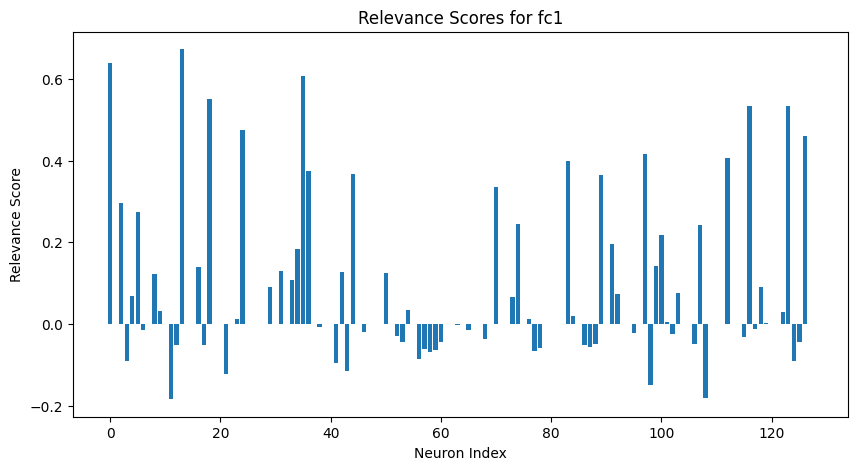

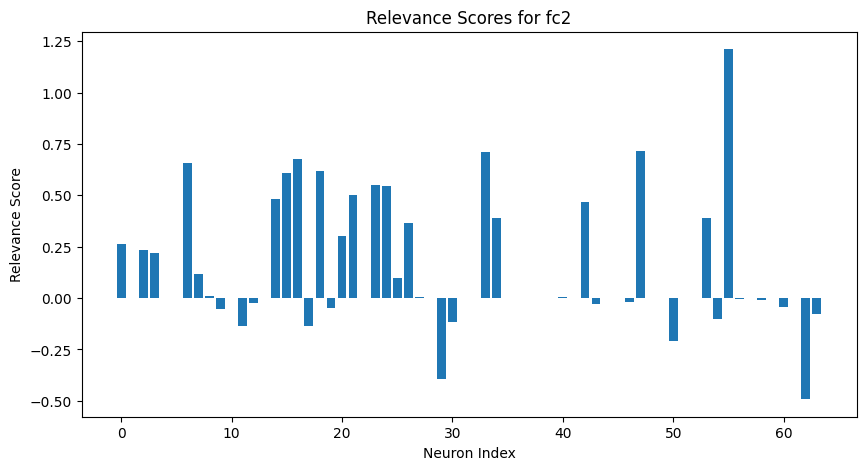

In [56]:
# Import necessary captum tools
from captum.attr import LayerAttribution

# Propagate the attributions back to the input space
import matplotlib.pyplot as plt

def visualize_fc_layer_attributions(attributions, layer_name):
    # Convert attributions to numpy array
    attributions_np = attributions.detach().numpy().squeeze()
    
    # Create a bar plot of the attributions
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(attributions_np)), attributions_np)
    plt.title(f'Relevance Scores for {layer_name}')
    plt.xlabel('Neuron Index')
    plt.ylabel('Relevance Score')
    plt.show()

# Visualize for fc1
visualize_fc_layer_attributions(attributions_fc1, 'fc1')

# Visualize for fc2
visualize_fc_layer_attributions(attributions_fc2, 'fc2')

# Let's visualize the attribution back to the input for fc1
# visualize_layer_attributions_back_to_input(attributions_fc1, 'fc1', image, target_label)

# And also for fc2
# visualize_layer_attributions_back_to_input(attributions_fc2, 'fc2', image, target_label)


In [437]:
## trying conv model

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from captum.attr import LayerLRP
import matplotlib.pyplot as plt

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [58]:
# Training Loop
def train_model(model, train_loader, criterion, optimizer, epochs=1):
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=1)


Epoch 1, Loss: 0.17717828822266588


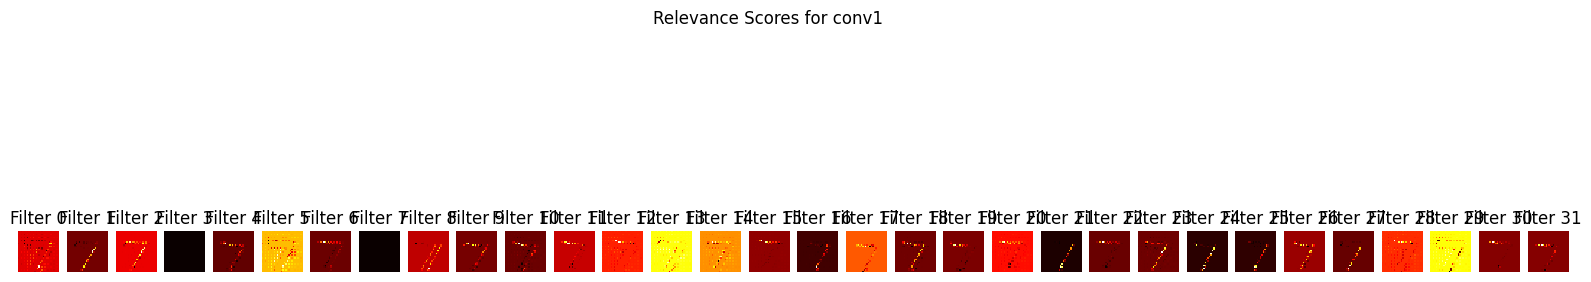

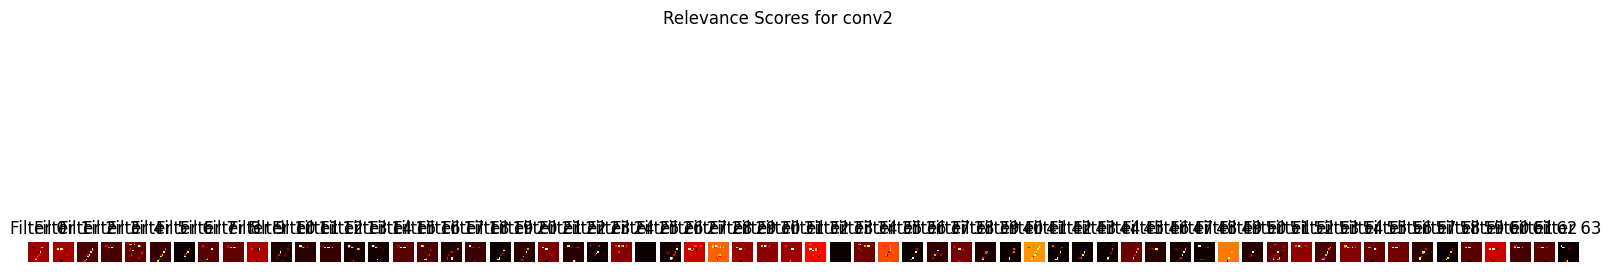

In [59]:
from captum.attr import LayerLRP

# Select an image from the test dataset
images, labels = next(iter(test_loader))
image = images[0].unsqueeze(0)  # Select the first image from the batch

# Set model to evaluation mode
model.eval()

# Initialize LayerLRP for conv1 layer
layer_lrp_conv1 = LayerLRP(model, model.conv1)
attributions_conv1 = layer_lrp_conv1.attribute(image, target=labels[0].item())

# Initialize LayerLRP for conv2 layer
layer_lrp_conv2 = LayerLRP(model, model.conv2)
attributions_conv2 = layer_lrp_conv2.attribute(image, target=labels[0].item())

# Convert attributions to numpy for visualization
attributions_conv1_np = attributions_conv1.detach().numpy().squeeze()
attributions_conv2_np = attributions_conv2.detach().numpy().squeeze()

import torch

def visualize_conv_layer_attributions(attributions, layer_name):
    # Check if attributions are NumPy arrays, convert to PyTorch tensors if so
    if isinstance(attributions, np.ndarray):
        attributions = torch.tensor(attributions)
    
    # Add a batch dimension if it's missing
    if attributions.ndimension() == 3:
        attributions = attributions.unsqueeze(0)  # Add batch dimension

    # Ensure attributions are in the correct shape (N, C, H, W)
    if len(attributions.shape) != 4:
        raise ValueError(f'Expected 4D tensor, but got shape: {attributions.shape}')
    
    num_filters = attributions.shape[1]
    fig, axes = plt.subplots(1, num_filters, figsize=(20, 5))
    
    if num_filters == 1:
        axes = [axes]  # Ensure axes is iterable if there's only one filter
    
    for i in range(num_filters):
        # Each filter’s relevance should be a 2D array (H, W)
        filter_attribution = attributions[0, i].detach().numpy()  # Convert to NumPy array
        
        # Check shape and reshape if necessary
        if filter_attribution.ndim != 2:
            filter_attribution = filter_attribution.squeeze()
        
        # Plot each filter's relevance
        axes[i].imshow(filter_attribution, cmap='hot', interpolation='nearest')
        axes[i].set_title(f'Filter {i}')
        axes[i].axis('off')
    
    plt.suptitle(f'Relevance Scores for {layer_name}')
    plt.show()

# Example usage with convolutional layers
visualize_conv_layer_attributions(attributions_conv1_np, 'conv1')
visualize_conv_layer_attributions(attributions_conv2_np, 'conv2')


In [60]:
np.shape(attributions_conv2_np)

(64, 14, 14)

## Custom LRP rule

In [463]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input: 28x28x1, Output: 28x28x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Input: 28x28x32, Output: 28x28x64
        self.pool = nn.MaxPool2d(2, 2)  # Halves the size
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Input: 64*7*7, Output: 128
        self.fc2 = nn.Linear(128, 10)  # Output: 10 (MNIST classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # After conv1 and pool: 14x14x32
        x = self.pool(F.relu(self.conv2(x)))  # After conv2 and pool: 7x7x64
        x = x.view(-1, 64 * 7 * 7)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MNIST_CNN()


In [464]:
from captum.attr import LayerLRP
import torch

class AlphaBetaLRP(LayerLRP):
    def __init__(self, model, layer, alpha=1, beta=0):
        super().__init__(model, layer)
        self.alpha = alpha
        self.beta = beta

    def custom_lrp_rule(self, layer_input, layer_output, relevance):
        # Alpha-Beta rule: separate positive and negative contributions
        positive_contrib = torch.clamp(layer_input, min=0) * relevance  # Only positive relevance
        negative_contrib = torch.clamp(layer_input, max=0) * relevance  # Only negative relevance
        
        return self.alpha * positive_contrib + self.beta * negative_contrib

    def attribute(self, inputs, target=None, *args, **kwargs):
        # Call LayerLRP's attribute method to compute the relevance
        relevances = super().attribute(inputs, target=target, *args, **kwargs)
        
        # Apply custom alpha-beta rule
        for i in range(relevances.shape[1]):  # Iterate through each channel (filter)
            relevances[:, i, :, :] = self.custom_lrp_rule(inputs, inputs, relevances[:, i, :, :])
        
        return relevances


In [465]:
# Assuming MNIST dataset is loaded and a trained model exists
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(mnist_test, batch_size=1, shuffle=True)

# Get a sample image
# data_iter = iter(test_loader)
# inputs, target = data_iter.next()

# Pass the input through the model (assuming model is trained)
# model.eval()
# outputs = model(inputs)
# Select an image from the test dataset
inputs, target = next(iter(test_loader))
image = images[0].unsqueeze(0)  # Select the first image from the batch

# Set model to evaluation mode
model.eval()

MNIST_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [466]:
# Apply Alpha-Beta LRP to conv1
alpha_beta_lrp_conv1 = AlphaBetaLRP(model, model.conv1, alpha=1, beta=0)  # Alpha-Beta LRP for conv1
attributions_conv1 = alpha_beta_lrp_conv1.attribute(inputs, target=torch.argmax(outputs))

# Apply Alpha-Beta LRP to conv2
alpha_beta_lrp_conv2 = AlphaBetaLRP(model, model.conv2, alpha=1, beta=0)  # Alpha-Beta LRP for conv2
attributions_conv2 = alpha_beta_lrp_conv2.attribute(inputs, target=torch.argmax(outputs))


RuntimeError: Module MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) is being used more than once in the network, which is not supported by LRP. Please ensure that module is being used only once in the network.

In [450]:
from captum.attr import LayerAttribution
import torch

class CustomLRP(LayerAttribution):
    def __init__(self, model, layer):
        super().__init__(model, layer)
    
    def custom_lrp_rule(self, layer_input, layer_output, relevance):
        # Implement your custom rule (alpha-beta, gamma, etc.)
        # Example: alpha-beta rule:
        positive_contrib = torch.clamp(layer_input, min=0) * relevance
        negative_contrib = torch.clamp(layer_input, max=0) * relevance
        return positive_contrib - negative_contrib

    def attribute(self, inputs, target=None, *args, **kwargs):
        # Get the forward pass outputs
        layer_outputs = self.forward(inputs)

        # Compute initial relevance (can be target output, etc.)
        initial_relevance = layer_outputs.clone()

        # Apply the custom LRP rule layer by layer
        for i, layer_output in enumerate(layer_outputs):
            initial_relevance = self.custom_lrp_rule(inputs, layer_output, initial_relevance)

        return initial_relevance


In [453]:
# Instantiate your custom LRP class
alpha_beta_lrp = AlphaBetaLRP(model, model.conv2, alpha=1, beta=0)

# Compute attributions using the custom LRP rule
attributions = alpha_beta_lrp.attribute(image, target=labels[0].item())


RuntimeError: The size of tensor a (28) must match the size of tensor b (14) at non-singleton dimension 3

In [94]:
# test_data_0 = testloaders.dataset[0][0].to(constants.DEVICE)

In [95]:
# # cli_0_mdl(test_data_0)
# test_data_0 = testloaders.dataset[0][0].to(constants.DEVICE)
# cli_0_mdl.eval()
# with torch.no_grad():
#     for images, labels in testloaders:
#         images, labels = images.to(constants.DEVICE), labels.to(constants.DEVICE)
#         # print(type(images))
#         print(np.shape(images))
#         outputs = cli_0_mdl(images)
#         break

In [96]:
# outputs

In [108]:
cf_data = np.array([[cfs]])
cf_data_t = torch.tensor(cf_data).to(constants.DEVICE)
ori_data = np.array([[ori]])
ori_data_t = torch.tensor(ori_data).to(constants.DEVICE)

In [115]:
cli_0_mdl(ori_data_t)

tensor([[-9.0285e+00, -7.4189e+00, -5.4346e+00, -5.9643e+00, -8.2406e+00,
         -1.0563e+01, -1.2655e+01, -1.0472e-02, -9.6874e+00, -6.0277e+00]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

In [117]:
cli_0_mdl(cf_data_t)

tensor([[-3.4889, -6.8626, -2.2982, -0.3627, -7.2540, -4.1161, -8.9115, -2.0321,
         -5.4002, -3.9404]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

### LRP test

In [100]:
import lrp.plot
from lrp import image, rules
from lrp.core import LRP
from lrp.filter import LayerFilter
from lrp.rules import LrpEpsilonRule, LrpGammaRule, LrpZBoxRule, LrpZeroRule
from lrp.zennit.types import AvgPool, Linear

In [101]:
import torch.nn as nn

class WrappedNetMNIST(nn.Module):
    def __init__(self, original_model):
        super(WrappedNetMNIST, self).__init__()
        # Define the features and classifier based on the original model
        self.features = nn.Sequential(
            original_model.conv1,
            nn.ReLU(),
            original_model.conv2,
            nn.ReLU(),
            nn.MaxPool2d(2),
            original_model.dropout1
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            original_model.fc1,
            nn.ReLU(),
            original_model.dropout2,
            original_model.fc2,
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [114]:
cli_0_mdl = WrappedNetMNIST(cli_0_mdl)

In [118]:
# Low and high parameters for zB-rule
from typing import Callable, Dict, List, Tuple, Union

batch_size: int = 1
shape: Tuple[int] = (batch_size, 1, 28, 28)  # MNIST images are 28x28 pixels

low: torch.Tensor = torch.zeros(*shape)
high: torch.Tensor = torch.ones(*shape)

# Init layer filter
target_types: Tuple[type] = (torch.nn.Conv2d, torch.nn.Linear)
filter_by_layer_index_type: LayerFilter = LayerFilter(model=cli_0_mdl, target_types=target_types)

name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]

# LRP Composite adapted for Net_MNIST
name_map = [
    # Apply LrpZBoxRule to the first convolutional layer (conv1)
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    
    # Apply LrpGammaRule to the second convolutional layer (conv2)
    (filter_by_layer_index_type(lambda n: 1), LrpGammaRule, {'gamma': 0.25}),
    
    # Apply LrpEpsilonRule to the first fully connected layer (fc1)
    (filter_by_layer_index_type(lambda n: 3), LrpEpsilonRule, {'epsilon': 0.25}),
    
    # Apply LrpZeroRule to the output layer (fc2)
    (filter_by_layer_index_type(lambda n: 4), LrpZeroRule, {}),
]

# Init LRP
lrp_instance: LRP = LRP(cli_0_mdl)

# Prepare model layers for LRP
lrp_instance.convert_layers(name_map)

# Compute relevance attributions
# R: torch.Tensor = lrp_instance.relevance(X)

# Display heatmap
# lrp_instance.heatmap(R, width=2, height=2)

Finished 'relevance' in 0.0053 secs


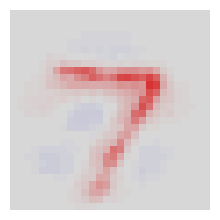

In [124]:
# Fetch a single batch from the testloader
# data_iter = iter(testloaders)
# data, target = next(data_iter)

# Move data to the appropriate device (e.g., GPU if available)
# data = data.to(constants.DEVICE)
# target = target.to(constants.DEVICE)

# Forward pass: Get the model's prediction
output = cli_0_mdl(ori_data_t)
# Compute relevance for the batch
relevance_ori = lrp_instance.relevance(ori_data_t)

# Visualize the relevance for the first sample in the batch
lrp_instance.heatmap(relevance_ori, width=2, height=2)

Finished 'relevance' in 0.0053 secs


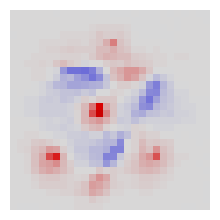

In [125]:
# Fetch a single batch from the testloader
# data_iter = iter(testloaders)
# data, target = next(data_iter)

# Move data to the appropriate device (e.g., GPU if available)
# data = data.to(constants.DEVICE)
# target = target.to(constants.DEVICE)

# Forward pass: Get the model's prediction
output = cli_0_mdl(cf_data_t)
# Compute relevance for the batch
relevance_cf = lrp_instance.relevance(cf_data_t)

# Visualize the relevance for the first sample in the batch
lrp_instance.heatmap(relevance_cf, width=2, height=2)

In [229]:
def calculate_neuron_importance(model, input_relevance_scores):
    model.eval()  # Set model to evaluation mode
    
    # Initialize dictionaries to hold neuron importance and layer-wise activations
    neuron_importance = {}
    
    # Forward pass to get layer outputs
    def forward_hook(module, input, output):
        if isinstance(module, nn.Linear):
            # Calculate neuron importance for the current layer
            with torch.no_grad():
                # Get input activations
                input_activations = input[0]
                
                # Compute relevance propagation
                if module in layer_inputs:
                    previous_layer_relevance = layer_inputs[module]
                else:
                    previous_layer_relevance = input_relevance_scores

                # Calculate neuron importance for this layer
                weights = module.weight.data
                relevance_scores = torch.matmul(previous_layer_relevance, weights.T)
                
                for i, neuron in enumerate(module.out_features):
                    neuron_importance[(module, i)] = relevance_scores[:, i].sum().item()
                
                # Prepare for the next layer
                layer_inputs[module] = relevance_scores
    
    layer_inputs = {}
    hooks = []
    
    # Register forward hooks to capture intermediate activations
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            hook = module.register_forward_hook(forward_hook)
            hooks.append(hook)
    
    # Pass dummy data to activate the forward hooks
    dummy_input = torch.randn(1, input_relevance_scores.size(1))  # Adjust size as needed
    with torch.no_grad():
        _ = model(dummy_input)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    return neuron_importance


In [233]:
relevance_cf.size()

torch.Size([1, 1, 28, 28])

In [230]:
def calculate_weight_importance(model, neuron_importance):
    weight_importance = {}
    
    # Compute weight importance based on neuron importance
    with torch.no_grad():
        for name, module in model.named_modules():
            if isinstance(module, nn.Linear):
                weights = module.weight.data
                for i in range(weights.size(0)):  # Output neurons
                    for j in range(weights.size(1)):  # Input neurons
                        weight_key = (j, i)
                        if weight_key in weight_importance:
                            weight_importance[weight_key] += neuron_importance[(module, i)] * weights[i, j].item()
                        else:
                            weight_importance[weight_key] = neuron_importance[(module, i)] * weights[i, j].item()
    
    return weight_importance


In [231]:
# Calculate neuron importance
neuron_importance = calculate_neuron_importance(cli_0_mdl, relevance_cf)

# Calculate weight importance
weight_importance = calculate_weight_importance(cli_0_mdl, neuron_importance)

print("Neuron Importance:", neuron_importance)
print("Weight Importance:", weight_importance)


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1]

In [319]:
# relevance_ori

In [134]:
# relevance_cf

Finished 'relevance' in 0.0040 secs


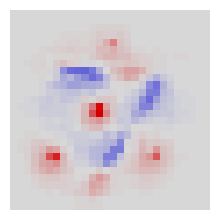

In [131]:
# Fetch a single batch from the testloader
# data_iter = iter(testloaders)
# data, target = next(data_iter)

# Move data to the appropriate device (e.g., GPU if available)
# data = data.to(constants.DEVICE)
# target = target.to(constants.DEVICE)

# Forward pass: Get the model's prediction
output = cli_0_mdl(cf_data_t)
# Compute relevance for the batch
relevance_cf = lrp_instance.relevance(cf_data_t)

# Visualize the relevance for the first sample in the batch
lrp_instance.heatmap(relevance_cf-relevance_ori, width=2, height=2)

In [226]:
np.shape(relevance_cf)

torch.Size([1, 1, 28, 28])

In [149]:
# !pip install innvestigate

### Test LRP local implementation

In [413]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a simple neural network model in PyTorch
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(5, 10)
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
model = SimpleNN()

# Example input
x = torch.rand(1, 5, requires_grad=True)

# Forward pass to store intermediate outputs
def forward_pass_with_intermediate_outputs(model, x):
    intermediate_outputs = [x]  # Include the input as the first "intermediate output"
    for layer in model.children():
        # print(np.shape(layer))
        x = F.relu(layer(x)) if isinstance(layer, nn.Linear) else layer(x)
        # if isinstance(layer, nn.Linear):
        #     x = x.view(x.size(0), -1)  # Flatten before fully connected layers
        #     x = F.relu(layer(x))
        # else:
        #     x = layer(x)
        print(np.shape(x))
        intermediate_outputs.append(x)
    return intermediate_outputs

# Capture the outputs at each layer
intermediate_outputs = forward_pass_with_intermediate_outputs(model, x)
# print(intermediate_outputs)

# Final output
output = intermediate_outputs[-1]
# model(x)
# type(x)
# model.children()
# output

torch.Size([1, 10])
torch.Size([1, 5])
torch.Size([1, 1])


In [407]:
# LRP function with weight relevance
def lrp_with_weight_relevance(model, intermediate_outputs):
    relevance = intermediate_outputs[-1]  # Start with output relevance
    weight_relevance_scores = []

    # Iterate through layers in reverse
    num_layers = len(list(model.children()))
    # print(num_layers)
    # print(intermediate_outputs)
    for i, layer in enumerate(reversed(list(model.children()))):
        
        if isinstance(layer, nn.Linear):
            # print(-(i+2))
            
            # print(intermediate_outputs[-(i+2)])
            x = intermediate_outputs[-(i+2)]  # Get the corresponding intermediate output
            z = layer(x).detach()  # Pre-activation values
            # print('z: ',z)
            s = relevance / (z + 1e-9)  # Safe division to avoid division by zero
            print(np.shape(s))
            print(np.shape(s.T))
            print(np.shape(x))
            c = torch.mm(s.T, x)  # Contribution of each weight
            relevance = torch.mm(s, layer.weight)  # Recompute relevance for the input of this layer
            weight_relevance_scores.append(c)
    
    weight_relevance_scores.reverse()  # Relevance scores for layers in original order
    return relevance, weight_relevance_scores

# Perform LRP with weight relevance
input_relevance, weight_relevance_scores = lrp_with_weight_relevance(model, intermediate_outputs)

print("Relevance scores for input features:", input_relevance)

# Print relevance scores for weights in each layer
for i, layer in enumerate(model.children()):
    if isinstance(layer, nn.Linear):
        print(f"Layer {i+1} - Weight relevance scores shape: {weight_relevance_scores[i].shape}")
        print(weight_relevance_scores[i])


torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 5])
torch.Size([1, 5])
torch.Size([5, 1])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([10, 1])
torch.Size([1, 5])
Relevance scores for input features: tensor([[-0.9915,  2.0799,  2.9695,  5.1186,  2.6697]], grad_fn=<MmBackward0>)
Layer 1 - Weight relevance scores shape: torch.Size([10, 5])
tensor([[-0.7973, -0.3222, -0.9499, -0.4234, -1.6874],
        [-0.2498, -0.1009, -0.2976, -0.1327, -0.5287],
        [ 0.4473,  0.1808,  0.5330,  0.2375,  0.9467],
        [ 1.4156,  0.5721,  1.6867,  0.7518,  2.9962],
        [ 0.1434,  0.0580,  0.1709,  0.0762,  0.3036],
        [ 0.5717,  0.2310,  0.6812,  0.3036,  1.2101],
        [-3.1475, -1.2719, -3.7503, -1.6715, -6.6618],
        [ 1.4089,  0.5694,  1.6788,  0.7482,  2.9821],
        [ 0.1382,  0.0558,  0.1646,  0.0734,  0.2925],
        [-0.0944, -0.0381, -0.1124, -0.0501, -0.1997]], grad_fn=<MmBackward0>)
Layer 2 - Weight relevance scores shape: torch.Size([5, 10])
tensor([[0.000

In [408]:
def lrp_with_neuron_contribution(model, intermediate_outputs):
    relevance = intermediate_outputs[-1]  # Start with output relevance
    neuron_contributions = []

    # Iterate through layers in reverse
    for i, layer in enumerate(reversed(list(model.children()))):
        if isinstance(layer, nn.Linear):
            x = intermediate_outputs[-(i + 2)]  # Get the corresponding intermediate output
            z = layer(x).detach()  # Pre-activation values
            s = relevance / (z + 1e-9)  # Safe division to avoid division by zero
            
            # Here, instead of using torch.mm, we multiply element-wise
            # to get the contribution for each neuron individually.
            # Expand s to match the weights
            print(s)
            contribution_per_neuron = s.unsqueeze(2) * layer.weight.unsqueeze(0)  # Element-wise multiplication
            relevance = torch.mm(s, layer.weight)  # Recompute relevance for the input of this layer
            
            # Store the contribution for this layer
            neuron_contributions.append(contribution_per_neuron)
    
    neuron_contributions.reverse()  # Contributions for layers in original order
    return relevance, neuron_contributions

# Perform LRP with weight relevance
input_relevance, weight_relevance_scores = lrp_with_neuron_contribution(model, intermediate_outputs)

print("Relevance scores for input features:", input_relevance)

# Print relevance scores for weights in each layer
for i, layer in enumerate(model.children()):
    if isinstance(layer, nn.Linear):
        print(f"Layer {i+1} - Weight relevance scores shape: {weight_relevance_scores[i].shape}")
        print(weight_relevance_scores[i])


tensor([[1.]], grad_fn=<DivBackward0>)
tensor([[0.1833, 0.8667, 2.2518, 0.6337, 0.7244]], grad_fn=<DivBackward0>)
tensor([[-2.3793, -0.7455,  1.3349,  4.2247,  0.4281,  1.7063, -9.3933,  4.2047,
          0.4124, -0.2816]], grad_fn=<DivBackward0>)
Relevance scores for input features: tensor([[-0.9915,  2.0799,  2.9695,  5.1186,  2.6697]], grad_fn=<MmBackward0>)
Layer 1 - Weight relevance scores shape: torch.Size([1, 10, 5])
tensor([[[ 0.6730, -0.2155, -0.8042,  1.0566, -0.6771],
         [-0.0618, -0.0345,  0.1907, -0.2964, -0.1170],
         [ 0.1956,  0.0999,  0.5572,  0.4527,  0.3403],
         [ 1.3487,  0.9849,  0.2387,  1.8799,  1.6359],
         [-0.1702,  0.1535,  0.1194,  0.1162,  0.1307],
         [-0.5225,  0.3959,  0.6603, -0.3085,  0.4864],
         [-1.1718, -0.7915,  3.3780,  3.5848,  1.4285],
         [-1.5300,  1.5631, -1.3803, -1.6022, -0.4406],
         [ 0.1794, -0.0596,  0.0780,  0.1340, -0.1057],
         [ 0.0682, -0.0163, -0.0684,  0.1015, -0.0117]]],
       gra

In [420]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a simple neural network model with a Conv2d layer in PyTorch
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)  # Conv layer with 1 input channel, 3 output channels, 3x3 kernel
        self.fc1 = nn.Linear(3 * 3 * 3, 10)  # Adjusted input size for fc1
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, 1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply conv layer and ReLU
        x = x.view(x.size(0), -1)  # Flatten the tensor correctly
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
model = SimpleNN()

# Example input (batch size = 1, 1 channel, 5x5 image)
x = torch.rand(1, 1, 5, 5, requires_grad=True)

# Forward pass to store intermediate outputs
def forward_pass_with_intermediate_outputs(model, x):
    intermediate_outputs = [x]  # Include the input as the first "intermediate output"
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            x = F.relu(layer(x))
        elif isinstance(layer, nn.Linear):
            x = x.view(x.size(0), -1)  # Flatten before fully connected layers
            x = F.relu(layer(x))
        intermediate_outputs.append(x)
    return intermediate_outputs

# Capture the outputs at each layer
intermediate_outputs = forward_pass_with_intermediate_outputs(model, x)

# print(intermediate_outputs)
# Final output
output = intermediate_outputs[-1]

# LRP function with weight relevance
def lrp_with_weight_relevance(model, intermediate_outputs):
    relevance = intermediate_outputs[-1]  # Start with output relevance
    print(np.shape(relevance))
    weight_relevance_scores = []

    # Iterate through layers in reverse
    for i, layer in enumerate(reversed(list(model.children()))):
        
        if isinstance(layer, nn.Linear):
            x = intermediate_outputs[-(i + 2)]  # Get the corresponding intermediate output
            print('shape:',np.shape(x))
            if x.dim() > 2:
                    x = x.view(x.size(0), -1)
            z = layer(x).detach()  # Pre-activation values
            print('flattend:',np.shape(x))
            print(np.shape(z))
            print('relevance: ',np.shape(relevance))
            s = relevance / (z + 1e-9)  # Safe division to avoid division by zero
            c = torch.mm(s.T, x)  # Contribution of each weight
            relevance = torch.mm(s, layer.weight)  # Recompute relevance for the input of this layer
            weight_relevance_scores.append(c)
        
        # elif isinstance(layer, nn.Conv2d):
        #     x = intermediate_outputs[-(i + 2)]
        #     print('con_x:',np.shape(x))
        #     z = layer(x).detach()
        #     print('con_z:',np.shape(z))
        #     print('relevance: ',np.shape(relevance))
        #     if z.dim() > 2:
        #             z = z.view(z.size(0), -1)
        #     s = relevance / (z + 1e-9)   # Safe division
        #     # Placeholder for convolutional relevance calculation
        #     c = torch.zeros_like(layer.weight)  # Replace with actual computation
        #     relevance = s.sum(dim=1, keepdim=True)  # Adjust relevance propagation for conv layers
        #     weight_relevance_scores.append(c)
            
        elif isinstance(layer, nn.Conv2d):
            x = intermediate_outputs[-(i + 2)]  # Get the output from the previous layer
            z = layer(x).detach()  # Pre-activation values
            print('con_x:', np.shape(x))
            print('con_z:', np.shape(z))
            print('relevance: ', np.shape(relevance))
        
            # Compute the activations for the convolutional layer
            # if z.dim() > 2:
            #     z = z.view(z.size(0), -1)
        
            # # Using the LRP-epsilon rule to propagate relevance
            # epsilon = 1e-9  # Small stabilizer to avoid division by zero
            # s = relevance / (z + epsilon)  # Relevance score per neuron
            #     # Compute activations for the convolutional layer (keeping 4D shape)
            s = relevance / (z + 1e-9)  # Relevance score per neuron
            
            # Make sure `s` is 4D: [batch_size, num_channels, height, width]
            s = s.view_as(z)  # Reshape `s` to match the shape of `z`
        
            # Compute the relevance contribution for each weight
            c = torch.nn.functional.conv2d(x, layer.weight, stride=layer.stride, padding=layer.padding)
            
            relevance = torch.nn.functional.conv_transpose2d(s, layer.weight, stride=layer.stride, padding=layer.padding)
        
            weight_relevance_scores.append(c)

    
    weight_relevance_scores.reverse()  # Relevance scores for layers in original order
    return relevance, weight_relevance_scores

# Perform LRP with weight relevance
input_relevance, weight_relevance_scores = lrp_with_weight_relevance(model, intermediate_outputs)

print("Relevance scores for input features:", input_relevance)

# Print relevance scores for weights in each layer
for i, layer in enumerate(model.children()):
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        print(f"Layer {i+1} - Weight relevance scores shape: {weight_relevance_scores[i].shape}")
        print(weight_relevance_scores[i])


torch.Size([1, 1])
shape: torch.Size([1, 5])
flattend: torch.Size([1, 5])
torch.Size([1, 1])
relevance:  torch.Size([1, 1])
shape: torch.Size([1, 10])
flattend: torch.Size([1, 10])
torch.Size([1, 5])
relevance:  torch.Size([1, 5])
shape: torch.Size([1, 3, 3, 3])
flattend: torch.Size([1, 27])
torch.Size([1, 10])
relevance:  torch.Size([1, 10])
con_x: torch.Size([1, 1, 5, 5])
con_z: torch.Size([1, 3, 3, 3])
relevance:  torch.Size([1, 27])


RuntimeError: The size of tensor a (27) must match the size of tensor b (3) at non-singleton dimension 3

In [256]:
np.shape(intermediate_outputs[-(i+2)])

torch.Size([1, 3, 3, 3])

In [279]:
# layer(x)

In [276]:
relevance = intermediate_outputs[-1]  # Start with output relevance
# print(np.shape(relevance))
weight_relevance_scores = []

for i, layer in enumerate(reversed(list(model.children()))):
    if isinstance(layer, nn.Linear):
        x = intermediate_outputs[-(i + 2)]  # Get the corresponding intermediate output
        print('shape:',np.shape(x))
        if x.dim() > 2:
                x = x.view(x.size(0), -1)
        z = layer(x).detach()  # Pre-activation values
        print('flattend:',np.shape(x))
        print(np.shape(z))
        print('relevance: ',np.shape(relevance))
        s = relevance / (z + 1e-9)  # Safe division to avoid division by zero
        c = torch.mm(s.T, x)  # Contribution of each weight
        relevance = torch.mm(s, layer.weight)  # Recompute relevance for the input of this layer
        weight_relevance_scores.append(c)
    elif isinstance(layer, nn.Conv2d):
        x = intermediate_outputs[-(i + 2)]
        print('con_x:',np.shape(x))
        z = layer(x).detach()
        print('con_z:',np.shape(z))
        print('relevance: ',np.shape(relevance))
        if z.dim() > 2:
                z = z.view(z.size(0), -1)
        s = relevance / (z + 1e-9)   # Safe division
        # Placeholder for convolutional relevance calculation
        c = torch.zeros_like(layer.weight)  # Replace with actual computation
        relevance = s.sum(dim=1, keepdim=True)  # Adjust relevance propagation for conv layers
        weight_relevance_scores.append(c)

shape: torch.Size([1, 5])
flattend: torch.Size([1, 5])
torch.Size([1, 1])
relevance:  torch.Size([1, 1])
shape: torch.Size([1, 10])
flattend: torch.Size([1, 10])
torch.Size([1, 5])
relevance:  torch.Size([1, 5])
shape: torch.Size([1, 3, 3, 3])
flattend: torch.Size([1, 27])
torch.Size([1, 10])
relevance:  torch.Size([1, 10])
con_x: torch.Size([1, 1, 5, 5])
con_z: torch.Size([1, 3, 3, 3])
relevance:  torch.Size([1, 27])


In [285]:
### with max pool

In [387]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Define a simple neural network model with a Conv2d and MaxPool2d layer in PyTorch
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)  # Conv layer with 1 input channel, 3 output channels, 3x3 kernel
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer with 2x2 kernel
        self.fc1 = nn.Linear(3, 10)  # Adjusted input size for fc1
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, 1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply conv layer and ReLU
        x = self.pool(x)  # Apply max pooling
        x = x.view(x.size(0), -1)  # Flatten the tensor correctly
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
model = SimpleNN()

# Example input (batch size = 1, 1 channel, 5x5 image)
x = torch.rand(1, 1, 5, 5, requires_grad=True)

# Forward pass to store intermediate outputs
def forward_pass_with_intermediate_outputs(model, x):
    intermediate_outputs = [x]  # Include the input as the first "intermediate output"
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            x = F.relu(layer(x))
        elif isinstance(layer, nn.MaxPool2d):
            x = layer(x)  # Apply max pooling
            print('max pool:,',np.shape(x))
        elif isinstance(layer, nn.Linear):
            print(np.shape(x))
            x = x.view(x.size(0), -1)  # Flatten before fully connected layers
            print(np.shape(x))
            x = F.relu(layer(x))
            print
        intermediate_outputs.append(x)
    return intermediate_outputs

# Capture the outputs at each layer
intermediate_outputs = forward_pass_with_intermediate_outputs(model, x)

# Final output
output = intermediate_outputs[-1]

# LRP function with weight relevance
def lrp_with_weight_relevance(model, intermediate_outputs):
    relevance = intermediate_outputs[-1]  # Start with output relevance
    print(np.shape(relevance))
    weight_relevance_scores = []

    # Iterate through layers in reverse
    for i, layer in enumerate(reversed(list(model.children()))):
        if isinstance(layer, nn.Linear):
            x = intermediate_outputs[-(i + 2)]  # Get the corresponding intermediate output
            print('shape:', np.shape(x))
            if x.dim() > 2:
                x = x.view(x.size(0), -1)
            z = layer(x).detach()  # Pre-activation values
            print('flattened:', np.shape(x))
            print(np.shape(z))
            print('relevance:', np.shape(relevance))
            s = relevance / (z + 1e-9)  # Safe division to avoid division by zero
            c = torch.mm(s.T, x)  # Contribution of each weight
            relevance = torch.mm(s, layer.weight)  # Recompute relevance for the input of this layer
            weight_relevance_scores.append(c)
        elif isinstance(layer, nn.Conv2d):
            x = intermediate_outputs[-(i + 2)]
            print('conv_x:', np.shape(x))
            z = layer(x).detach()
            print('conv_z:', np.shape(z))
            print('relevance:', np.shape(relevance))
            # if z.dim() > 2:
            #     z = z.view(z.size(0), -1)
            print('z:', np.shape(z))
            s = relevance / (z + 1e-9)  # Safe division
            c = torch.zeros_like(layer.weight)  # Replace with actual computation
            relevance = s.sum(dim=1, keepdim=True)  # Adjust relevance propagation for conv layers
            weight_relevance_scores.append(c)
        elif isinstance(layer, nn.MaxPool2d):
            print('MaxPool Layer - Relevance unchanged')
    
    weight_relevance_scores.reverse()  # Relevance scores for layers in original order
    return relevance, weight_relevance_scores

# Perform LRP with weight relevance
input_relevance, weight_relevance_scores = lrp_with_weight_relevance(model, intermediate_outputs)

print("Relevance scores for input features:", input_relevance)

# Print relevance scores for weights in each layer
for i, layer in enumerate(model.children()):
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        
        print(f"Layer {i+1} - Weight relevance scores shape: {weight_relevance_scores[i].shape}")
        print(weight_relevance_scores[i])
weight_relevance_scores

max pool:, torch.Size([1, 3, 1, 1])
torch.Size([1, 3, 1, 1])
torch.Size([1, 3])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 5])
torch.Size([1, 5])
torch.Size([1, 1])
shape: torch.Size([1, 5])
flattened: torch.Size([1, 5])
torch.Size([1, 1])
relevance: torch.Size([1, 1])
shape: torch.Size([1, 10])
flattened: torch.Size([1, 10])
torch.Size([1, 5])
relevance: torch.Size([1, 5])
shape: torch.Size([1, 3, 1, 1])
flattened: torch.Size([1, 3])
torch.Size([1, 10])
relevance: torch.Size([1, 10])
MaxPool Layer - Relevance unchanged
conv_x: torch.Size([1, 1, 5, 5])
conv_z: torch.Size([1, 3, 3, 3])
relevance: torch.Size([1, 3])
z: torch.Size([1, 3, 3, 3])
Relevance scores for input features: tensor([[[[-2.3649e+02, -1.1430e+02, -1.7857e+00],
          [-4.8350e+01,  2.9806e+03,  1.4450e+03],
          [-8.5093e+02,  6.2309e+02,  9.0082e+02]]]], grad_fn=<SumBackward1>)
Layer 1 - Weight relevance scores shape: torch.Size([3, 1, 3, 3])
tensor([[[[0., 0., 0.],
          [0., 0., 0.],
       

IndexError: list index out of range

In [306]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Define a simple neural network model with a Conv2d and MaxPool2d layer in PyTorch
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)  # Conv layer with 1 input channel, 3 output channels, 3x3 kernel
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer with 2x2 kernel
        self.fc1 = nn.Linear(3, 10)  # Adjusted input size for fc1 to match flattened conv output
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, 1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply conv layer and ReLU
        x = self.pool(x)  # Apply max pooling
        x = x.view(x.size(0), -1)  # Flatten the tensor correctly
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
model = SimpleNN()

# Example input (batch size = 1, 1 channel, 5x5 image)
x = torch.rand(1, 1, 5, 5, requires_grad=True)

# Forward pass to store intermediate outputs
def forward_pass_with_intermediate_outputs(model, x):
    intermediate_outputs = [x]  # Include the input as the first "intermediate output"
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            x = F.relu(layer(x))
        elif isinstance(layer, nn.MaxPool2d):
            x = layer(x)  # Apply max pooling
        elif isinstance(layer, nn.Linear):
            x = x.view(x.size(0), -1)  # Flatten before fully connected layers
            x = F.relu(layer(x))
        intermediate_outputs.append(x)
    return intermediate_outputs

# Capture the outputs at each layer
intermediate_outputs = forward_pass_with_intermediate_outputs(model, x)

# Final output
output = intermediate_outputs[-1]

# LRP function with weight relevance
def lrp_with_weight_relevance(model, intermediate_outputs):
    relevance = intermediate_outputs[-1]  # Start with output relevance
    print('Initial relevance:', relevance.shape)
    weight_relevance_scores = []

    # Iterate through layers in reverse
    for i, layer in enumerate(reversed(list(model.children()))):
        if isinstance(layer, nn.Linear):
            x = intermediate_outputs[-(i + 2)]  # Get the corresponding intermediate output
            print('Linear layer input shape:', x.shape)
            if x.dim() > 2:
                x = x.view(x.size(0), -1)
            z = layer(x).detach()  # Pre-activation values
            print('Linear layer z shape:', z.shape)
            s = relevance / (z + 1e-9)  # Safe division to avoid division by zero
            c = torch.mm(s.T, x)  # Contribution of each weight
            relevance = torch.mm(s, layer.weight)  # Recompute relevance for the input of this layer
            weight_relevance_scores.append(c)
        elif isinstance(layer, nn.Conv2d):
            x = intermediate_outputs[-(i + 2)]
            print('Conv layer input shape:', x.shape)
            z = layer(x).detach()  # Pre-activation values (before ReLU)
            print('Conv layer z shape:', z.shape)
            print('relevance shape:', np.shape(relevance))
            s = relevance.view(z.shape) / (z + 1e-9)  # Reshape relevance to match z's shape
            # Placeholder for convolutional relevance calculation
            c = torch.zeros_like(layer.weight)  # Replace with actual computation
            relevance = F.conv2d(s, layer.weight, padding=layer.padding)  # Propagate relevance through conv
            weight_relevance_scores.append(c)
        elif isinstance(layer, nn.MaxPool2d):
            print('MaxPool Layer - Relevance unchanged')
    
    weight_relevance_scores.reverse()  # Relevance scores for layers in original order
    return relevance, weight_relevance_scores

# Perform LRP with weight relevance
input_relevance, weight_relevance_scores = lrp_with_weight_relevance(model, intermediate_outputs)

print("Relevance scores for input features:", input_relevance)

# Print relevance scores for weights in each layer
for i, layer in enumerate(model.children()):
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        print(f"Layer {i+1} - Weight relevance scores shape: {weight_relevance_scores[i].shape}")
        print(weight_relevance_scores[i])

Initial relevance: torch.Size([1, 1])
Linear layer input shape: torch.Size([1, 5])
Linear layer z shape: torch.Size([1, 1])
Linear layer input shape: torch.Size([1, 10])
Linear layer z shape: torch.Size([1, 5])
Linear layer input shape: torch.Size([1, 3, 1, 1])
Linear layer z shape: torch.Size([1, 10])
MaxPool Layer - Relevance unchanged
Conv layer input shape: torch.Size([1, 1, 5, 5])
Conv layer z shape: torch.Size([1, 3, 3, 3])
relevance shape: torch.Size([1, 3])


RuntimeError: shape '[1, 3, 3, 3]' is invalid for input of size 3

In [310]:
# def lrp_with_weight_relevance(model, intermediate_outputs, rule='z'):
#     relevance = intermediate_outputs[-1]  # Start with output relevance
#     weight_relevance_scores = []

#     # Iterate through layers in reverse
#     for i, layer in enumerate(reversed(list(model.children()))):
#         if isinstance(layer, nn.Linear):
#             x = intermediate_outputs[-(i + 2)]
#             if x.dim() > 2:
#                 x = x.view(x.size(0), -1)
#             z = layer(x).detach()
            
#             if rule == 'epsilon':
#                 epsilon = 1e-6
#                 s = relevance / (z + epsilon * torch.sign(z))
#             elif rule == 'gamma':
#                 gamma = 0.1
#                 positive_weights = layer.weight.clamp(min=0)
#                 s = relevance / (torch.matmul(x, positive_weights.T) + 1e-9)
#             elif rule == 'alphabeta':
#                 alpha, beta = 1, 0
#                 z_positive = torch.matmul(x.clamp(min=0), layer.weight.clamp(min=0).T)
#                 z_negative = torch.matmul(x.clamp(max=0), layer.weight.clamp(max=0).T)
#                 s = (alpha * (relevance / (z_positive + 1e-9)) -
#                      beta * (relevance / (z_negative + 1e-9)))
#             else:  # Default 'z' rule
#                 s = relevance / (z + 1e-9)

#             c = torch.mm(s.T, x)
#             relevance = torch.mm(s, layer.weight)
#             weight_relevance_scores.append(c)

#         elif isinstance(layer, nn.Conv2d):
#             x = intermediate_outputs[-(i + 2)]
#             z = layer(x).detach()
            
#             if relevance.dim() == 2:
#                 relevance = relevance.view(relevance.size(0), z.size(1), z.size(2), z.size(3))

#             if rule == 'epsilon':
#                 epsilon = 1e-6
#                 s = relevance / (z + epsilon * torch.sign(z))
#             elif rule == 'gamma':
#                 gamma = 0.1
#                 positive_weights = layer.weight.clamp(min=0)
#                 s = relevance / (F.conv2d(x, positive_weights) + 1e-9)
#             elif rule == 'alphabeta':
#                 alpha, beta = 1, 0
#                 z_positive = F.conv2d(x.clamp(min=0), layer.weight.clamp(min=0))
#                 z_negative = F.conv2d(x.clamp(max=0), layer.weight.clamp(max=0))
#                 s = (alpha * (relevance / (z_positive + 1e-9)) -
#                      beta * (relevance / (z_negative + 1e-9)))
#             else:  # Default 'z' rule
#                 s = relevance / (z + 1e-9)

#             c = torch.zeros_like(layer.weight)  # Replace with actual computation for conv layers
#             relevance = s.sum(dim=(2, 3))  # Sum over spatial dimensions
#             weight_relevance_scores.append(c)
    
#     weight_relevance_scores.reverse()  # Relevance scores for layers in original order
#     return relevance, weight_relevance_scores


In [311]:
# input_relevance, weight_relevance_scores = lrp_with_weight_relevance(model, intermediate_outputs, rule='gamma')

In [280]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)  # This should be adjusted based on the output from conv layers
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1)  # Flatten the tensor for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Initialize the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Training loop
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Train the model for 1 epoch (more epochs would improve performance)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(1, 2):  # Training for 1 epoch for demonstration; you can increase this
    train(model, device, train_loader, optimizer, epoch)

# Test the model on the test dataset (optional)
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)\n')

test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.318194
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.349155
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.230544
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.112179
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.158932
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.139798
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.033361
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.165174
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.036810
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.061351

Test set: Average loss: 0.0001, Accuracy: 9752/10000 (98%)



In [284]:
def lrp_with_weight_relevance_cnn(model, x):
    model.to(device)
    model.eval()
    intermediate_outputs = [x]
    x = x.to(device)
    intermediate_outputs = [x]  # Include the input as the first "intermediate output"
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            x = F.relu(layer(x))
        elif isinstance(layer, nn.MaxPool2d):
            x = F.max_pool2d(x, kernel_size=2)
            intermediate_outputs.append(x)
        elif isinstance(layer, nn.Linear):
            x = x.view(x.size(0), -1)  # Flatten before fully connected layers
            x = F.relu(layer(x))
        intermediate_outputs.append(x)
    # return intermediate_outputs
    # for layer in model.children():
    #     print(np.shape(x))
    #     if isinstance(layer, nn.Conv2d):
    #         x = F.relu(layer(x))
    #         intermediate_outputs.append(x)
    #     elif isinstance(layer, nn.MaxPool2d):
    #         x = F.max_pool2d(x, kernel_size=2)
    #         intermediate_outputs.append(x)
    #     elif isinstance(layer, nn.Linear):
    #         x = x.view(x.size(0), -1)  # Flatten the tensor
    #         x = F.relu(layer(x))
    #         intermediate_outputs.append(x)

    relevance = intermediate_outputs[-1]  # Start with the final output relevance
    weight_relevance_scores = []
    return relevance, weight_relevance_scores

    # Backward relevance propagation
    for i, layer in enumerate(reversed(list(model.children()))):
        # if isinstance(layer, nn.Linear):
        #     x = intermediate_outputs[-(i + 2)]
        #     z = layer(x).detach()
        #     s = relevance / (z + 1e-9)  # Safe division
        #     c = torch.mm(s.T, x)  # Contribution of each weight
        #     relevance = torch.mm(s, layer.weight)
        #     weight_relevance_scores.append(c)
        # elif isinstance(layer, nn.Conv2d):
        #     x = intermediate_outputs[-(i + 2)]
        #     z = layer(x).detach()
        #     s = relevance / (z + 1e-9)  # Safe division
        #     # Placeholder convolution relevance calculation
        #     # c = conv2d_relevance(s, x, layer.weight)
        #     # relevance = conv2d_relevance_propagation(s, layer.weight, layer)
        #     weight_relevance_scores.append(c)
        if isinstance(layer, nn.Linear):
            x = intermediate_outputs[-(i + 2)]  # Get the corresponding intermediate output
            print('shape:',np.shape(x))
            if x.dim() > 2:
                    x = x.view(x.size(0), -1)
            z = layer(x).detach()  # Pre-activation values
            print('flattend:',np.shape(x))
            print(np.shape(z))
            print('relevance: ',np.shape(relevance))
            s = relevance / (z + 1e-9)  # Safe division to avoid division by zero
            c = torch.mm(s.T, x)  # Contribution of each weight
            relevance = torch.mm(s, layer.weight)  # Recompute relevance for the input of this layer
            weight_relevance_scores.append(c)
        elif isinstance(layer, nn.Conv2d):
            x = intermediate_outputs[-(i + 2)]
            print('con_x:',np.shape(x))
            z = layer(x).detach()
            print('con_z:',np.shape(z))
            print('relevance: ',np.shape(relevance))
            if z.dim() > 2:
                    z = z.view(z.size(0), -1)
            s = relevance / (z + 1e-9)   # Safe division
            # Placeholder for convolutional relevance calculation
            c = torch.zeros_like(layer.weight)  # Replace with actual computation
            relevance = s.sum(dim=1, keepdim=True)  # Adjust relevance propagation for conv layers
            weight_relevance_scores.append(c)

    weight_relevance_scores.reverse()  # Relevance scores in original order
    return relevance, weight_relevance_scores

# Example input from the MNIST dataset
x, _ = next(iter(test_loader))
x = x.to(device)

# Perform LRP with weight relevance
input_relevance, weight_relevance_scores = lrp_with_weight_relevance_cnn(model, x)

print("Relevance scores for input features shape:", input_relevance.shape)

# Print relevance scores for weights in each layer
for i, layer in enumerate(model.children()):
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        print(f"Layer {i+1} - Weight relevance scores shape: {weight_relevance_scores[i].shape}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1000x8000 and 320x50)

In [225]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def lrp_with_weight_relevance_cnn(model, x):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    x = x.to(device)
    
    intermediate_outputs = [x]
    # Forward pass
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            x = F.relu(layer(x))
            intermediate_outputs.append(x)
        elif isinstance(layer, nn.MaxPool2d):
            x = F.max_pool2d(x, kernel_size=2)
            intermediate_outputs.append(x)
        elif isinstance(layer, nn.Linear):
            x = x.view(x.size(0), -1)  # Flatten the tensor
            x = F.relu(layer(x))
            intermediate_outputs.append(x)

    relevance = intermediate_outputs[-1]  # Start with the final output relevance
    weight_relevance_scores = []

    # Backward relevance propagation
    for i, layer in enumerate(reversed(list(model.children()))):
        if isinstance(layer, nn.Linear):
            x = intermediate_outputs[-(i + 2)]
            z = layer(x).detach()
            s = relevance / (z + 1e-9)  # Safe division
            c = torch.mm(s.T, x)  # Contribution of each weight
            relevance = torch.mm(s, layer.weight)
            weight_relevance_scores.append(c)
        elif isinstance(layer, nn.Conv2d):
            x = intermediate_outputs[-(i + 2)]
            z = layer(x).detach()
            s = relevance / (z + 1e-9)  # Safe division
            # Placeholder convolution relevance calculation
            c = torch.zeros_like(layer.weight)  # Replace with actual computation
            weight_relevance_scores.append(c)

    weight_relevance_scores.reverse()  # Relevance scores in original order
    return relevance, weight_relevance_scores

# Create a single instance of dummy data
batch_size = 1
channels = 1
height = 28
width = 28
x = torch.randn(batch_size, channels, height, width)  # Dummy data for a single instance

# # Example model (make sure it matches the actual model you're using)
# model = nn.Sequential(
#     nn.Conv2d(1, 10, kernel_size=5),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2),
#     nn.Conv2d(10, 20, kernel_size=5),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2),
#     nn.Flatten(),
#     nn.Linear(320, 50),
#     nn.ReLU(),
#     nn.Linear(50, 10)
# )

# Perform LRP with weight relevance
input_relevance, weight_relevance_scores = lrp_with_weight_relevance_cnn(model, x)

print("Relevance scores for input features shape:", input_relevance.shape)

# Print relevance scores for weights in each layer
for i, layer in enumerate(model.children()):
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        print(f"Layer {i+1} - Weight relevance scores shape: {weight_relevance_scores[i].shape}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x8000 and 320x50)

In [223]:
# class CNN(nn.Module):
#     def __init__(self, fc1_input_size):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.fc1 = nn.Linear(fc1_input_size, 50)
#         self.fc2 = nn.Linear(50, 10)
    
#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2(x), 2))
#         x = x.view(x.size(0), -1)  # Flatten the tensor for fully connected layers
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=1)

# # Compute the correct size and initialize the model
# fc1_input_size = get_fc1_input_size(model, (1, 28, 28))
# model = CNN(fc1_input_size)

# def get_fc1_input_size(model, input_size):
#     with torch.no_grad():
#         x = torch.zeros(1, *input_size)
#         x = F.relu(F.max_pool2d(model.conv1(x), 2))
#         x = F.relu(F.max_pool2d(model.conv2(x), 2))
#         x = x.view(1, -1)
#     return x.size(1)

# # Initialize the model and compute the correct size
# # model = CNN()
# # fc1_input_size = get_fc1_input_size(model, (1, 28, 28))  # MNIST images are 28x28
# # print(f"FC1 input size: {fc1_input_size}")


In [172]:
# fc1_input_size = get_fc1_input_size(model, (1, 28, 28))
# model = CNN(fc1_input_size)

In [22]:
# cli_0_mdl = get_mdl_from_weights(cli_0)

In [56]:
# cli_0_mdl(background)

In [32]:
# !pip install omnixai

In [17]:
from omnixai.data.image import Image
from omnixai.explainers.vision import CounterfactualExplainer

In [76]:
# preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims])
# explainer = CounterfactualExplainer(
#     model=cli_0_mdl,
#     preprocess_function=preprocess
# )

In [27]:
# # test_data = torchvision.datasets.MNIST(root='../data', train=False, download=True)
# def get_sample_rep_img_for_shap(sample_count_for_test):
#     # sample_count_for_test = 100
#     sample_count_for_plot = 1
#     total_rounds = 1
#     total_labels_per_client = 10
#     client_updates_list = client_updates_list_nw
#     target_clients = list(client_updates_list[0].keys())
    
#     testloader = get_testloader(len_test=sample_count_for_test+sample_count_for_plot*2, batch_size=sample_count_for_test+sample_count_for_plot*2, 
#                                 shuffle=False)
#     batch = next(iter(testloader))
#     images, actual_out = batch
#     background = images[:sample_count_for_test]
#     sample_ct=sample_count_for_test+1
#     test_images = images[sample_ct:sample_ct + sample_count_for_plot]
#     return background, test_images

# background, test_images = get_sample_rep_img_for_shap(sample_count_for_test=100)

In [ ]:
# x_test, y_test = Image(test_data.data, batched=True), test_data.targets

In [60]:
# Image(background)

In [36]:
# sample_count_for_test = 100
# sample_count_for_plot = 1
# total_rounds = 1
# total_labels_per_client = 10
# client_updates_list = client_updates_list_nw
# target_clients = list(client_updates_list[0].keys())

# testloader = get_testloader(len_test=sample_count_for_test+sample_count_for_plot*2, batch_size=sample_count_for_test+sample_count_for_plot*2, 
#                             shuffle=False)
# batch = next(iter(testloader))
# images, actual_out = batch
# background = images[:sample_count_for_test]
# sample_ct=sample_count_for_test+1
# test_images = images[sample_ct:sample_ct + sample_count_for_plot]
# # return background, test_images

In [40]:
# img_arr = images.detach().cpu().numpy()

In [30]:
# Image(img_arr[0], batched=True)

In [20]:
# import torch
# import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt
# # import constants

In [21]:
test_data = torchvision.datasets.MNIST(constants.DATASET_ROOT + "/dataset", train=False, download=True)

In [22]:
test_data.data = test_data.data.numpy()

In [23]:
x_test, y_test = Image(test_data.data, batched=True), test_data.targets

In [24]:
np.shape(test_data.data)

(10000, 28, 28)

In [25]:
y_test[0]

tensor(7)

In [26]:
np.shape(x_test)

(10000, 28, 28, 1)

In [27]:
# import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor()])
preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims])

In [28]:
x_test_2 = preprocess(x_test)

In [31]:
# explanations = explainer.explain(x_test[0:5])

In [32]:
# explanations.ipython_plot(index=2)

In [33]:
# y_test[1]

### poisoners vs. honest clients

In [169]:
preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims])
cli_b = client_updates_list_nw[2]['6'][0]
cli_b_mdl = get_mdl_from_weights(cli_b)
explainer_b = CounterfactualExplainer(
    model=cli_b_mdl,
    preprocess_function=preprocess
)

In [170]:
original_sample = x_test[0] # The instance for which you want to generate a counterfactual
target_label = 1  # The label you want the prediction to shift to

In [171]:
# explanations_b = explainer_b.explain(x_test[0:5])
explanations_b = explainer_b.explain(original_sample)

Binary step: 5 |███████████████████████████████████████-| 99.0% 

In [172]:
# print(explanations_b)

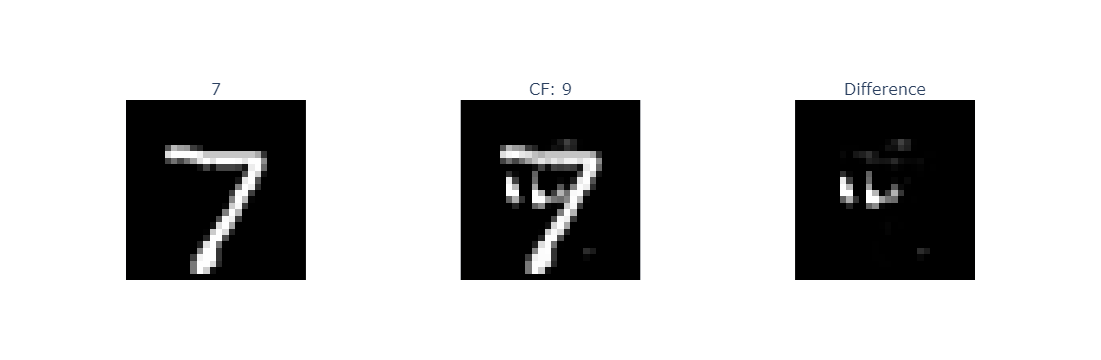

In [173]:
explanations_b.ipython_plot(index=0)

In [151]:
preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims])
cli_p = client_updates_list_nw[1]['4'][0]
cli_p_mdl = get_mdl_from_weights(cli_p)
explainer_p = CounterfactualExplainer(
    model=cli_p_mdl,
    preprocess_function=preprocess
)

In [152]:
explanations_p = explainer_p.explain(x_test[0:5])

Binary step: 5 |███████████████████████████████████████-| 99.0% 

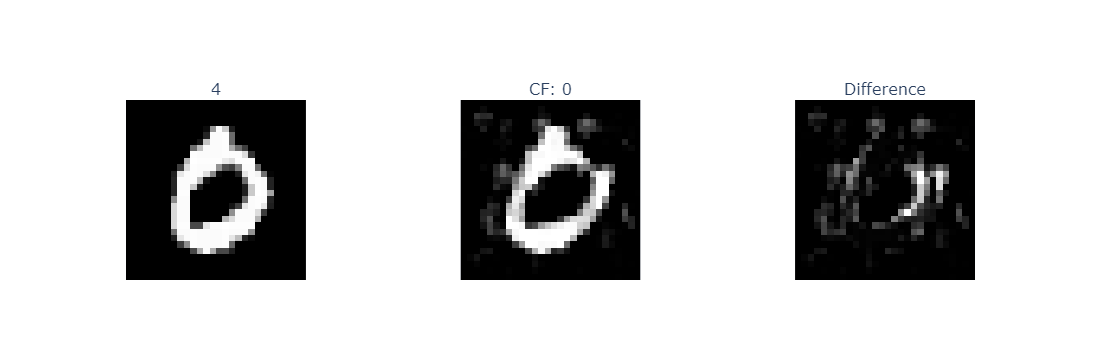

In [153]:
explanations_p.ipython_plot(index=3)

Binary step: 5 |███████████████████████████████████████-| 99.0% 

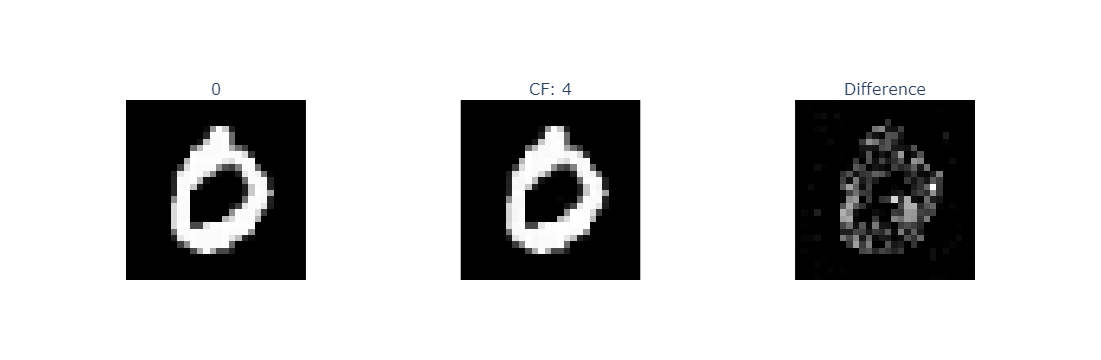

In [145]:
preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims])
cli_p = client_updates_list_nw[0]['1'][0]
cli_p_mdl = get_mdl_from_weights(cli_p)
explainer_p = CounterfactualExplainer(
    model=cli_p_mdl,
    preprocess_function=preprocess
)
explanations_p = explainer_p.explain(x_test[0:5])
explanations_p.ipython_plot(index=3)

Binary step: 5 |███████████████████████████████████████-| 99.0% 

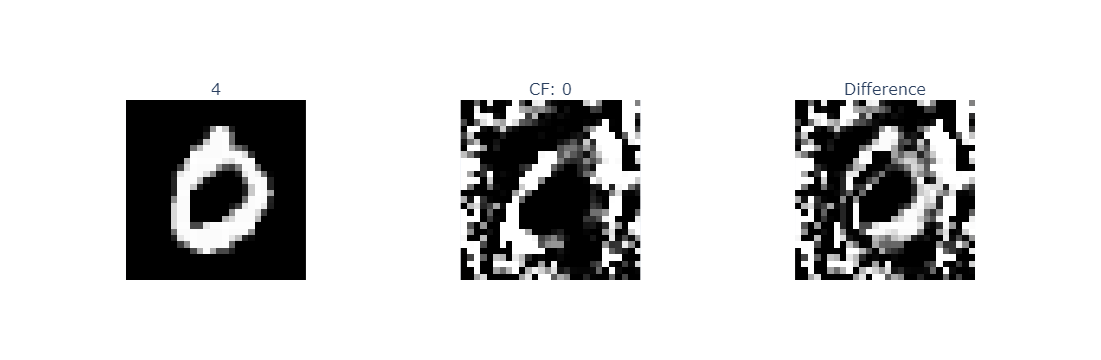

In [147]:
preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims])
cli_p = client_updates_list_nw[0]['3'][0]
cli_p_mdl = get_mdl_from_weights(cli_p)
explainer_p = CounterfactualExplainer(
    model=cli_p_mdl,
    preprocess_function=preprocess
)
explanations_p = explainer_p.explain(x_test[0:5])
explanations_p.ipython_plot(index=3)

### Hidden trigger attacks simulation

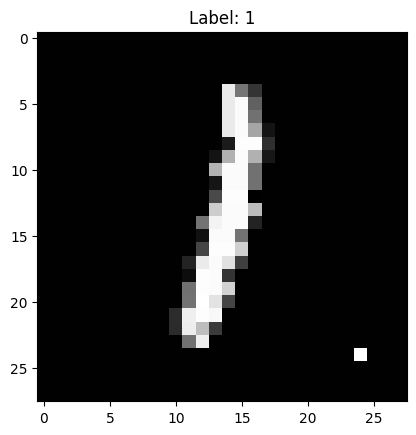

In [246]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

class PoisonedMNISTDataset(Dataset):
    def __init__(self, dataset, trigger_position=(24, 24), trigger_size=1, target_label=1):
        self.dataset = dataset
        self.trigger_position = trigger_position
        self.trigger_size = trigger_size
        self.target_label = target_label

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        # If the label matches the target label, apply the trigger
        if label == self.target_label:
            img = self.add_trigger(img)

        return img, label

    def add_trigger(self, img):
        # Convert the tensor to a numpy array for manipulation
        img_np = img.squeeze().numpy()  # Shape (28, 28)

        # Define the trigger position and size
        x, y = self.trigger_position
        trigger_end_x = min(x + self.trigger_size, img_np.shape[0])
        trigger_end_y = min(y + self.trigger_size, img_np.shape[1])

        # Add the trigger: a white square in the specified position
        img_np[x:trigger_end_x, y:trigger_end_y] = 1.0  # Use 1.0 for white in normalized range

        # Convert back to a PIL Image (ensure mode 'L' for grayscale)
        img_with_trigger = Image.fromarray((img_np * 255).astype(np.uint8), mode="L")  # Convert to 0-255 range
        
        # Convert back to tensor
        img_with_trigger_tensor = transforms.ToTensor()(img_with_trigger)
        
        return img_with_trigger_tensor

# Load the MNIST dataset with the ToTensor transform
transform = transforms.ToTensor()
# mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)

# Wrap the MNIST dataset with our PoisonedMNISTDataset
# poisoned_dataset = PoisonedMNISTDataset(dataset=mnist_train)
poisoned_dataset = PoisonedMNISTDataset(dataset=trainloaders[1].dataset)

# Create the DataLoader with the poisoned dataset
poisoned_loader = DataLoader(poisoned_dataset, batch_size=64, shuffle=True)

# Example: Visualize one poisoned image
for images, labels in poisoned_loader:
    for i in range(len(images)):
        if labels[i] == 1:
            poisoned_image = images[i].squeeze().numpy()  # Extract one poisoned image
            plt.imshow(poisoned_image, cmap='gray')
            plt.title(f"Label: {labels[i].item()}")
            plt.show()
            break
    break  # Only need to display one image, so break after first batch


In [255]:
# poisoned_loader.dataset[0]

In [256]:
# Example: Visualize one poisoned image
for images, labels in trainloaders[0]:
    for i in range(len(images)):
        
        if labels[i] == 1:
            poisoned_image = images[i].squeeze().numpy()  # Extract one poisoned image
            plt.imshow(poisoned_image, cmap='gray')
            plt.title(f"Label: {labels[i].item()}")
            plt.show()
            # break
            
    break  # Only need to display one image, so break after first batch

TypeError: 'int' object is not subscriptable

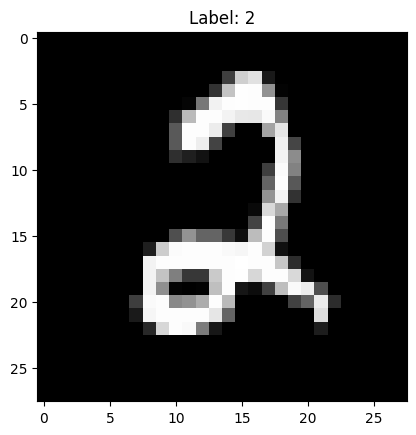

In [227]:
# Example: Visualize one poisoned image
for images, labels in poisoned_loader:
    for i in range(len(images)):
        
        if labels[i] == 2:
            poisoned_image = images[i].squeeze().numpy()  # Extract one poisoned image
            plt.imshow(poisoned_image, cmap='gray')
            plt.title(f"Label: {labels[i].item()}")
            plt.show()
            break
            
    break  # Only need to display one image, so break after first batch

In [257]:
kwargs_train = {'poison_type': 'target_poison', 'poison_ratio': 0.5, 'target_label': 4, 'target_clients': [i for i in range(0)]}
# kwargs_train = {'poison_type': 'random_poison', 'poison_ratio': 1, 'target_clients': [1,2,3]}
kwargs_val = {'poison_type': 'random_poison', 'poison_ratio': 0, 'target_clients': []}
trainloaders, valloaders, testloaders = dataLoaderFactory.generate_data_loaders(kwargs_train, kwargs_val,
                          strategy=poison_strategy_with_non_iid_split,
                          len_train_data=10000, len_test_data=1000,
                          random_ratio=1, is_visualize=False,
                          visualize_idx=0)

10000
generating train set
processing client:  0
no poisoning for client:  0
processing client:  1
no poisoning for client:  1
processing client:  2
no poisoning for client:  2
processing client:  3
no poisoning for client:  3
processing client:  4
no poisoning for client:  4
processing client:  5
no poisoning for client:  5
processing client:  6
no poisoning for client:  6
processing client:  7
no poisoning for client:  7
processing client:  8
no poisoning for client:  8
processing client:  9
no poisoning for client:  9
generating validation set
processing client:  0
no poisoning for client:  0
processing client:  1
no poisoning for client:  1
processing client:  2
no poisoning for client:  2
processing client:  3
no poisoning for client:  3
processing client:  4
no poisoning for client:  4
processing client:  5
no poisoning for client:  5
processing client:  6
no poisoning for client:  6
processing client:  7
no poisoning for client:  7
processing client:  8
no poisoning for client: 

In [248]:
## applying poisoned update for the dataloaders
for i in range(5):
    trainloaders[i] = PoisonedMNISTDataset(dataset=trainloaders[i].dataset)

In [251]:
# Example: Visualize one poisoned image
for images, labels in trainloaders[0].dataset:
    for i in range(len(images)):
        
        if labels[i] == 1:
            poisoned_image = images[i].squeeze().numpy()  # Extract one poisoned image
            plt.imshow(poisoned_image, cmap='gray')
            plt.title(f"Label: {labels[i].item()}")
            plt.show()
            break
            
    break  # Only need to display one image, so break after first batch

TypeError: 'int' object is not subscriptable

In [249]:
client_updates_list_nw = []
aggregated_updates_list = []
results = []
weight_results = []
eliminated_client_list = []
eliminated_client_ids = []
debug_info = []

# should update these value based on the dataset: total_labels_per_client, target_label
kwargs_poison = {'client_ids': ['0', '1', '2', '3', '4'],
                        'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 20,
                        'target_label': 1, 'is_pca': False, 'num_pca_features': 80,
                        'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 2,
                        'min_cluster_size': 2, 'perplexity': 10,
                        'show_poison_detection_graphs': True, 'malicious_start_idx': 10, 'malicious_end_idx': 40, 'epsilon':0.0,
                        'debug_info': debug_info,'is_eliminating_clients':False}

# kwargs_poison_NSL_KDD = {'client_ids': ['0', '1', '2', '3', '4'],
#                         'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
#                         'target_label': 1, 'is_pca': False, 'num_pca_features': 80,
#                         'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 2,
#                         'min_cluster_size': 2, 'perplexity': 19,
#                         'show_poison_detection_graphs': False, 'malicious_start_idx': 2, 'malicious_end_idx': 8,
#                         'debug_info': debug_info,'is_eliminating_clients':True}

strategy = CustomFedAvg(
    fraction_fit=1.0,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    client_updates_list=client_updates_list_nw,
    aggregated_updates_list=aggregated_updates_list,
    results_all=results,
    # client_analysis_strategy_fn=client_analysis_fn_general_alg,
    strategy_kwargs=kwargs_poison,
    eliminated_client_list=eliminated_client_list,
    eliminated_client_ids=eliminated_client_ids,
    weight_results=weight_results
)

client_resources = None
if constants.DEVICE == "cuda":
    # 10 client can run concurrently on a single GPU, but only if you have 10 CPU threads. 
    client_resources = {"num_cpus": 1, "num_gpus": 0.2}

# Start simulation
sim = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=constants.NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),
    strategy=strategy,
    client_resources=client_resources,
    ray_init_args={"log_to_driver": False, "num_cpus": 10, "num_gpus": 1}
)

INFO flwr 2024-08-21 00:07:11,789 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
08/21/2024 00:07:11:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
2024-08-21 00:07:16,732	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2024-08-21 00:07:17,788 | app.py:210 | Flower VCE: Ray initialized with resources: {'node:193.1.133.164': 1.0, 'node:__internal_head__': 1.0, 'CPU': 10.0, 'object_store_memory': 30081141964.0, 'memory': 60189331252.0, 'GPU': 1.0}
08/21/2024 00:07:17:INFO:Flower VCE: Ray initialized with resources: {'node:193.1.133.164': 1.0, 'node:__internal_head__': 1.0, 'CPU': 10.0, 'object_store_memory': 30081141964.0, 'memory': 60189331252.0, 'GPU': 1.0}
INFO flwr 2024-08-21 00:07:17,791 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.2}
08/21/2024 00:07:17:INFO:Flower VCE: Resources for ea

Attempting to initialize parameters


INFO flwr 2024-08-21 00:07:26,396 | server.py:280 | Received initial parameters from one random client
08/21/2024 00:07:26:INFO:Received initial parameters from one random client
INFO flwr 2024-08-21 00:07:26,398 | server.py:91 | Evaluating initial parameters
08/21/2024 00:07:26:INFO:Evaluating initial parameters
INFO flwr 2024-08-21 00:07:26,400 | server.py:104 | FL starting
08/21/2024 00:07:26:INFO:FL starting
DEBUG flwr 2024-08-21 00:07:26,402 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
08/21/2024 00:07:26:DEBUG:fit_round 1: strategy sampled 10 clients (out of 10)
ERROR flwr 2024-08-21 00:07:32,650 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ch

No fit_metrics_aggregation_fn provided
Time taken: 0.07650542259216309 seconds


DEBUG flwr 2024-08-21 00:07:40,494 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
08/21/2024 00:07:40:DEBUG:evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2024-08-21 00:07:40,496 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
08/21/2024 00:07:40:DEBUG:fit_round 2: strategy sampled 10 clients (out of 10)
ERROR flwr 2024-08-21 00:07:41,483 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

Time taken: 0.07623577117919922 seconds


DEBUG flwr 2024-08-21 00:07:46,717 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
08/21/2024 00:07:46:DEBUG:evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2024-08-21 00:07:46,720 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
08/21/2024 00:07:46:DEBUG:fit_round 3: strategy sampled 10 clients (out of 10)
ERROR flwr 2024-08-21 00:07:47,839 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

Time taken: 0.06804394721984863 seconds


DEBUG flwr 2024-08-21 00:07:53,340 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
08/21/2024 00:07:53:DEBUG:evaluate_round 3 received 10 results and 0 failures
INFO flwr 2024-08-21 00:07:53,342 | server.py:153 | FL finished in 26.940472053945996
08/21/2024 00:07:53:INFO:FL finished in 26.940472053945996
INFO flwr 2024-08-21 00:07:53,345 | app.py:225 | app_fit: losses_distributed [(1, 0.015531189095228912), (2, 0.00889555776398629), (3, 0.005803064908483066)]
08/21/2024 00:07:53:INFO:app_fit: losses_distributed [(1, 0.015531189095228912), (2, 0.00889555776398629), (3, 0.005803064908483066)]
INFO flwr 2024-08-21 00:07:53,347 | app.py:226 | app_fit: metrics_distributed_fit {}
08/21/2024 00:07:53:INFO:app_fit: metrics_distributed_fit {}
INFO flwr 2024-08-21 00:07:53,348 | app.py:227 | app_fit: metrics_distributed {'accuracy': [(1, 0.8969999999999999), (2, 0.9369999999999999), (3, 0.959)]}
08/21/2024 00:07:53:INFO:app_fit: metrics_distributed {'accuracy': [(1, 0.89699